In [1]:
import math
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import collections
from scipy.stats.stats import pearsonr
import pandas as pd
import os
from datetime import date

import seaborn as sns
import re

In [2]:
# load of the data
DATASET_DIR = "dataset" + os.path.sep
df_tennis = pd.read_csv(DATASET_DIR + 'tennis_matches.csv', sep=',', index_col=0) 

#index_col=False say to not use the first column as ID
df_male = pd.read_csv(DATASET_DIR + 'male_players.csv', sep=',', index_col=False)
df_female = pd.read_csv(DATASET_DIR + 'female_players.csv', sep=',', index_col=False) 

# Data understanding

## Print some records of the datasets

In [3]:
df_tennis.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_entry,winner_name,...,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue
0,2019-M020,Brisbane,Hard,32.0,A,20181231.0,300.0,105453.0,NaN,Kei Nishikori,...,20.0,14.0,10.0,15.0,9.0,3590.0,16.0,1977.0,3928.0,742618.69
1,2019-M020,Brisbane,Hard,32.0,A,20181231.0,299.0,106421.0,NaN,Daniil Medvedev,...,7.0,10.0,10.0,13.0,16.0,1977.0,239.0,200.0,3928.0,742618.69
2,2019-M020,Brisbane,Hard,32.0,A,20181231.0,298.0,105453.0,NaN,Kei Nishikori,...,6.0,8.0,1.0,5.0,9.0,3590.0,40.0,1050.0,3928.0,742618.69
3,2019-M020,Brisbane,Hard,32.0,A,20181231.0,297.0,104542.0,PR,Jo-Wilfried Tsonga,...,9.0,11.0,4.0,6.0,239.0,200.0,31.0,1298.0,3928.0,742618.69
4,2019-M020,Brisbane,Hard,32.0,A,20181231.0,296.0,106421.0,NaN,Daniil Medvedev,...,19.0,15.0,2.0,4.0,16.0,1977.0,18.0,1855.0,3928.0,742618.69


In [4]:
df_male.head()

,name,surname
0,Gardnar,Mulloy
1,Pancho,Segura
2,Frank,Sedgman
3,Giuseppe,Merlo
4,Richard Pancho,Gonzales


In [5]:
df_female.head()

,name,surname
0,Bobby,Riggs
1,X,X
2,Martina,Hingis
3,Mirjana,Lucic
4,Justine,Henin


## Missing values: Null

In [6]:
#info about data that we have for male
df_male.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55208 entries, 0 to 55207
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   name     55031 non-null  object
 1   surname  55165 non-null  object
dtypes: object(2)
memory usage: 862.8+ KB


In [7]:
#number of null in the columns
df_male.isnull().sum(axis = 0)

name       177
surname     43
dtype: int64

<AxesSubplot:ylabel='number of nulls'>

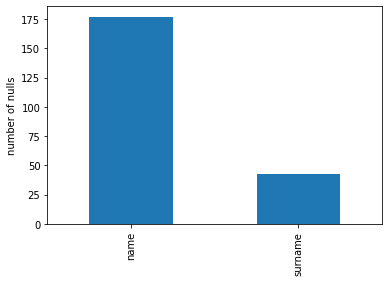

In [8]:
df_male.isnull().sum(axis = 0).plot(kind='bar', ylabel="number of nulls")

So, the male dataframe has 2 columns: name and surname. It has 55208 entries and about 200 null values in total.

In [9]:
#info about data that we have for female
df_female.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46172 entries, 0 to 46171
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   name     44505 non-null  object
 1   surname  46172 non-null  object
dtypes: object(2)
memory usage: 721.6+ KB


In [10]:
#number of null in the columns
df_female.isnull().sum(axis = 0)

name       1667
surname       0
dtype: int64

<AxesSubplot:ylabel='number of nulls'>

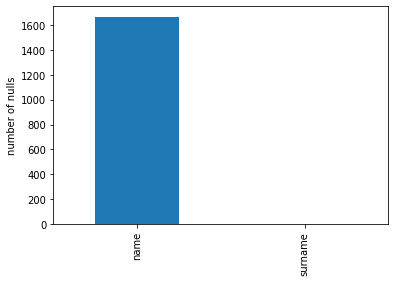

In [11]:
df_female.isnull().sum(axis = 0).plot(kind='bar', ylabel="number of nulls")

So, the female dataframe has 2 columns: name and surname. It has 46172  entries and 1667 null values in the name, but the surname is never null.

In [12]:
df_tennis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186128 entries, 0 to 186127
Data columns (total 49 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   tourney_id          186073 non-null  object 
 1   tourney_name        186103 non-null  object 
 2   surface             185940 non-null  object 
 3   draw_size           186099 non-null  float64
 4   tourney_level       186099 non-null  object 
 5   tourney_date        186100 non-null  float64
 6   match_num           186101 non-null  float64
 7   winner_id           186073 non-null  float64
 8   winner_entry        25827 non-null   object 
 9   winner_name         186101 non-null  object 
 10  winner_hand         186082 non-null  object 
 11  winner_ht           49341 non-null   float64
 12  winner_ioc          186099 non-null  object 
 13  winner_age          183275 non-null  float64
 14  loser_id            186100 non-null  float64
 15  loser_entry         44154 non-null

In [13]:
#we see if the attributes have some null values
df_tennis.isnull().any()

tourney_id            True
tourney_name          True
surface               True
draw_size             True
tourney_level         True
tourney_date          True
match_num             True
winner_id             True
winner_entry          True
winner_name           True
winner_hand           True
winner_ht             True
winner_ioc            True
winner_age            True
loser_id              True
loser_entry           True
loser_name            True
loser_hand            True
loser_ht              True
loser_ioc             True
loser_age             True
score                 True
best_of               True
round                 True
minutes               True
w_ace                 True
w_df                  True
w_svpt                True
w_1stIn               True
w_1stWon              True
w_2ndWon              True
w_SvGms               True
w_bpSaved             True
w_bpFaced             True
l_ace                 True
l_df                  True
l_svpt                True
l

In [14]:
#since all the attributes has missing values, we count them
df_tennis.isnull().sum(axis = 0)

tourney_id                55
tourney_name              25
surface                  188
draw_size                 29
tourney_level             29
tourney_date              28
match_num                 27
winner_id                 55
winner_entry          160301
winner_name               27
winner_hand               46
winner_ht             136787
winner_ioc                29
winner_age              2853
loser_id                  28
loser_entry           141974
loser_name                31
loser_hand                98
loser_ht              147780
loser_ioc                 26
loser_age               6538
score                    199
best_of                   29
round                     30
minutes               104468
w_ace                 103818
w_df                  103816
w_svpt                103818
w_1stIn               103818
w_1stWon              103816
w_2ndWon              103819
w_SvGms               103817
w_bpSaved             103813
w_bpFaced             103816
l_ace         

We can notice that some attributes have very few null values, but other attributes has more than 50% of null values

<AxesSubplot:>

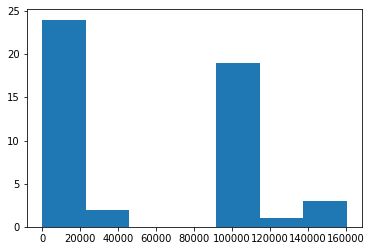

In [15]:
df_tennis.isnull().sum(axis = 0).hist(bins="sturges", grid=False)

## Duplicate data

In [16]:
#we see if there are duplicates in the dataset male and female
df_male.duplicated(keep='first').sum()

524

In [17]:
df_female.duplicated(keep='first').sum()

511

So, both the datasets of male and female has rows with same name and surname. These rows can be duplicates (so they correspond to the same person) or they can be homonyms. In this latter case we cannot distinguish the matches of one player by the ones of the other player.

In [18]:
#we remove (only) the duplicated rows
df_male_no_dup = df_male.drop_duplicates()
df_female_no_dup = df_female.drop_duplicates()

In [19]:
#see if a name can be both male and female and manage them
df_players = pd.concat([df_male_no_dup, df_female_no_dup])
df_players[df_players.duplicated(keep='first')==True]

,name,surname
0,Bobby,Riggs
417,Robin,White
2687,Di,Zhao
3660,J,Tobin
3918,Yi,Liu
...,...,...
44222,NaN,Beckert
45538,J,Lambert
45597,J,Young
45658,M,Noble


In [20]:
df_players.duplicated(keep='first').sum()

74

So, there are 74 names for both players male and female.

In [21]:
df_players[df_players.duplicated(subset=['name', 'surname'], keep='first')==True]

,name,surname
0,Bobby,Riggs
417,Robin,White
2687,Di,Zhao
3660,J,Tobin
3918,Yi,Liu
...,...,...
44222,NaN,Beckert
45538,J,Lambert
45597,J,Young
45658,M,Noble


In [22]:
#check if there are duplicated rows in the dataset
df_tennis.duplicated(keep='first').sum()

309

## Noise, outliers and data quality (data visualization here)

|  Categorical  |   Ordinal   |      Numerical     | Ratio-Scaled |
|:-------------:|:-----------:|:------------------:|:------------:|
|   tournay_id  |  match_num  |      draw_size     |   winner_ht  |
|  tournay_name | winner_rank |       minutes      |  winner_age  |
|    surface    |             |     winner_ace     |              |
| tournay_level |             |      winner_df     |              |
|   winner_id   |             |     winner_svpt    |              |
|   winner_ioc  |             |    winner_1stln    |              |
|  winner_hand  |             |    winner_1stwon   |              |
|  winner_entry |             |    winner_2stwon   |              |
|    best_of    |             |       w_svgms      |              |
|               |             | winner_rank_points |              |
|               |             |      w_bdsaved     |              |
|               |             |      w_bdfaced     |              |

For each winner attribute there is the loser counterpart

### Invalid characters in names and surnames 

In [23]:
#TO DO: Check that the names in female are for female and not male and viceversa

In [24]:
df_tennis.columns

Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_entry', 'winner_name',
       'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age', 'loser_id',
       'loser_entry', 'loser_name', 'loser_hand', 'loser_ht', 'loser_ioc',
       'loser_age', 'score', 'best_of', 'round', 'minutes', 'w_ace', 'w_df',
       'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved',
       'w_bpFaced', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon',
       'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced', 'winner_rank',
       'winner_rank_points', 'loser_rank', 'loser_rank_points',
       'tourney_spectators', 'tourney_revenue'],
      dtype='object')

In [25]:
#see if all the names and surnames are valid (only letters)
df_male[df_male['surname'].str.count("[a-zA-Z '.-]")!=df_male['surname'].str.len()]

,name,surname
385,Jose,Garcia G003
457,Pedro,Gonzalez G162
858,Robert,Casey C100
1134,Robert,Phillips P239
1301,Ola,Jonsson J092
...,...,...
44808,Jorman,Reyes Rc60
45850,NaN,Bye1
46253,Fernando,Cabrera (Chi)
49618,Juan,Martin (Bra)


In [26]:
df_male[df_male['name'].str.count("[a-zA-Z ',.-]")!=df_male['name'].str.len()]

,name,surname
10429,NaN,NaN
16955,??,Baillie
17067,NaN,Rf Le Sueur
17091,NaN,A Riches
17093,NaN,N Zaher
...,...,...
49714,NaN,Mezquita
49715,NaN,Vicens
49722,NaN,Segun
51999,NaN,I Georgiadis


In [27]:
df_check_name = df_male[~df_male['name'].isna()]
df_check_name[df_check_name['name'].str.contains(',')]

,name,surname
40071,"Jason ""Jj"",Belan",NaN


In [28]:
#unknown names
print("Unknown name: ", df_male[df_male['name'].str.lower()=='unknown'].shape[0])
#unknown surnames
print("Unknown surname: ", df_male[df_male['surname'].str.lower()=='unknown'].shape[0])

Unknown name:  50
Unknown surname:  6


In [29]:
df_female[df_female['surname'].str.count("[a-zA-Z '.-]")!=df_female['surname'].str.len()]

,name,surname
21238,Ekaterina,Makarova 1996
31618,Habiba,El_Anany


In [30]:
df_female[df_female['name'].str.count("[a-zA-Z ',.-]")!=df_female['name'].str.len()]

,name,surname
3763,NaN,Marine
16643,NaN,Brown
16699,NaN,Mckinney
16701,NaN,Munsell
16746,NaN,Raimo
...,...,...
45989,NaN,Valtier
46027,NaN,Keppel
46072,NaN,Bavinger
46076,NaN,Weeks


In [31]:
df_check_name = df_female[~df_female['name'].isna()]
df_check_name[df_check_name['name'].str.contains(',')]

,name,surname


In [32]:
#unknown names
print("Unknown name: ", df_female[df_female['name'].str.lower()=='unknown'].shape[0])
#unknown surnames
print("Unknown surname: ", df_female[df_female['surname'].str.lower()=='unknown'].shape[0])

Unknown name:  0
Unknown surname:  0


So, in the male and female datasets we have some invalid names and surnames because of numbers, special characters of null values.

NOTE: "40071 	Jason "Jj",Belan 	NaN" is an error because Belan is the surname but pandas has not divided the name by the surname (male). Correction in the data preparation

### Analysis of tennis dataset

In [33]:
df_tennis.dtypes.value_counts()

float64    35
object     14
dtype: int64

In [34]:
#Values in the columns with type object
for column in df_tennis.select_dtypes(include=['object']).columns:
    print("Distinct Values in "+str(column)+": \n", df_tennis[column].unique(), "\n")

Distinct Values in tourney_id: 
 ['2019-M020' '2019-0451' '2019-0891' ... '2020-W-ITF-USA-47A-2020'
 '2020-W-ITF-USA-48A-2020' nan] 

Distinct Values in tourney_name: 
 ['Brisbane' 'Doha' 'Pune' ... 'W100 Nicholasville KY' 'W25 Las Vegas NV'
 nan] 

Distinct Values in surface: 
 ['Hard' 'Clay' 'Grass' 'Carpet' nan] 

Distinct Values in tourney_level: 
 ['A' 'P' 'G' 'I' 'M' 'PM' 'F' 'D' 'C' '15' '25' '60' '100' '80' '10' '50'
 '75' 'O' 'W' nan] 

Distinct Values in winner_entry: 
 [nan 'PR' 'Q' 'WC' 'Alt' 'LL' 'SE' 'ALT' 'SR' 'JE' 'A' 'ITF' 'P' 'I' 'IR'
 'JR'] 

Distinct Values in winner_name: 
 ['Kei Nishikori' 'Daniil Medvedev' 'Jo-Wilfried Tsonga' ... 'Sultan Gonen'
 'Viktoria Veleva' nan] 

Distinct Values in winner_hand: 
 ['R' 'L' 'U' nan] 

Distinct Values in winner_ioc: 
 ['JPN' 'RUS' 'FRA' 'AUS' 'CAN' 'BUL' 'GBR' 'SRB' 'USA' 'LAT' 'CZE' 'EST'
 'UKR' 'NED' 'CRO' 'BLR' 'CHI' 'SUI' 'POL' 'GER' 'LUX' 'ESP' 'ITA' 'GEO'
 'HUN' 'LTU' 'ARG' 'CYP' 'BIH' 'RSA' 'BEL' 'TUN' 'IND' 'BRA' 'AU

#### tourney_id

In [35]:
#check that for non null values, the first 4 char are the year
#count rows whose firts 4 char are not numbers
df_tennis[df_tennis['tourney_id'].str[:4].str.isnumeric()==False].shape[0] 

0

In [36]:
#chech if some years are in the future (so are invalid)(ignore nulls)
df_tennis[pd.to_numeric(df_tennis['tourney_id'].str[:4]).fillna(0).astype('int') > date.today().year].shape[0] 

0

In [37]:
#chech if there are invalid years because to much in the past (ignore nulls)
df_tennis[pd.to_numeric(df_tennis['tourney_id'].str[:4]).fillna(date.today().year).astype('int') < 1874 ].shape[0] 

0

So, the first 4 numbers in the tourney_id are always valid when the tourney_id id not null

In [38]:
#chech that for each tourney there is more than one match (every id appears more than once)
df_tennis[df_tennis['tourney_id'].duplicated(keep=False)==False].shape[0] 

0

So, every torney_id appears more than once

In [39]:
#check how many distinct tourney are present
df_tennis["tourney_id"].value_counts().count()

4853

#### tourney_name

In [40]:
#chech that for the same tourney_id we have always the same name
len(df_tennis.groupby(['tourney_id','tourney_name']).size())-len(df_tennis.groupby(['tourney_id']).size())
#df_tennis[df_tennis['tourney_id']=='2019-M021'] #this is an example of toruney id with more names

30

In [41]:
len(df_tennis.groupby(['tourney_name','tourney_id']).size())-len(df_tennis.groupby(['tourney_name']).size())

2395

For a certain tourney_id we may have more tourney_names, so we should manage these names for example to remove errors from some rows. For a tourney_name we can have more tourney_ids.

In [42]:
#len(df_tennis["tourney_name"].unique()) #consider also the nan
df_tennis["tourney_name"].value_counts().count() #do not consider also the nan

2488

In [43]:
dict_tourney_id = df_tennis.groupby('tourney_id')['tourney_name'].unique().apply(list).to_dict()
for key, value in dict_tourney_id.items():
    if len(value)>1:
        print(key, value)

2016-M006 ['Indian Wells', 'Indian Wells Masters']
2016-M007 ['Miami', 'Miami Masters']
2016-M009 ['Rome', 'Rome Masters']
2016-M010 ["'s Hertogenbosch", 's Hertogenbosch']
2016-M021 ['Madrid', 'Madrid Masters']
2016-M024 ['Cincinnati', 'Cincinnati Masters']
2016-O16 ['Olympics', 'Rio Olympics']
2017-M006 ['Indian Wells', 'Indian Wells Masters']
2017-M007 ['Miami', 'Miami Masters']
2017-M009 ['Rome', 'Rome Masters']
2017-M010 ["'s Hertogenbosch", 's Hertogenbosch']
2017-M015 ['Beijing ', 'Beijing']
2017-M021 ['Madrid', 'Madrid Masters']
2017-M024 ['Cincinnati', 'Cincinnati Masters']
2018-M006 ['Indian Wells Masters', 'Indian Wells']
2018-M007 ['Miami Masters', 'Miami']
2018-M009 ['Rome Masters', 'Rome']
2018-M010 ['s Hertogenbosch', 's-Hertogenbosch']
2018-M021 ['Madrid Masters', 'Madrid']
2018-M024 ['Cincinnati Masters', 'Cincinnati']
2019-560 ['US Open', 'Us Open']
2019-M006 ['Indian Wells Masters', 'Indian Wells']
2019-M007 ['Miami Masters', 'Miami']
2019-M009 ['Rome Masters', 'Rome

**surface**

In [44]:
df_tennis.groupby('surface')['tourney_id'].nunique()

surface
Carpet      88
Clay      2042
Grass      103
Hard      2558
Name: tourney_id, dtype: int64

#### tourney_level

In [45]:
#TODO:tourney_level check that tourney level for male are associated to tourney with male players (same for female).
#explain also the meanings of the levels

In [46]:
levels_man = ['G', 'M', 'A', 'C', 'S', 'F', 'D']
levels_woman = levels_man + ['P', 'PM', 'I', 'T1', 'W']
levels_woman_man = ['E','J','T','O','15', '25', '60', '100', '80', '10', '50', '75'] #not present in the dataset yet (documentation)
all_levels = levels_man + levels_woman + levels_woman_man

In [47]:
#check what are other codes that can appear (for women)
df_other_levels = df_tennis[~df_tennis['tourney_level'].isin(all_levels)]
#get codes about the prize money
df_other_levels[df_other_levels['tourney_level'].str.isnumeric()==True]['tourney_level'].unique()

array([], dtype=object)

These are the numeric codes that appear in the dataset

In [48]:
#get the other codes not cited in the document and that are not prize
df_other_levels[df_other_levels['tourney_level'].str.isnumeric()==False]['tourney_level'].unique()

array([], dtype=object)

We have 2 more codes respect the one expressely indicated by the documentation

In [49]:
#check if there are at least one row for each cited code
list(set(all_levels) - set(df_tennis[df_tennis['tourney_level'].str.isnumeric()==False]['tourney_level'].unique()))

['75', '100', '15', 'T1', '25', '10', 'T', 'J', '50', 'S', '60', 'E', '80']

For these codes there are no rows in the dataset

In [50]:
#get the occurrenes of each level
df_tennis["tourney_level"].value_counts()

15     45807
C      40865
25     30743
A      11678
10     11372
G       9981
I       8452
60      6517
P       5944
M       3877
100     2685
D       2373
80      1909
50      1488
PM      1478
W        436
F        211
75       155
O        128
Name: tourney_level, dtype: int64

In [51]:
# check sex by names
df_male['combined'] = df_male['name'].astype(str) + ' ' + df_male['surname'].astype(str)
df_female['combined'] = df_female['name'].astype(str) + ' ' + df_female['surname'].astype(str)

# we transform into dictionaries to optimize search performance, putting name and surname as keys
dict_male = df_male['combined'].to_dict();
dict_male_rev = {value:key for key, value in dict_male.items()}

dict_female = df_female['combined'].to_dict();
dict_female_rev = {value:key for key, value in dict_female.items()}

# check name in male and female dictionaries
def CheckSex(name):
    if name in dict_male_rev:
        return 'm'
    elif name in dict_female_rev:
        return 'f'
    return '-'

df_tennis_level_tmp = df_tennis.copy() # avoid overwrite original dataset
# apply CheckSex as lambda function to all rows, add new columns with sex
df_tennis_level_tmp['w_sex'] = df_tennis_level_tmp['winner_name'].apply(lambda x: CheckSex(x))
df_tennis_level_tmp['l_sex'] = df_tennis_level_tmp['loser_name'].apply(lambda x: CheckSex(x))

no_error = True
for row in df_tennis_level_tmp.itertuples():
    level = row.tourney_level
    # if there is a nan in level, skip to next...
    if str(level)=='nan':
        continue
    w_sex = row.w_sex
    l_sex = row.l_sex 
    # check sex...
    if w_sex == 'm' or l_sex == 'm':
        # search for the level in the respective set for man and woman/man
        if level not in levels_man and level not in levels_woman_man:  
            no_error = False
            print('level error: w_sex:' + w_sex + ' - l_sex:' + l_sex + ' - tourney_id:' + str(row.tourney_id) + ' - ' + str(wn) + ' vs ' + str(ln) + ' - level:' + str(level))
    elif w_sex == 'f' or l_sex == 'f':
        # search for the level in the respective set for man and woman/man
        if level not in levels_woman and level not in  levels_woman_man:
            no_error = False
            print('level error: w_sex:' + w_sex + ' - l_sex:' + l_sex + ' - tourney_id:' + str(row.tourney_id) + ' - ' + str(wn) + ' vs ' + str(ln) + ' - level:' + str(level))
            
if no_error:
    print("All levels are correct")

All levels are correct


array(['A', 'P', 'G', 'I', 'M', 'PM', 'F', 'D', 'C', '15', '25', '60',
       '100', '80', '10', '50', '75', 'O', 'W', nan], dtype=object)

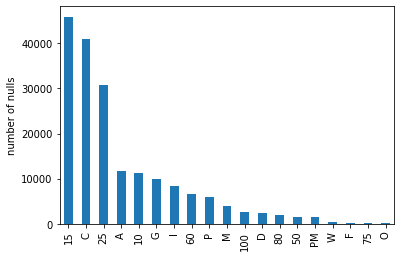

In [52]:
df_tennis["tourney_level"].value_counts().plot(kind='bar', ylabel="number of nulls")
df_tennis["tourney_level"].unique()

#### winner_name and loser_name

In [53]:
#check that names are valid
df_tennis[df_tennis['winner_name'].str.count("[a-zA-Z ',.-]")!=df_tennis['winner_name'].str.len()]['winner_name']

70116     Alejandro Gomez Gb42
74122     Alejandro Gomez Gb42
74136     Alejandro Gomez Gb42
74160     Alejandro Gomez Gb42
74169     Alejandro Gomez Gb42
                  ...         
186117                     NaN
186118                     NaN
186120                     NaN
186121                     NaN
186123                     NaN
Name: winner_name, Length: 105, dtype: object

In [54]:
df_tennis[df_tennis['loser_name'].str.count("[a-zA-Z ',.-]")!=df_tennis['loser_name'].str.len()]['loser_name']

69886     Alejandro Gomez Gb42
70124     Alejandro Gomez Gb42
70862       Michael Grant Gd13
74143     Alejandro Gomez Gb42
74174     Alejandro Gomez Gb42
                  ...         
186119                     NaN
186123                     NaN
186125                     NaN
186126                     NaN
186127                     NaN
Name: loser_name, Length: 108, dtype: object

Execute the next three lines to execute the checks on male and female names.

In [55]:
df_names = pd.read_csv(DATASET_DIR + 'names.csv', sep=',', index_col=False)
df_names.head()

,Birth_Year,Gender,Ethnic_Group,Name,Count,Rank
0,2011-11-08,FEMALE,HISPANIC,GERALDINE,13,75
1,2011-11-08,FEMALE,HISPANIC,GIA,21,67
2,2011-11-08,FEMALE,HISPANIC,GIANNA,49,42
3,2011-11-08,FEMALE,HISPANIC,GISELLE,38,51
4,2011-11-08,FEMALE,HISPANIC,GRACE,36,53


In [56]:
male_names = df_names[df_names['Gender'] == 'MALE']['Name']
male_names = dict.fromkeys(male_names, None)

In [57]:
female_names = df_names[df_names['Gender'] == 'FEMALE']['Name']
female_names = dict.fromkeys(female_names, None)

*male name*

In [58]:
invalid_names = []
for name in df_male['name'].dropna().tolist():
    if (name in female_names):
        invalid_names.append(name)
print(dict.fromkeys(invalid_names, None).keys())

dict_keys(['Ashley', 'Milan', 'Charlie', 'Angel', 'Kelly', 'Simone', 'Jamie', 'Alexis', 'Andrea', 'Michal', 'Sasha', 'Blake', 'Leslie', 'Toby', 'Jocelyn', 'Jordan', 'Taylor', 'Morgan', 'Paris', 'Valery', 'Dylan', 'Ariel', 'Logan', 'Kelsey', 'Amani', 'Lindsay', 'Naomi', 'Ruby', 'Farah', 'Perry', 'Sydney', 'Sunny', 'Mackenzie', 'Karen', 'Aubrey', 'Sima', 'Hope', 'Peyton', 'Shirley', 'Avery', 'Jessie', 'Vivian', 'Eden', 'Destiny', 'Emerson', 'Rosa', 'Parker', 'Chana', 'Joy', 'Mina', 'Aria', 'Reese', 'Ada', 'Olive', 'Addison', 'Arya', 'Rowan', 'Skyler', 'Winter', 'Quinn', 'Alisson', 'Maria', 'Vicky', 'Frances', 'Aiza', 'Stacy', 'Valerie', 'Suri', 'Kennedy', 'Riley', 'Lilian', 'Payton', 'Sage', 'Danielle', 'Gabriela'])


*female names*

In [59]:
invalid_names = []
for name in df_female['name'].dropna().tolist():
    if (name in male_names):
        invalid_names.append(name)
print(dict.fromkeys(invalid_names, None).keys())

dict_keys(['Chris', 'Shawn', 'Jean', 'Alex', 'Eden', 'Alexis', 'Ali', 'Riley', 'Taylor', 'Angel', 'Christian', 'Noel', 'Kyle', 'Zane', 'Nikita', 'Austin', 'Connor', 'Cameron', 'Daniel', 'Luca', 'Spencer', 'Ariel', 'Quinn', 'Theo', 'Sean', 'Alpha', 'Ayan', 'Tyler', 'Devin', 'Carson', 'Jayden', 'Gabriel', 'Rowan', 'Jesse', 'Jordan', 'Ryan', 'Andre', 'Danny', 'Ari', 'Peyton', 'Lian', 'Drew', 'Dylan', 'Elan', 'Skyler', 'Milan', 'Adrian', 'Owen', 'August', 'Randy', 'Andy', 'Francis', 'Jerry', 'Dean', 'Lenny', 'Carter', 'Johan', 'Tony', 'Travis', 'Liam', 'Jay', 'Peter', 'George', 'Marcel'])


There are invalid characters in the names of some winners and some losers

#### winner_id and loser_id

In [60]:
df_tennis['winner_id'].value_counts()

104925.0    289
106421.0    267
100644.0    267
104745.0    262
126774.0    254
           ... 
222775.0      1
221424.0      1
222774.0      1
211909.0      1
225861.0      1
Name: winner_id, Length: 6176, dtype: int64

In [61]:
df_tennis['loser_id'].value_counts()

105943.0    180
105063.0    174
106148.0    170
105166.0    169
106368.0    169
           ... 
209108.0      1
208320.0      1
208063.0      1
209952.0      1
223451.0      1
Name: loser_id, Length: 10031, dtype: int64

In [62]:
#check if there are records in whitch the winner_id e loser_id corresponds
def find_match_sameWL():
    df_sameWL = df_tennis[df_tennis['winner_id'] == df_tennis['loser_id']][['tourney_id','match_num','winner_id', 'loser_id', 'winner_name', 'loser_name','winner_ioc','loser_ioc']]
    print(df_sameWL.shape[0])
    return df_sameWL
    
find_match_sameWL()

5


,tourney_id,match_num,winner_id,loser_id,winner_name,loser_name,winner_ioc,loser_ioc
72793,2016-7182,244.0,122059.0,122059.0,Steven De Waard,Steven De Waard,AUS,AUS
75235,2016-7553,261.0,105026.0,105026.0,Takuto Niki,Takuto Niki,JPN,JPN
75636,2016-7614,249.0,105781.0,105781.0,Andrei Vasilevski,Andrei Vasilevski,BLR,BLR
133100,2018-W-WITF-UKR-02A-2018,6.0,221371.0,221371.0,Lyubov Kostenko,Lyubov Kostenko,UKR,UKR
135577,2019-W-ITF-AUS-04A-2019,15.0,221862.0,221862.0,Sophia Fry,Sophia Fry,AUS,AUS


There are five records in whitch winner and loser are the same. 

In [63]:
#check if there are ids binded with more then one name
def get_w_id_names():
    dup_w_id = df_tennis.groupby(by = 'winner_id')[['winner_name','winner_id']].nunique()
    return dup_w_id[dup_w_id['winner_name'] > 1].index.tolist()

In [64]:
df_mul_names = df_tennis[df_tennis['winner_id'].isin(get_w_id_names())][['winner_name','winner_id']].sort_values(by=['winner_name','winner_id'])
df_mul_names = df_mul_names.value_counts().reset_index()
df_mul_names.columns = ['winner_name', 'id', 'count']
df_mul_names.sort_values(by='id')

,winner_name,id,count
18,Kai Lemstra,202349.0,1
24,Rushmi Chakravarthi,202349.0,1
8,Marvin Moeller,202359.0,14
9,Chin Wei Chan,202359.0,10
3,An Sophie Mestach,202420.0,52
13,Aidan Mchugh,202420.0,6
0,Alison Van Uytvanck,202421.0,142
17,George Houghton,202421.0,1
4,Julia Boserup,202426.0,48
20,Matt Halpin,202426.0,1


In [65]:
def get_l_id_names():
    dup_l_id = df_tennis.groupby(by = 'loser_id')[['loser_name','loser_id']].nunique()
    return dup_l_id[dup_l_id['loser_name'] > 1].index.tolist()

In [66]:
df_mul_names = df_tennis[df_tennis['loser_id'].isin(get_l_id_names())][['loser_name','loser_id']].sort_values(by=['loser_name','loser_id'])
df_mul_names = df_mul_names.value_counts().reset_index()
df_mul_names.columns = ['loser_name', 'id', 'count']
df_mul_names.sort_values(by='id')

,loser_name,id,count
89,Kushaan Nath,200033.0,1
21,Serena Williams,200033.0,34
35,Liga Dekmeijere,202273.0,10
61,Anurag Nenwani,202273.0,2
24,Mariana Correa,202277.0,28
...,...,...,...
28,Amira Benaissa,208603.0,14
86,Karlis Ozolins,209866.0,1
44,Grace Leake,209866.0,4
31,Zeynep Sena Sarioglan,216569.0,12


In [67]:
def get_w_name_ids():
    dup_w_id = df_tennis.groupby(by = 'winner_name')[['winner_name','winner_id']].nunique()
    return dup_w_id[dup_w_id['winner_id'] > 1].index.tolist()

In [68]:
df_tennis[df_tennis['winner_name'].isin(get_w_name_ids())][['winner_name','winner_id','winner_ioc','winner_hand']].drop_duplicates().sort_values(by='winner_name')

,winner_name,winner_id,winner_ioc,winner_hand
167668,Astrid Cirotte,236980.0,FRA,U
172168,Astrid Cirotte,223401.0,FRA,U
124993,Fitriani Sabatini,221189.0,INA,U
173281,Fitriani Sabatini,239429.0,INA,U
69985,Kuan Yi Lee,134120.0,TPE,R
134878,Kuan Yi Lee,221745.0,TPE,R
141854,Liisa Varul,222914.0,EST,U
179935,Liisa Varul,222915.0,EST,U
182257,Maria Fernanda Navarro,223287.0,MEX,U
166903,Maria Fernanda Navarro,223367.0,MEX,U


In [69]:
def get_l_name_ids():
    dup_l_id = df_tennis.groupby(by = 'loser_name')[['loser_name','loser_id']].nunique()
    return dup_l_id[dup_l_id['loser_id'] > 1].index.tolist()

In [70]:
df_tennis[df_tennis['loser_name'].isin(get_l_name_ids())][['loser_name','loser_id','loser_ioc','loser_hand']].drop_duplicates().sort_values(by='loser_name')

,loser_name,loser_id,loser_ioc,loser_hand
166474,Astrid Cirotte,223401.0,FRA,U
167682,Astrid Cirotte,236980.0,FRA,U
468,Ekaterina Makarova,201505.0,RUS,L
51441,Ekaterina Makarova,223126.0,RUS,U
145130,Eleni Fasoula,222943.0,KAZ,U
145085,Eleni Fasoula,222942.0,GRE,U
176942,Ellie Myers,240168.0,USA,U
160585,Ellie Myers,222407.0,USA,U
163270,Emilse Lujan Ruiz,236974.0,ARG,U
135229,Emilse Lujan Ruiz,222646.0,ARG,U


there are tennis players that presents more then one id associated, both for winners(9) and losers(19).

#### winner_hand and loser_hand

In [71]:
#check that there are not indicated hand that are invalid (ignore nulls)
hand = ['R','L','U']
df_tennis[~df_tennis['winner_hand'].fillna('U').str.upper().isin(hand)].shape[0]

0

In [72]:
df_tennis[~df_tennis['loser_hand'].fillna('U').str.upper().isin(hand)].shape[0]

0

In [73]:
#check based on id and name
errors = []
players_ids = df_tennis['winner_id'].dropna().unique().tolist() + df_tennis['loser_id'].dropna().unique().tolist()

for player_id in players_ids:
    name_players = df_tennis[df_tennis['winner_id']==player_id]['winner_name'].dropna().unique().tolist()
    name_players = name_players + df_tennis[df_tennis['loser_id']==player_id]['loser_name'].dropna().unique().tolist()
    name_players = list(dict.fromkeys(name_players))
    for name in name_players:
        hands = df_tennis[df_tennis['winner_name']==name]['winner_hand'].dropna().unique().tolist()
        hands = hands + df_tennis[df_tennis['loser_name']==name]['loser_hand'].dropna().unique().tolist()
        hands = list(dict.fromkeys(hands))
        if len(hands)==3:
            errors.append(name)
        elif len(hands)==2 and 'U' not in hands:
            errors.append(name)
            
print(errors) #result:[]

[]


There are not invalid entries for the hand of winner or loser. Furthermore thare are not different hands for the same player

<AxesSubplot:>

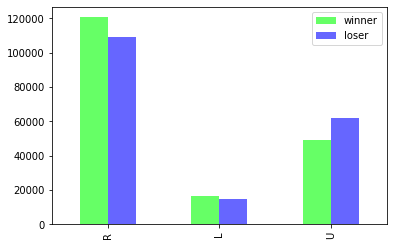

In [74]:
index = df_tennis[~df_tennis['winner_hand'].isna()]['winner_hand'].unique()
pd.DataFrame({'winner': df_tennis['winner_hand'].value_counts(), 'loser': df_tennis['loser_hand'].value_counts()}, index=index).plot.bar(color=["#66ff66","#6666ff"])

#### winner_ioc and loser_ioc, International Olympic Code validity check

In [75]:
df_countrycode = pd.read_csv(DATASET_DIR + 'country-codes_csv.csv', sep=',', index_col=False) 

##### Wrong codes winner_ioc

In [76]:
w_check_cc = pd.Series(~df_tennis.winner_ioc.isin(df_countrycode.IOC).values, df_tennis.winner_ioc.values)
w_check = w_check_cc[w_check_cc].index
w_check.value_counts()

MNE    198
TRI     21
PHL     18
UNK      8
SGP      8
DEU      8
POC      5
GRC      3
NLD      2
NGA      1
dtype: int64

##### Wrong codes loser_ioc

In [77]:
l_check_cc = pd.Series(~df_tennis.loser_ioc.isin(df_countrycode.IOC).values, df_tennis.loser_ioc.values)
l_check = l_check_cc[l_check_cc].index
l_check.value_counts()

MNE    193
SGP     50
UNK     37
TRI     31
PHL     16
DEU     11
LVA      9
NLD      8
SAU      6
POC      4
MRN      3
LBN      3
NGA      3
BGR      2
GRC      2
ITF      1
CRI      1
dtype: int64

We can verify that the list of IOC codes that is incorrect is not in ISO format by mistake.

In [78]:
i = w_check.unique()
type(i)
for c in i:
    exist =  df_countrycode["ISO3166-1-Alpha-3"].str.contains('MNE').any()
    print(c + " " + str(exist))

MNE True
TRI True
UNK True
SGP True
POC True
PHL True
DEU True
NLD True
NGA True
GRC True


In [79]:
i = l_check.unique()
type(i)
for c in i:
    exist =  df_countrycode["ISO3166-1-Alpha-3"].str.contains('MNE').any()
    print(c + " " + str(exist))

MNE True
TRI True
LBN True
MRN True
UNK True
SGP True
ITF True
POC True
PHL True
DEU True
SAU True
NGA True
BGR True
NLD True
LVA True
GRC True
CRI True


**round**

In [80]:
df_tennis.groupby('round')['tourney_id'].nunique()

round
BR         4
F       3922
Q1      2241
Q2      2073
Q3       838
QF      3922
R128      33
R16     3940
R32     3939
R64      328
RR       910
SF      3936
Name: tourney_id, dtype: int64

**best_of**

In [81]:
#check if there are different values form 3 or 5
df_tennis['best_of'].value_counts(dropna = False)

3.0    182926
5.0      3173
NaN        29
Name: best_of, dtype: int64

There are not different values from 3 and 5, a part for some null values.

<AxesSubplot:>

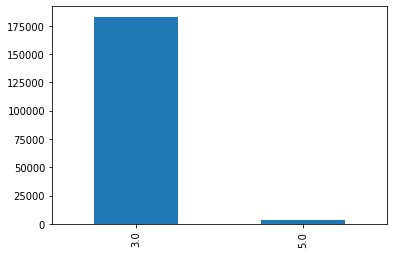

In [82]:
df_tennis['best_of'].value_counts().plot(kind='bar')

#### score
https://www.wikihow.it/Tenere-il-Punteggio-a-Tennis

If the **match** is at best of 3 then a player, to win, must win 2 sets. If instead it's at best of 5 the playes must win 3 sets.

Every sets is composed by **games**. The winner is the player that wins 6 games with at least 2 games od advantage (for example 6-4, 6-3, ..., but not 6-5).

In the case of 6-5 the first player wins the set is win the following game (7-5).

In case pf 6-6 the **Tie-Break** is played. The Tie-Break is won by the player that is the first to do 7 points with an advantage of 2 (so, for example, 7-5, 7-4, ...). If both the players do 6 points then wins the first that have 2 points of advantage on the adversary (for example 8-6, 9-7, 10-8, ...)

In [83]:
#check that all the scores of the match are valid. (we do not consider nulls)
df_tennis_score = df_tennis[~df_tennis['score'].isna()]

Walkover ("WO" or "w/o")- Unopposed victory. A walkover is awarded when the opponent fails to start the match for any reason, such as injury.

Retirement ("ret") - Player's withdrawal during a match, causing the player to forfeit the tournament. Usually this happens due to injury

Default :def - Disqualification of a player in a match by the chair umpire after the player has received four code violation warnings, generally for their conduct on court. A default can occur with less than four code violations warnings if the code violation is judged severe enough to warrant it. A double default occurs when both players are disqualified. Defaults also occur when a player misses a match with no valid excuse. Defaults are considered losses.

Bye :bye - Automatic advancement of a player to the next round of a tournament without facing an opponent. Byes are often awarded in the first round to the top-seeded players in a tournament

In [84]:
def Retirement(s):
    if s.lower() in "retirement." or s.lower()=="ret.":
        return True
    else:
        return False
    
def Walkover(s):
    if s.lower()=="w/o" or s.lower()=="wo" or s.lower() in "walkover":
        return True
    else:
        return False
    
def Default(s):
    if s.lower() in "default." or s.lower()=="def.":
        return True
    else:
        return False
    
def Bye(s):
    if s.lower() in "bye.":
        return True
    else:
        return False

Reasons for games not played

In [85]:
#error because less of 2 games without valid reasons
count_less_2 = 0
#error because we have too many games in a match
too_many = 0

#number of walkover
walkover = 0
#errors using RET instead of WO
wrong_walkover = 0
#number of defaults
default = 0
#number of byes
bye = 0

for match in df_tennis[~df_tennis['score'].isna()]['score']:
    sets = match.split( )
    if len(sets)==1 and Walkover(sets[0]):
        walkover+=1
        continue
    if len(sets)==1 and Retirement(sets[0]):
        wrong_walkover+=1
        continue
    if len(sets)==1 and Default(sets[0]):
        default+=1
        continue
    if len(sets)==1 and Bye(sets[0]):
        bye+=1
        continue
    if len(sets)<2:
        count_less_2+=1
        continue
    #maximum number of sets for best of 5 is 6: 5 games + RET or DEF
    if len(sets)>6:
        too_many+=1
        continue

In [86]:
print('walkover:', walkover)
print('wrong_walkover:', wrong_walkover)
print('default:', default)
print('bye:', bye)
print('errors: less than 2 games:', count_less_2)
print('errors: too many games:', too_many)

walkover: 879
wrong_walkover: 8
default: 7
bye: 7
errors: less than 2 games: 35
errors: too many games: 0


<BarContainer object of 5 artists>

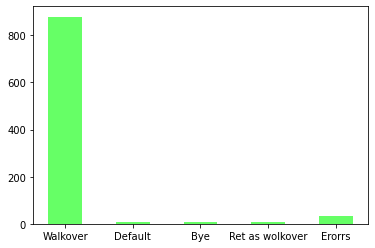

In [87]:
index = ["Walkover", "Default", "Bye", "Ret as wolkover", "Erorrs"]
values = [walkover, default, bye, wrong_walkover, count_less_2+too_many]
plt.bar(index,values, width=0.5, color="#66ff66")

So, these games are not played. There is a wrong use of retirement because a retirement before the game is called walkover. This is used in a wrong way 8 times.

In [88]:
def validity_match(games, best_of):
    
    if len(games) == 0:
        return False
    
    if len(games)>best_of+1:
        return False
    
    if len(games)<math.trunc(best_of/2)+1 or len(games)>best_of:
        if not Retirement(games[len(games)-1]) and not Default(games[len(games)-1]):
            return False
        elif len(games)==1:
             return True
    
    first_player = 0
    second_player = 0
    
    if Retirement(games[len(games)-1]) or Default(games[len(games)-1]):
        #analysis of set with a ret or def
        game = games[len(games)-2].replace("[", "").replace("]", "")
        points = game.split("-")
        
        if "(" in game or ")" in game:
            points = game[0:(game.index("("))].split("-")
            if "6" not in points or ("7" not in points and points.count('6')!=2):
                return False
        else:
            x = int(points[0])
            y = int(points[1])

            if not ((max(x,y) <= 6 and min(x,y)<=6) or (max(x,y) == 7 and min(x,y)==5)):
                return False
        
        complete_sets = len(games)-2
    else:
        complete_sets = len(games)
    
    i = 0
    #analysis of complete sets
    while i < complete_sets:
        
        game = games[i].replace("[", "").replace("]", "")

        if "(" in game or ")" in game:
            #tie-break
            points = game[0:(game.index("("))].split("-")
            if "6" not in points or "7" not in points:
                return False
            else:
                if points[0] == "6":
                    second_player+=1
                else:
                    first_player+=1
                i+=1
        else:
            #no tie-break
            game = games[i].replace("[", "").replace("]", "")
            points = game.split("-")

            x = int(points[0])
            y = int(points[1])

            if max(x,y) == 7 and min(x,y)!=5:
                return False
            elif max(x,y)!= 6 and (max(x,y) != 7 or min(x,y)!=5):
                return False
            elif max(x,y)==6 and (min(x,y)>4 or min(x,y)<0):
                return False
            else:
                #valid case
                if x == min(x,y):
                    second_player+=1
                else:
                    first_player+=1
                i+=1

    #if the a player wins cannot be other matches
    if (first_player==math.trunc(best_of/2)+1 or second_player==math.trunc(best_of/2)+1) and \
        (second_player + first_player)!=len(games):
        return False

    return True
    

In [89]:
def is_best_of_5(games):
    #not interesting case
    if len(games)!=3 and len(games)!=4:
        return False
    
    if Retirement(games[len(games)-1]) or Default(games[len(games)-1]):
        complete_sets = len(games)-2
    else:
        complete_sets = len(games)
    
    if complete_sets!=2 and complete_sets!=3:
        #not interesting case
        return False
    
    first_player = 0
    second_player = 0
    
    i = 0
    #analysis of complete sets
    while i < complete_sets:
        
        game = games[i].replace("[", "").replace("]", "")

        if "(" in game or ")" in game:
            #tie-break
            points = game[0:(game.index("("))].split("-")
        else:
            points = game.split("-")

        if int(points[0]) > int(points[1]):
            first_player+=1
        else:
            second_player+=1
        i+=1
            
    if first_player==0 or second_player==0:
        return True
            
    return False
    

In [90]:
def is_best_of_3(games):
    
    #not interesting case
    if len(games)!=2 and len(games)!=3:
        return False
    
    if Retirement(games[len(games)-1]) or Default(games[len(games)-1]):
        return False
    
    first_player = 0
    second_player = 0
    
    i = 0
    #analysis of complete sets
    while i < len(games):
        
        game = games[i].replace("[", "").replace("]", "")

        if "(" in game or ")" in game:
            #tie-break
            points = game[0:(game.index("("))].split("-")
        else:
            points = game.split("-")

        if int(points[0]) > int(points[1]):
            first_player+=1
        else:
            second_player+=1
        i+=1
            
    if len(games)==2 and (first_player==0 or second_player==0):
        return True
    elif len(games)==3 and first_player!=0 and second_player!=0:
        return True
            
    return False

In [91]:
#best of 5: 3,4 o 5 games, best of 3: 2 or 3 games (with points)
best_5 = 0
best_3 = 0

valid_change_best_of = 0
invalid_matches = 0


#check of the best of 3
for match in df_tennis_score[df_tennis_score['best_of']==3]['score']:
    sets = match.split( )
    #maximum number of sets for best of 3 is 4: 3 games + RET or DEF
    if len(sets)>4 or (len(sets)==4 and not Retirement(sets[3]) and not Default(sets[3])):
        best_5+=1
        #print(sets)
        if validity_match(sets, 5) == True:
            valid_change_best_of +=1
        else:
            invalid_matches+=1
    elif len(sets)>=2:
        if validity_match(sets, 3) == False:
            invalid_matches+=1
        
        
#check of the best of 5
for match in df_tennis_score[df_tennis_score['best_of']==5]['score']:
    sets = match.split( )
    if len(sets)==2 and not Retirement(sets[1]) and not Default(sets[1]):
        best_3+=1
        if validity_match(sets, 3) == True:
            valid_change_best_of +=1
        else:
            invalid_matches+=1
    elif len(sets)>=2:
         if validity_match(sets, 5) == False:
            invalid_matches+=1

    

In [92]:
print('errors: best of 5 classyfied as best of 3:', best_5)
print('errors: best of 3 classyfied as best of 5:', best_3)
print('valid change of best of', valid_change_best_of)
print('Invalid matches', invalid_matches)

errors: best of 5 classyfied as best of 3: 57
errors: best of 3 classyfied as best of 5: 2
valid change of best of 45
Invalid matches 5122


<BarContainer object of 2 artists>

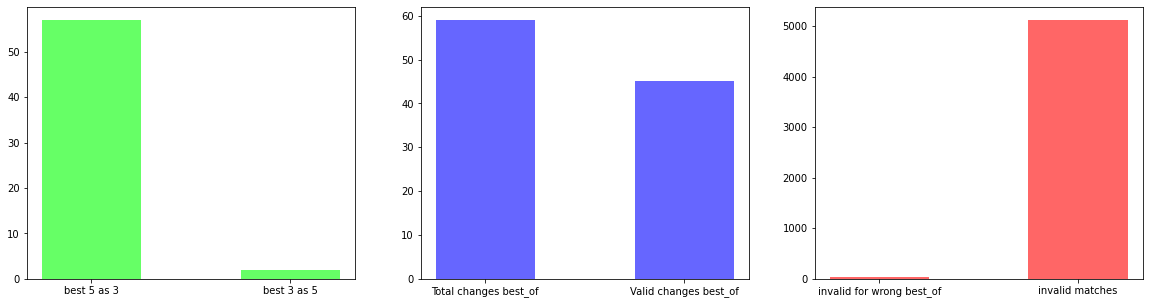

In [93]:
fig = plt.figure(figsize=(20, 5)) 
fig_dims = (1, 3)

plt.subplot2grid(fig_dims, (0, 0))
plt.bar(["best 5 as 3", "best 3 as 5"], [best_5, best_3], width=0.5, color="#66ff66")

plt.subplot2grid(fig_dims, (0, 1))
plt.bar(["Total changes best_of", "Valid changes best_of"], [best_5+best_3, valid_change_best_of], width=0.5, color="#6666ff")

plt.subplot2grid(fig_dims, (0, 2))
plt.bar(["invalid for wrong best_of", "invalid matches"], [valid_change_best_of, invalid_matches], width=0.5, color="#ff6666")

There are some invalid points about some games of some matches. There are some matches classifyed as best of 3 but have more than 3 games and they can be classified as best of 5. The same for the best of 5. There are some matches that are not valid (5122) because the results of the games are inpossible results because the rules of the tennis. 

We can see in the first bar chart that most of the error of classification are about matches best of 5 classified as best of 3. In the second chart we can notice that we can correct this classification for most of these matches. 

In the 3rd chart we can see that the error we have notice in the match because of a wrong classification are a very small part of the total errors. So, the most of the errors in the scores are not because the classification is wrong, but because the saved results are invalid.

In [94]:
count_5=0
for index, row in  df_tennis_score[df_tennis_score['best_of']==3].iterrows():
    sets = row['score'].split( )
    if validity_match(sets,5) and is_best_of_5(sets):
        count_5+=1

In [95]:
count_3=0
for index, row in  df_tennis_score[df_tennis_score['best_of']==5].iterrows():
    sets = row['score'].split( )
    if validity_match(sets,3) and is_best_of_3(sets):
        count_3+=1

In [96]:
print('best of 5 classyfied as best of 3 looking scores:', count_5)
print('best of 3 classyfied as best of 5 looking scores:', count_3)

best of 5 classyfied as best of 3 looking scores: 97
best of 3 classyfied as best of 5 looking scores: 1


#### match_num

In [97]:
df_tennis_matchgroups = df_tennis.drop_duplicates().groupby(['tourney_id', 'match_num']).size().reset_index(name='size')
print(df_tennis_matchgroups[df_tennis_matchgroups['size']>2])
#number of match with more than one winner
df_tennis_matchgroups[df_tennis_matchgroups['size']>2].shape[0]

       tourney_id  match_num  size
7641     2016-520      100.0     3
7642     2016-520      101.0     3
7643     2016-520      102.0     3
7644     2016-520      103.0     3
7645     2016-520      104.0     3
...           ...        ...   ...
145032   2021-540      207.0     4
145033   2021-540      208.0     4
145034   2021-540      209.0     4
145035   2021-540      210.0     4
145036   2021-540      211.0     4

[1764 rows x 3 columns]


1764

In [98]:
df_tennis[(df_tennis['tourney_id']=='2016-520') & (df_tennis['match_num']==100)][['tourney_id', 'tourney_name', 'match_num', 'winner_name', 'loser_name','tourney_level']]

,tourney_id,tourney_name,match_num,winner_name,loser_name,tourney_level
55289,2016-520,Roland Garros,100.0,Louisa Chirico,Tereza Martincova,G
55485,2016-520,Roland Garros,100.0,Serena Williams,Magdalena Rybarikova,G
55612,2016-520,Roland Garros,100.0,Novak Djokovic,Yen Hsun Lu,G


#### draw_size

In [99]:
#count the row with an invalid number (negative or less than 2)
df_tennis[df_tennis['draw_size'] < 2].shape[0]

0

All the numbers are valid (we consider only the numbers and not the nulls)

**tourney_date**

In [100]:
#the date are in float so they need to be converted in date object 
df_tennis['tourney_date'].isnull().sum()

28

In [101]:
#check if there are present data greater then today
import datetime
df_tennis['tourney_date'] = pd.to_datetime(df_tennis['tourney_date'], format='%Y%m%d')
invalid_data = 0
today = pd.to_datetime(datetime.date.today())
for date in df_tennis['tourney_date']:
    if date > today:
        invalid_data +=1
print(invalid_data)

0


There aren't invalid dates

#### winner_ht and loser_ht

In [102]:
df_tennis['winner_ht'].max()

211.0

In [103]:
df_tennis['winner_ht'].min()

2.0

In [104]:
# print all possibile winner ht in an asc sort order
df_tennis['winner_ht'].value_counts().sort_index()

2.0        81
145.0       9
155.0     144
157.0     143
159.0     139
160.0       7
161.0     114
162.0     232
163.0     474
164.0     271
165.0     298
166.0     493
167.0     282
168.0     981
169.0     221
170.0    3025
171.0     375
172.0    1111
173.0    1340
174.0     987
175.0    2264
176.0     598
177.0    1100
178.0    2442
179.0     370
180.0    4876
181.0     599
182.0    1223
183.0    5202
184.0     572
185.0    5153
188.0    4826
189.0     112
190.0    1955
191.0     355
193.0    3009
194.0      88
196.0    1714
198.0    1420
203.0     328
206.0     166
208.0     101
211.0     141
Name: winner_ht, dtype: int64

<AxesSubplot:title={'center':'winner_ht distribution'}, xlabel='winner_ht', ylabel='Frequency'>

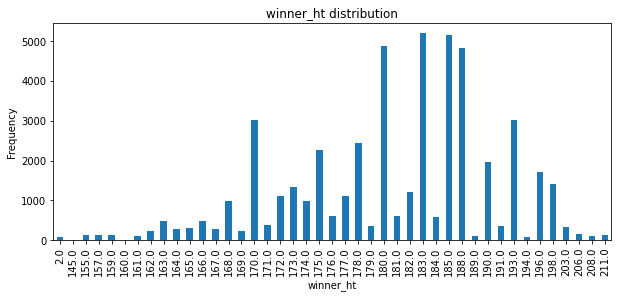

In [105]:
df_tennis['winner_ht'].value_counts().sort_index().plot.bar(
    figsize=(10, 4), 
    title="winner_ht distribution",
    xlabel="winner_ht", 
    ylabel="Frequency")

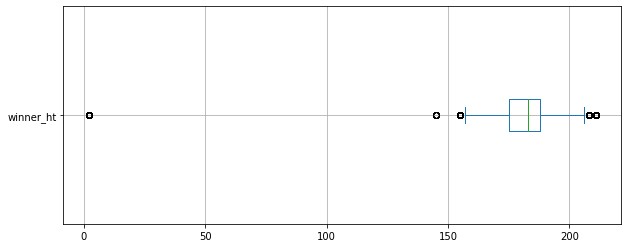

In [106]:
# let's try to find outliers with boxplot visualization
df_tennis.plot.box(y="winner_ht", vert=False, grid=True, figsize=(10, 4));

In [107]:
df_tennis['loser_ht'].max()

211.0

In [108]:
df_tennis['loser_ht'].min()

2.0

In [109]:
# print all possibile loser ht in an asc sort order
df_tennis['winner_ht'].value_counts().sort_index()

2.0        81
145.0       9
155.0     144
157.0     143
159.0     139
160.0       7
161.0     114
162.0     232
163.0     474
164.0     271
165.0     298
166.0     493
167.0     282
168.0     981
169.0     221
170.0    3025
171.0     375
172.0    1111
173.0    1340
174.0     987
175.0    2264
176.0     598
177.0    1100
178.0    2442
179.0     370
180.0    4876
181.0     599
182.0    1223
183.0    5202
184.0     572
185.0    5153
188.0    4826
189.0     112
190.0    1955
191.0     355
193.0    3009
194.0      88
196.0    1714
198.0    1420
203.0     328
206.0     166
208.0     101
211.0     141
Name: winner_ht, dtype: int64

<AxesSubplot:title={'center':'loser_ht distribution'}, xlabel='loser_ht', ylabel='Frequency'>

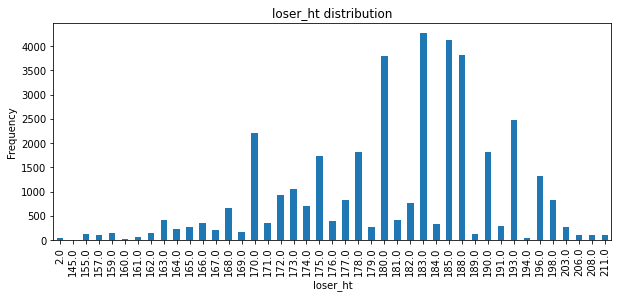

In [110]:
df_tennis['loser_ht'].value_counts().sort_index().plot.bar(
    figsize=(10, 4), 
    title="loser_ht distribution",
    xlabel="loser_ht", 
    ylabel="Frequency")

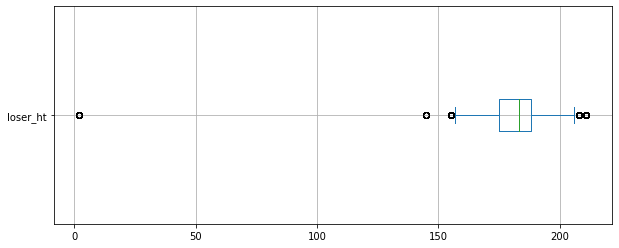

In [111]:
# let's try to find outliers with boxplot visualization
df_tennis.plot.box(y="loser_ht", vert=False, grid=True, figsize=(10, 4));

In [112]:
## Print decimal age in a string years,month,days format
def ConvertAge(decimal_years):
    decimal_days = decimal_years * 365
    year = decimal_days//365
    tmp_days = decimal_days - (year*365)
    month = tmp_days//31
    days = tmp_days - (month * 31)
    return str(int(year)) + " years, " + str(int(month)) + " months, " + str(int(days)) + " days"

#### Check if the players have different heights, i.e. if they have grown over time

In [113]:
# get all players ids from winner and looser, without duplicate
players_ids = list(set(df_tennis['winner_id'].dropna().unique().tolist()) | set(df_tennis['loser_id'].dropna().unique().tolist()))

count = 0

results = []

# find players with different ht
for player_id in players_ids:
    w_ht_players = df_tennis[df_tennis['winner_id']==player_id]['winner_ht'].dropna().unique().tolist()
    l_ht_players = df_tennis[df_tennis['loser_id']==player_id]['loser_ht'].dropna().unique().tolist()
    ht_players = list(set(w_ht_players) | set(l_ht_players))
    diff = len(ht_players)
    if diff > 1:
        results.append(player_id)
        count = count + 1

# print results        
print("find " + str(count) + " players with different height, ids: " + str(results))        
print("")
for player_id in results:
    w_ht_players = df_tennis[df_tennis['winner_id']==player_id]
    l_ht_players = df_tennis[df_tennis['loser_id']==player_id]    
    result = pd.concat([w_ht_players, l_ht_players])
    result.sort_values(by=['tourney_date'], inplace=True)
            
    printhead = True
    last_ht = 0
    for index, row in result.iterrows():             
        if printhead:
            if row["winner_id"] == player_id:
                name = row["winner_name"]
            else:
                name = row["loser_name"]
            print(" --------------- PLAYER " + str(player_id) + " " + name + " --------------- ")
            printhead = False
        age = None
        match_id = row["tourney_id"]
        match_name = row["tourney_name"]
        if row["winner_id"] == player_id:
            ht = row["winner_ht"]
            age = ConvertAge(row['winner_age'])
        else:
            ht = row["loser_ht"]
            age = ConvertAge(row['loser_age'])        
        
        if last_ht != ht:
            print(str(match_id)  + "\t-\t" + match_name  + "\t-\t" + str(ht)  + " - " + str(row["tourney_date"])  + " - " + age)
            last_ht = ht        
    print(" -----------------------------------------------------  ")   

find 1 players with different height, ids: [105676.0]

 --------------- PLAYER 105676.0 David Goffin --------------- 
2016-M020	-	Brisbane	-	163.0 - 2016-01-04 00:00:00 - 25 years, 0 months, 27 days
2018-580	-	Australian Open	-	180.0 - 2018-01-15 00:00:00 - 27 years, 1 months, 8 days
 -----------------------------------------------------  


#### winner_age and loser_age


In [114]:
print(str(df_tennis['winner_age'].max()) + " converted-> " + ConvertAge(df_tennis['winner_age'].max()))

95.0 converted-> 95 years, 0 months, 0 days


In [115]:
print(str(df_tennis['winner_age'].min()) + " converted-> " + ConvertAge(df_tennis['winner_age'].min()))

14.0424366872 converted-> 14 years, 0 months, 15 days


<AxesSubplot:>

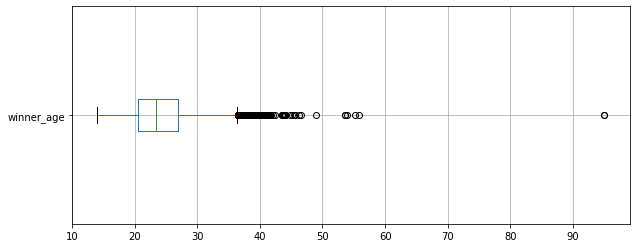

In [116]:
# let's try to find outliers in age with boxplot visualization
df_tennis.boxplot(vert=False, column=['winner_age'], return_type='axes',figsize=(10, 4))

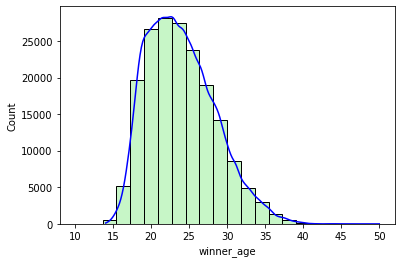

In [117]:
sns.histplot(data=df_tennis['winner_age'], bins="sturges", binrange=(10,50), color="lightgreen", kde=True, kde_kws={'clip':(10,50)}).lines[0].set_color('blue')

In [118]:
#loser age

In [119]:
print(str(df_tennis['loser_age'].max()) + " -> " + ConvertAge(df_tennis['loser_age'].max()))
print(str(df_tennis['loser_age'].min()) + " -> " + ConvertAge(df_tennis['loser_age'].min()))

74.4859685147 -> 74 years, 5 months, 22 days
14.006844627 -> 14 years, 0 months, 2 days


In [120]:
# prints a table sorted by winner age, with tournament, winner name and tournament date
df_tennis_tmp = df_tennis.copy() # avoid overwrite original dataset
df_tennis_tmp['loser_age'] = df_tennis_tmp['loser_age'].dropna().apply(lambda x: ConvertAge(x))
df_tennis_tmp['tourney_date'] = pd.to_datetime(df_tennis_tmp['tourney_date'], format='%Y%m%d')
df_tennis_tmp[['tourney_name', 'tourney_date', 'loser_name', 'loser_age']].dropna().sort_values(by='loser_age')

,tourney_name,tourney_date,loser_name,loser_age
128331,Sandelfjord $15K,2018-07-23,Katja Wiersholm,"14 years, 0 months, 14 days"
150371,W15 Cancun,2019-04-15,Isabella Kruger,"14 years, 0 months, 15 days"
122036,Manacor Mallorca $15K,2018-02-05,Gloria Alogo Piqueras,"14 years, 0 months, 16 days"
39655,Tampere $10K,2016-07-18,Emilia Salo,"14 years, 0 months, 2 days"
18856,Heraklion $15K,2017-04-03,Sapfo Sakellaridi,"14 years, 0 months, 2 days"
...,...,...,...,...
137039,W60 Saguenay,2019-10-21,Sylvia Schenck,"55 years, 8 months, 19 days"
162479,W15 Guatemala,2019-11-04,Sylvia Schenck,"55 years, 9 months, 2 days"
176953,W25 Evansville IN,2021-07-12,Sylvia Schenck,"57 years, 5 months, 11 days"
176662,W25 Naples FL,2021-05-03,Gail Falkenberg,"74 years, 3 months, 14 days"


<AxesSubplot:>

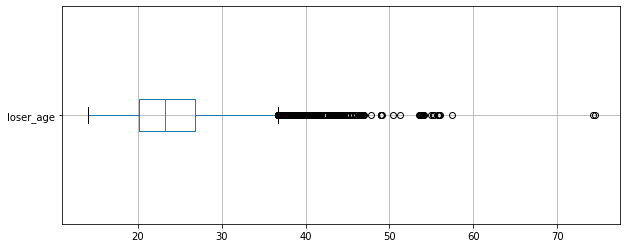

In [121]:
df_tennis.boxplot(vert=False, column=['loser_age'], return_type='axes',figsize=(10, 4))

<AxesSubplot:xlabel='loser_age', ylabel='Density'>

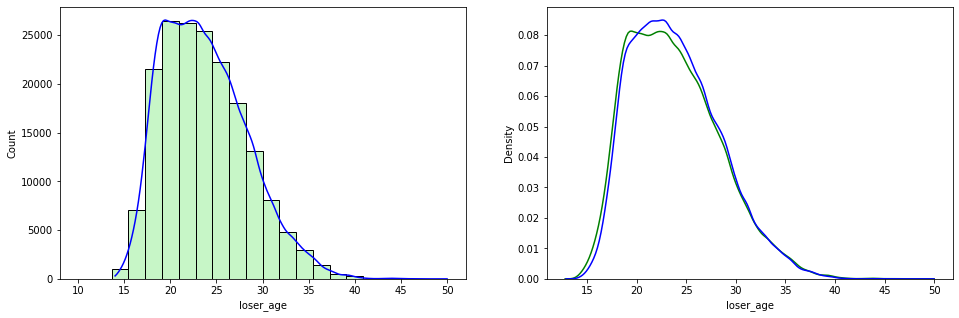

In [122]:
#df_tennis['winner_age'].hist(bins=50, grid=False, range=(10, 50))
#df_tennis['winner_age'].plot(kind='kde', xlim=[10,50])

fig = plt.figure(figsize=(16, 5)) 
fig_dims = (1, 2)

plt.subplot2grid(fig_dims, (0, 0))
sns.histplot(data=df_tennis['loser_age'], bins="sturges", binrange=(10,50), color="lightgreen", kde=True, kde_kws={'clip':(10,50)}).lines[0].set_color('blue')

plt.subplot2grid(fig_dims, (0, 1))
sns.kdeplot(data=df_tennis['loser_age'], color="green", clip=(10,50))
sns.kdeplot(data=df_tennis['winner_age'], color="blue", clip=(10,50))

In [123]:
def ConvertTime(time):
    hours = int((time // 60))
    minutes = int((time % 60))
    print(time % 1)
    seconds = int((time % 1) * 60)
    return ("%dH:%02dm:%02ds" % (hours, minutes, seconds))
ConvertTime(59.4)

0.3999999999999986


'0H:59m:23s'

#### minutes

In [124]:
df_tennis.loc[df_tennis['minutes'] < 0, 'minutes'].count()

0

In [125]:
df_tennis.loc[df_tennis['minutes'] == 0, 'minutes'].count()

128

In [126]:
df_tennis['minutes'].max()

4756.0

In [127]:
df_tennis[df_tennis['best_of']==3]['minutes'].mean()

95.47164258962012

On average, best-of-3 tennis matches last about 90 minutes, while best-of-5 matches last 2 hours and 45 minutes (=165 minutes)

In [128]:
print(str(df_tennis['minutes'].mean()) + " converted-> " + ConvertTime(df_tennis['minutes'].mean()))

0.6757531227038953
97.6757531227039 converted-> 1H:37m:40s


In [129]:
print(str(df_tennis['minutes'].max()) + " converted-> " + ConvertTime(df_tennis['minutes'].max()))

0.0
4756.0 converted-> 79H:16m:00s


In [130]:
print(str(df_tennis['minutes'].min()) + " converted-> " + ConvertTime(df_tennis['minutes'].min()))

0.0
0.0 converted-> 0H:00m:00s


<AxesSubplot:>

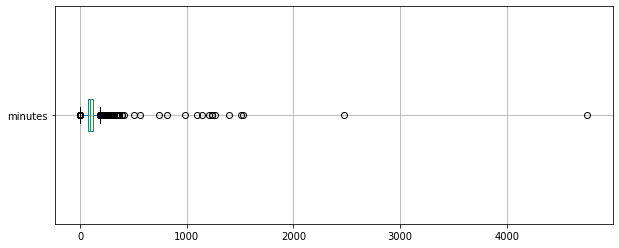

In [131]:
# let's try to find outliers in minutes with scatter visualization
df_tennis.boxplot(vert=False, column=['minutes'], return_type='axes',figsize=(10, 4))

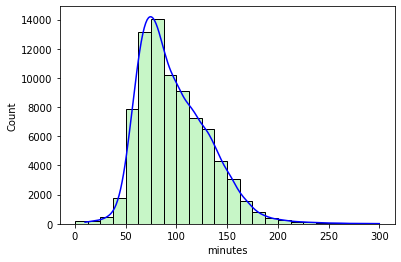

In [132]:
sns.histplot(data=df_tennis['minutes'], bins="doane", binrange=(0,300), color="lightgreen", kde=True, kde_kws={'clip':(10,300)}).lines[0].set_color('blue')

In [133]:
df_tennis[df_tennis['minutes']> 665].shape[0]

14

Longest tennis games in history worldwide is 11 hours and 5 minutes (= 665 minutes) for best of 5 and 6 hours and 31 mintes for best of 3

There are 128 entry with a match duration equal to 0, a tennis match duration is on average 40 minutes our mean is 97.67.

In [134]:
# we check that matches with 0 minutes are matches with BYE and WOLKOVER (in this case the match is not played)
def IsMatchWithZeroIncorrect(match):
    tmp = str(match)
    sets = tmp.split()    
    if len(sets)==1 and Walkover(sets[0]):
        return False
    if len(sets)==1 and Bye(sets[0]):
        return False
    if len(sets)==1 and Retirement(sets[0]):
        return False
    if len(sets)==1 and Default(sets[0]):
        return False
    return True

df_tennis_min_filtered = df_tennis[df_tennis['minutes']<= 0]
df_tennis_min_checked = df_tennis_min_filtered.apply(lambda x: IsMatchWithZeroIncorrect(x['score']), axis=1)
df_tennis_min_zero_res = df_tennis_min_filtered[df_tennis_min_checked]
df_tennis_min_zero_res[['tourney_id', 'score', 'minutes']]

,tourney_id,score,minutes
248,2019-M001,3-6 6-3 6-4,0.0
5008,2019-560,NaN,0.0
7879,2018-M007,6-3 6-2,0.0
29782,2017-0804,7-5 6-1,0.0
33939,2017-M007,0-0 RET,0.0
98553,2021-2030,6-2 6-2,0.0
104107,2019-7085,7-5 2-0 RET,0.0


0 could be considered as a default value

#### w_ace, w_df and w_svpt

In [135]:
negative_w_ace = df_tennis.loc[df_tennis['w_ace'] < 0].shape[0]
print(negative_w_ace)

0


In [136]:
#check if there are more ace than service performed
df_tennis.loc[df_tennis['w_svpt'] < df_tennis['w_ace']].shape[0]

0

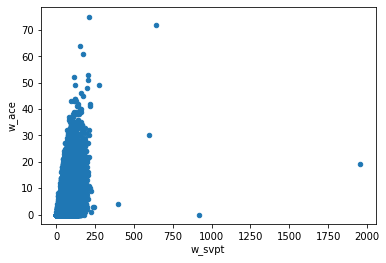

In [137]:
df_tennis.plot.scatter('w_svpt', 'w_ace')
plt.show()

In [138]:
#W_df: winner's number of doubles faults
negative_w_df = df_tennis.loc[df_tennis['w_df'] < 0].shape[0]
print(negative_w_df)

0


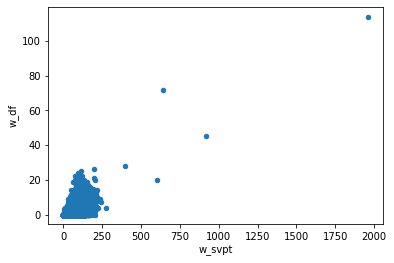

In [139]:
df_tennis.plot.scatter('w_svpt', 'w_df')
plt.show()

In [140]:
#check if there are more double faults than service performed
df_tennis.loc[df_tennis['w_svpt'] < df_tennis['w_df']].shape[0]

0

In [141]:
#W_svpt: winner's number of serve points
negative_w_ace = df_tennis.loc[df_tennis['w_svpt'] < 0].shape[0]
print(negative_w_ace)

0


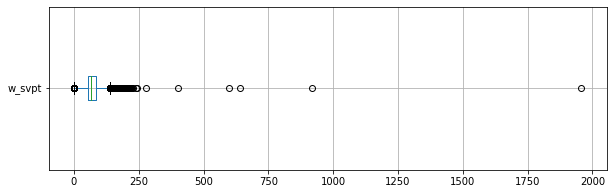

In [142]:
#check for outliers for w_svpt
df_tennis.boxplot(vert=False, column=['w_svpt'], return_type='axes',figsize=(10, 3))
plt.show()

There are outiliers in the service point, values that goes over twenty-five hundred.
*It can be theoretically possible.*

In [143]:
df_tennis.loc[df_tennis['w_svpt'] >300][['tourney_id', 'tourney_name', 'best_of', 'score','winner_name','w_svpt','w_ace','loser_name','l_svpt', 'l_ace']]

,tourney_id,tourney_name,best_of,score,winner_name,w_svpt,w_ace,loser_name,l_svpt,l_ace
99364,2021-1038,Madrid,3.0,1-6 7-6(6) 6-0,Su Wei Hsieh,1957.0,19.0,Jaqueline Adina Cristian,1672.0,19.0
99384,2021-709,Rome,3.0,7-5 6-4,Petra Martic,600.0,30.0,Jessica Pegula,810.0,20.0
99567,2021-406,Strasbourg,3.0,6-4 7-6(6),Jule Niemeier,640.0,72.0,Shelby Rogers,624.0,40.0
99631,2021-1080,Nottingham,3.0,3-6 7-5 7-6(3),Alison Riske,400.0,4.0,Xiyu Wang,464.0,16.0
99994,2021-2037,Gdynia,3.0,5-7 7-5 6-1,Kateryna Kozlova,918.0,0.0,Katarzyna Kawa,972.0,0.0


#### l_ace, l_df and l_svpt

In [144]:
negative_l_ace = df_tennis.loc[df_tennis['l_ace'] < 0].shape[0]
print(negative_l_ace)

0


In [145]:
#check if there are more ace than service performed
df_tennis.loc[df_tennis['l_svpt'] < df_tennis['l_ace']].shape[0]

0

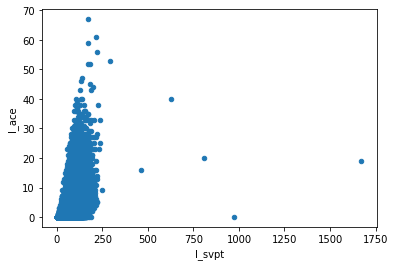

In [146]:
df_tennis.plot.scatter('l_svpt', 'l_ace')
plt.show()

In [147]:
#W_df: winner's number of doubles faults
negative_l_df = df_tennis.loc[df_tennis['l_df'] < 0].shape[0]
print(negative_l_df)

0


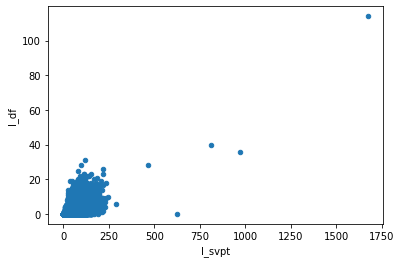

In [148]:
df_tennis.plot.scatter('l_svpt', 'l_df')
plt.show()

In [149]:
#check if there are more double faults than service performed
df_tennis.loc[df_tennis['l_svpt'] < df_tennis['l_df']].shape[0]

0

In [150]:
#W_svpt: winner's number of serve points
negative_l_ace = df_tennis.loc[df_tennis['l_svpt'] < 0].shape[0]
print(negative_l_ace)

0


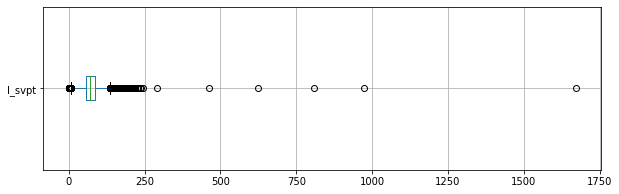

In [151]:
#check for outliers for w_svpt
df_tennis.boxplot(vert=False, column=['l_svpt'], return_type='axes',figsize=(10, 3))
plt.show()

#### w_1stIn

In [152]:
#check to find negative values
df_tennis.loc[df_tennis['w_1stIn'] < 0].shape[0]

0

#### l_1stIn

In [153]:
#check on loser’s number of first serves made to find negative values
df_tennis.loc[df_tennis['l_1stIn'] < 0].shape[0]

0

#### w_1stWon and w_2ndWon

In [154]:
#check to find negative values
df_tennis.loc[df_tennis['w_1stWon'] < 0].shape[0]

0

In [155]:
#check if there are more w_1stWon than fist service performed
df_tennis.loc[df_tennis['w_1stIn'] < df_tennis['w_1stWon']].shape[0]

0

In [156]:
#check to find negative values
df_tennis.loc[df_tennis['w_2ndWon'] < 0].shape[0]

0

In [157]:
#check that the number of serve point is not smaller than the number of first serves 
df_tennis[df_tennis['w_svpt'] < df_tennis['w_1stIn']].shape[0]

0

In [158]:
#check that the number of serve point is not smaller than won serve points (first and second serve)
df_tennis[df_tennis['w_svpt'] < df_tennis['w_1stWon']+df_tennis['w_2ndWon']].shape[0]

0

#### l_1stWon and l_2ndWon


In [159]:
df_tennis.loc[df_tennis['l_1stWon'] < 0].shape[0]

0

In [160]:
df_tennis.loc[df_tennis['l_1stIn'] < df_tennis['l_1stWon']].shape[0]

0

In [161]:
df_tennis.loc[df_tennis['l_2ndWon'] < 0].shape[0]

0

In [162]:
df_tennis[df_tennis['l_svpt'] < df_tennis['l_1stIn']].shape[0]

0

In [163]:
df_tennis[df_tennis['l_svpt'] < df_tennis['l_1stWon']+df_tennis['l_2ndWon']].shape[0]

0

#### w_SvGms,  w_bpSaved and w_bpFaced

In [164]:
#Checks on w_SvGms
df_tennis.loc[df_tennis['w_SvGms'] < 0].shape[0]

0

In [165]:
import re
#w_SvGms: winner’s number of serve games
re_score1 = "\d[\d-][^()]"
re_score2 = "\d"
df_cleaned = df_tennis[~(df_tennis['score'].isnull()) & ~(df_tennis['w_SvGms'].isnull())]
scores = df_cleaned['score'].tolist()
invalid_SvGms = []
for i, score in enumerate(df_tennis['score'].tolist()):
    if ((df_tennis.at[i,'score'] == 'nan') | (str(df_tennis.at[i,'w_SvGms']) == 'nan')):
        continue
#     if (Retirement(score) | Walkover(score) | Default(score) | Bye(score)):
#         continue
    int_scores = re.findall(re_score1, str(score))
    int_scores = re.findall(re_score2, str(int_scores))
    if(len(int_scores) > 6):
        continue
    score_sum = np.sum(list(map(lambda x: int(x), int_scores)))
    if (((np.floor(score_sum/2) - 2) <= df_tennis.at[i,'w_SvGms']) or 
        ((np.ceil(score_sum/2) + 2) >= df_tennis.at[i,'w_SvGms'])):
        continue
    invalid_SvGms.append(i)
#     print('+++ SCORE INVALIDO +++')
#     print("SCORE -> " + str(df_tennis.at[i,'score']))
#     print("GAME SERVITI -> " + str(df_tennis.at[i,'w_SvGms']))
#     print(np.floor(score_sum/2))
#     print(np.ceil(score_sum/2))
#     print('+++++++')
print(invalid_SvGms)

[]


In [166]:
df_tennis['w_bpSaved'].min() < 0

False

In [167]:
df_tennis['w_bpFaced'].min() < 0

False

In [168]:
#check that number of faces is never bigger than number of saved
df_tennis[df_tennis['w_bpSaved']>df_tennis['w_bpFaced']].shape[0]

0

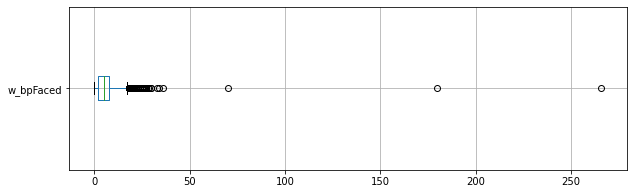

In [169]:
#check for outliers for w_bpFaced
df_tennis.boxplot(vert=False, column=['w_bpFaced'], return_type='axes',figsize=(10, 3))
plt.show()

In [170]:
df_tennis[df_tennis['w_bpFaced']>75][['tourney_id', 'tourney_name', 'best_of', 'score','winner_name','w_bpFaced','loser_name','w_bpFaced']]

,tourney_id,tourney_name,best_of,score,winner_name,w_bpFaced,loser_name,w_bpFaced
99364,2021-1038,Madrid,3.0,1-6 7-6(6) 6-0,Su Wei Hsieh,266.0,Jaqueline Adina Cristian,266.0
99994,2021-2037,Gdynia,3.0,5-7 7-5 6-1,Kateryna Kozlova,180.0,Katarzyna Kawa,180.0


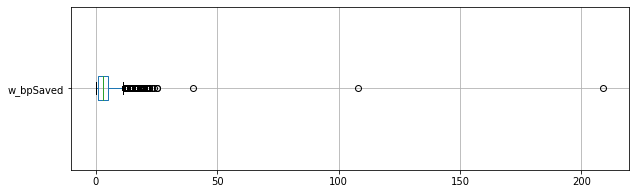

In [171]:
#check for outliers for w_bpSaved
df_tennis.boxplot(vert=False, column=['w_bpSaved'], return_type='axes',figsize=(10, 3))
plt.show()

In [172]:
df_tennis[df_tennis['w_bpSaved']>75][['tourney_id', 'tourney_name', 'best_of', 'score','winner_name','w_bpFaced','w_bpSaved','loser_name','l_bpFaced','l_bpSaved']]

,tourney_id,tourney_name,best_of,score,winner_name,w_bpFaced,w_bpSaved,loser_name,l_bpFaced,l_bpSaved
99364,2021-1038,Madrid,3.0,1-6 7-6(6) 6-0,Su Wei Hsieh,266.0,209.0,Jaqueline Adina Cristian,190.0,114.0
99994,2021-2037,Gdynia,3.0,5-7 7-5 6-1,Kateryna Kozlova,180.0,108.0,Katarzyna Kawa,180.0,81.0


#### l_SvGms,  l_bpSaved and l_bpFaced

In [173]:
df_tennis.loc[df_tennis['l_SvGms'] < 0].shape[0]

0

In [174]:
#l_SvGms: loser’s number of serve games
re_score1 = "\d[\d-][^()]"
re_score2 = "\d"
df_cleaned = df_tennis[~(df_tennis['score'].isnull()) & ~(df_tennis['l_SvGms'].isnull())]
scores = df_cleaned['score'].tolist()
invalid_SvGms = []
for i, score in enumerate(df_tennis['score'].tolist()):
    if ((df_tennis.at[i,'score'] == 'nan') | (str(df_tennis.at[i,'l_SvGms']) == 'nan')):
        continue
#     if (Retirement(score) | Walkover(score) | Default(score) | Bye(score)):
#         continue
    int_scores = re.findall(re_score1, str(score))
    int_scores = re.findall(re_score2, str(int_scores))
    if(len(int_scores) > 6):
        continue
    score_sum = np.sum(list(map(lambda x: int(x), int_scores)))
    if (((np.floor(score_sum/2) - 2) <= df_tennis.at[i,'l_SvGms']) or 
        ((np.ceil(score_sum/2) + 2) >= df_tennis.at[i,'l_SvGms'])):
        continue
    invalid_SvGms.append(i)
#     print('+++ SCORE INVALIDO +++')
#     print("SCORE -> " + str(df_tennis.at[i,'score']))
#     print("GAME SERVITI -> " + str(df_tennis.at[i,'w_SvGms']))
#     print(np.floor(score_sum/2))
#     print(np.ceil(score_sum/2))
#     print('+++++++')
print(invalid_SvGms)

[]


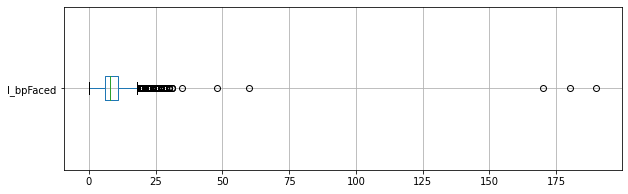

In [175]:
#check for outliers for w_bpFaced
df_tennis.boxplot(vert=False, column=['l_bpFaced'], return_type='axes',figsize=(10, 3))
plt.show()

In [176]:
df_tennis[df_tennis['l_bpFaced']>75][['tourney_id', 'tourney_name', 'best_of', 'score','winner_name','w_bpFaced','loser_name','l_bpFaced']]

,tourney_id,tourney_name,best_of,score,winner_name,w_bpFaced,loser_name,l_bpFaced
99364,2021-1038,Madrid,3.0,1-6 7-6(6) 6-0,Su Wei Hsieh,266.0,Jaqueline Adina Cristian,190.0
99384,2021-709,Rome,3.0,7-5 6-4,Petra Martic,70.0,Jessica Pegula,170.0
99994,2021-2037,Gdynia,3.0,5-7 7-5 6-1,Kateryna Kozlova,180.0,Katarzyna Kawa,180.0


In [177]:
df_tennis['l_bpSaved'].min() < 0

False

In [178]:
df_tennis['l_bpFaced'].min() < 0

False

In [179]:
#check that number of faces is never bigger than number of saved
df_tennis[df_tennis['l_bpSaved']>df_tennis['l_bpFaced']].shape[0]

0

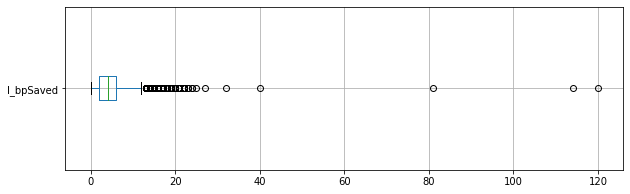

In [180]:
#check for outliers for l_bpSaved
df_tennis.boxplot(vert=False, column=['l_bpSaved'], return_type='axes',figsize=(10, 3))
plt.show()

In [181]:
df_tennis[df_tennis['l_bpSaved']>75][['tourney_id', 'tourney_name', 'best_of', 'score','winner_name','w_bpFaced','w_bpSaved','loser_name','l_bpFaced','l_bpSaved']]

,tourney_id,tourney_name,best_of,score,winner_name,w_bpFaced,w_bpSaved,loser_name,l_bpFaced,l_bpSaved
99364,2021-1038,Madrid,3.0,1-6 7-6(6) 6-0,Su Wei Hsieh,266.0,209.0,Jaqueline Adina Cristian,190.0,114.0
99384,2021-709,Rome,3.0,7-5 6-4,Petra Martic,70.0,40.0,Jessica Pegula,170.0,120.0
99994,2021-2037,Gdynia,3.0,5-7 7-5 6-1,Kateryna Kozlova,180.0,108.0,Katarzyna Kawa,180.0,81.0


#### Winner_rank and loser_rank

In [182]:
df_tennis['winner_rank'].max()

2220.0

In [183]:
df_tennis['winner_rank'].min() >= 1 #there cannot be rank smaller than 1

True

In [184]:
df_tennis['winner_rank'].min()

1.0

In [185]:
df_tennis['loser_rank'].max()

2257.0

In [186]:
df_tennis['loser_rank'].min() >= 1 #there cannot be rank smaller than 1

True

In [187]:
df_tennis['loser_rank'].min()

1.0

#### Winner_rank_points and loser_rank_points

In [188]:
df_tennis['winner_rank_points'].max()<21750 #21750 is the maximum a player can reach

True

In [189]:
df_tennis['winner_rank_points'].max()

16950.0

In [190]:
df_tennis['winner_rank_points'].min()

1.0

In [191]:
df_tennis[df_tennis['winner_rank_points'] == df_tennis['winner_rank_points'].min()].shape[0] 

209

In [192]:
df_tennis['loser_rank_points'].max()<21750 #21750 is the maximum a player can reach

True

In [193]:
df_tennis['loser_rank_points'].max()

16950.0

In [194]:
df_tennis['loser_rank_points'].min()

1.0

In [195]:
df_tennis[df_tennis['loser_rank_points'] == df_tennis['loser_rank_points'].min()].shape[0] 

729

**tourney_spectators**

In [196]:
df_tennis['tourney_spectators'].min() < 0

False

In [197]:
df_tennis['tourney_spectators'].max()

18086.0

In [198]:
df_tennis['tourney_spectators'].min()

91.0

**tourney_revenue**

In [199]:
df_tennis['tourney_revenue'].min() < 0

False

In [200]:
df_tennis['tourney_revenue'].max()

5002793.97

## Correlation

In [201]:
df_numeric = df_tennis[['draw_size', 'best_of','minutes','w_ace','w_df','w_svpt','w_1stIn', 'w_1stWon', 'w_2ndWon', 
                        'w_SvGms', 'winner_rank', 'winner_rank_points', 'w_bpSaved',  'w_bpFaced','l_ace',
                        'l_df','l_svpt','l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'loser_rank', 
                        'loser_rank_points', 'l_bpSaved',  'l_bpFaced', 'tourney_spectators', 'tourney_revenue',
                       'winner_ht','winner_age','loser_ht','loser_age']]
df_numeric

,draw_size,best_of,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,...,loser_rank,loser_rank_points,l_bpSaved,l_bpFaced,tourney_spectators,tourney_revenue,winner_ht,winner_age,loser_ht,loser_age
0,32.0,3.0,124.0,3.0,3.0,77.0,44.0,31.0,17.0,13.0,...,16.0,1977.0,10.0,15.0,3928.0,742618.69,178.0,95.000000,198.0,22.885695
1,32.0,3.0,82.0,10.0,1.0,52.0,33.0,28.0,14.0,10.0,...,239.0,200.0,10.0,13.0,3928.0,742618.69,198.0,22.885695,188.0,33.705681
2,32.0,3.0,66.0,2.0,2.0,47.0,33.0,26.0,9.0,8.0,...,40.0,1050.0,1.0,5.0,3928.0,742618.69,178.0,29.004791,188.0,31.882272
3,32.0,3.0,106.0,12.0,2.0,68.0,43.0,34.0,15.0,11.0,...,31.0,1298.0,4.0,6.0,3928.0,742618.69,188.0,33.705681,183.0,19.868583
4,32.0,3.0,129.0,12.0,3.0,105.0,68.0,48.0,25.0,16.0,...,18.0,1855.0,2.0,4.0,3928.0,742618.69,198.0,22.885695,196.0,28.010951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186123,32.0,NaN,NaN,NaN,1.0,NaN,49.0,38.0,16.0,NaN,...,280.0,183.0,7.0,11.0,NaN,NaN,NaN,26.206708,NaN,26.904860
186124,32.0,NaN,71.0,10.0,8.0,63.0,NaN,32.0,NaN,10.0,...,704.0,NaN,NaN,NaN,NaN,NaN,175.0,NaN,NaN,NaN
186125,NaN,3.0,70.0,NaN,2.0,55.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,11.0,NaN,NaN,NaN,26.642026,NaN,NaN
186126,32.0,3.0,115.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,NaN,3535.0,NaN,170.0,NaN,NaN,NaN


<AxesSubplot:>

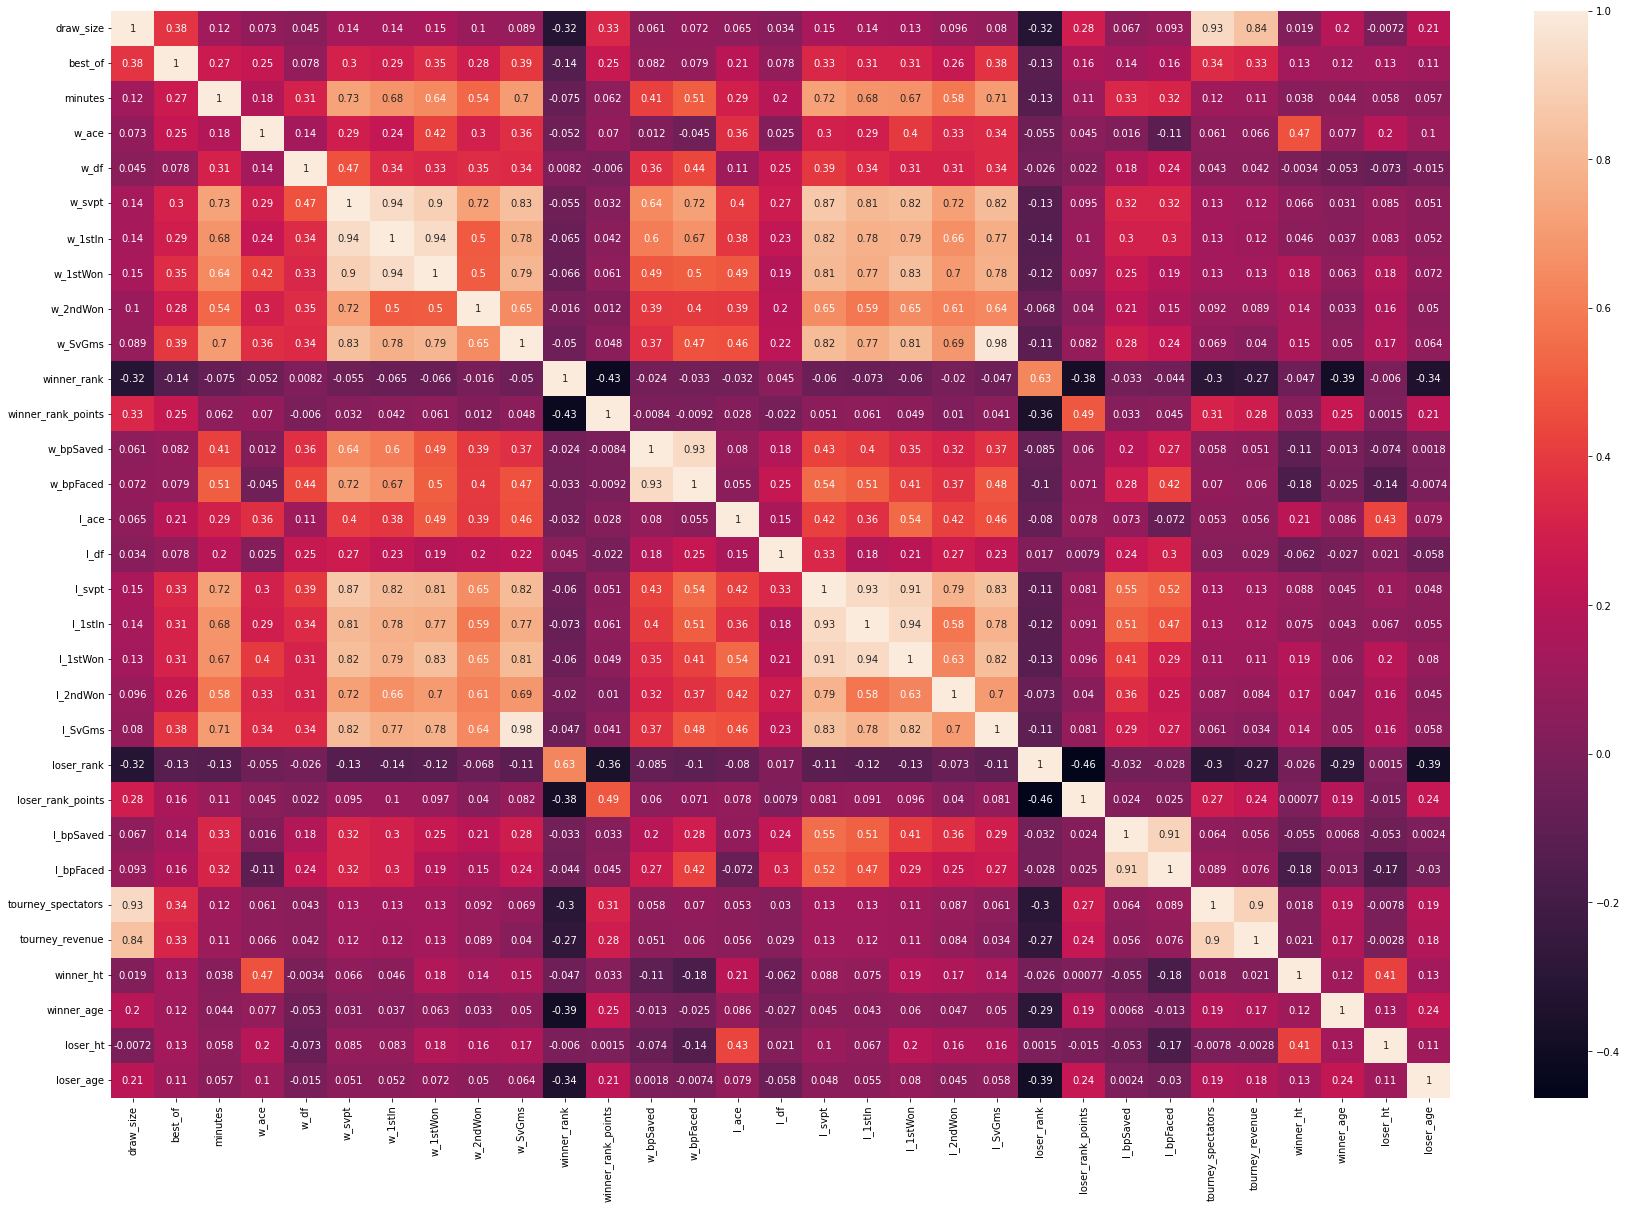

In [202]:
plt.figure(figsize = (30,20))
sns.heatmap(df_numeric.corr(), annot=True)

In [203]:
treshold = 0.8
correlation = df_numeric.corr()
correlation_filtered = correlation[correlation>treshold]
correlation_filtered

,draw_size,best_of,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,...,loser_rank,loser_rank_points,l_bpSaved,l_bpFaced,tourney_spectators,tourney_revenue,winner_ht,winner_age,loser_ht,loser_age
draw_size,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.929342,0.842169,NaN,NaN,NaN,NaN
best_of,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
minutes,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
w_ace,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
w_df,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
w_svpt,NaN,NaN,NaN,NaN,NaN,1.000000,0.938764,0.895809,NaN,0.830342,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
w_1stIn,NaN,NaN,NaN,NaN,NaN,0.938764,1.000000,0.942714,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
w_1stWon,NaN,NaN,NaN,NaN,NaN,0.895809,0.942714,1.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
w_2ndWon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
w_SvGms,NaN,NaN,NaN,NaN,NaN,0.830342,NaN,NaN,NaN,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [204]:
correlation_filtered = correlation[correlation_filtered.sum()>1]
correlation_filtered = correlation_filtered[correlation_filtered>treshold]
correlation_filtered = correlation_filtered.dropna(axis=1,how='all')
correlation_filtered

,draw_size,w_svpt,w_1stIn,w_1stWon,w_SvGms,w_bpSaved,w_bpFaced,l_svpt,l_1stIn,l_1stWon,l_SvGms,l_bpSaved,l_bpFaced,tourney_spectators,tourney_revenue
draw_size,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.929342,0.842169
w_svpt,NaN,1.000000,0.938764,0.895809,0.830342,NaN,NaN,0.866745,0.811052,0.823539,0.819756,NaN,NaN,NaN,NaN
w_1stIn,NaN,0.938764,1.000000,0.942714,NaN,NaN,NaN,0.817496,NaN,NaN,NaN,NaN,NaN,NaN,NaN
w_1stWon,NaN,0.895809,0.942714,1.000000,NaN,NaN,NaN,0.808253,NaN,0.831252,NaN,NaN,NaN,NaN,NaN
w_SvGms,NaN,0.830342,NaN,NaN,1.000000,NaN,NaN,0.815544,NaN,0.814072,0.981276,NaN,NaN,NaN,NaN
w_bpSaved,NaN,NaN,NaN,NaN,NaN,1.00000,0.93244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
w_bpFaced,NaN,NaN,NaN,NaN,NaN,0.93244,1.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
l_svpt,NaN,0.866745,0.817496,0.808253,0.815544,NaN,NaN,1.000000,0.931877,0.910678,0.834520,NaN,NaN,NaN,NaN
l_1stIn,NaN,0.811052,NaN,NaN,NaN,NaN,NaN,0.931877,1.000000,0.935864,NaN,NaN,NaN,NaN,NaN
l_1stWon,NaN,0.823539,NaN,0.831252,0.814072,NaN,NaN,0.910678,0.935864,1.000000,0.824717,NaN,NaN,NaN,NaN


**w_svpt, w_1stIn, w_1stWon, w_SvGms** are all correlated because more service game (w_SvGms) a player does and, as consequence, more serve points (w_svpt) ze does (because if the player serves in a game, ze serves for all the points in that game, so these number increase together). If a player serves, the number of the first serves (W_1stln) increase. Increasing the number of first serves, the probability of won some of these serves increase so, more first serves we do, more won first serves (W_1stWon) we expect. The same reasoning is done also for the loser. Furhermore, winner and loser serves in an alternate way so, if the number of serves of the winner increase (for example because of more games), then also the number of the loser increase, so these information grown together.

**w_bpSaved and w_bpFaced** are correlated because more are the breakpoints faced and more can be the breakpoint saved. 

In [205]:
correlation_filtered = correlation[correlation<-treshold]
correlation_filtered = correlation_filtered[correlation_filtered<-treshold]
correlation_filtered.dropna(axis=1,how='all',inplace=True)
correlation_filtered

""
draw_size
best_of
minutes
w_ace
w_df
w_svpt
w_1stIn
w_1stWon
w_2ndWon
w_SvGms


there are no negative correlations to consider

# Data Preparation

In [206]:
# load of the data
DATASET_DIR = "dataset" + os.path.sep
df_tennis = pd.read_csv(DATASET_DIR + 'tennis_matches.csv', sep=',', index_col=0) 

#index_col=False say to not use the first column as ID
df_male = pd.read_csv(DATASET_DIR + 'male_players.csv', sep=',', index_col=False)
df_female = pd.read_csv(DATASET_DIR + 'female_players.csv', sep=',', index_col=False) 

### Remove rows completely null

In [207]:
#remove null rows
df_male.dropna(how='all', inplace=True)
df_female.dropna(how='all', inplace=True)
df_tennis.dropna(how='all', inplace=True)

## Male and female datasets

In [208]:
#remove duplicates in the separate datasets
df_male.drop_duplicates(keep='first', inplace=True)
df_female.drop_duplicates(keep='first', inplace=True)

#### male

In [209]:
#rows with nulls in name: replace null with unknown
df_male.loc[df_male['name'].isna(), ['name']]='unknown'
df_male['name'].isna().sum(axis = 0)

0

In [210]:
#rows with nulls in surname: replace null with unknown
df_male.loc[df_male['surname'].isna(), ['surname']]='unknown'
df_male['surname'].isna().sum(axis = 0)

0

In [211]:
#errors reading from file: all in name and null surname (replaced with unknown)
df_male[df_male['name'].str.contains(",")]
for index, row in df_male[df_male['name'].str.contains(",")].iterrows():
    if row['surname']=='unknown':
        name = row['name'].split(",")
        df_male.at[index,'surname']=name[len(name)-1]
        df_male.at[index,'name']=' '.join(name[0:len(name)-1])
        
#print(df_male.loc[40071])

In [212]:
#names/surnames without any letters are invalid: set to unknown
df_male.loc[~df_male['name'].str.contains("[a-zA-Z]"), ['name']]='unknown'
df_male.loc[~df_male['surname'].str.contains("[a-zA-Z]"), ['surname']]='unknown'

#replace numbers in names
df_male["name"] = df_male["name"].str.replace("[0-9]","",regex=True)
df_male["surname"] = df_male["surname"].str.replace("[0-9]","",regex=True)

#characters not indicated in the expression are considered invalid
df_male["name"] = df_male["name"].str.replace("[^a-zA-Z ',-_.]","",regex=True)
#for surname remove string between ()
for index, row in  df_male[df_male['surname'].str.contains('\(')].iterrows():
    pos = df_male.at[index,'surname'].find("(")
    df_male.at[index,'surname']= df_male.at[index,'surname'][0:pos]
df_male["surname"] = df_male["surname"].str.replace("[^a-zA-Z ',-._]","",regex=True)

#replace allowed 
df_male["name"] = df_male["name"].str.replace("[^a-zA-Z ]"," ",regex=True)
df_male["surname"] = df_male["surname"].str.replace("[^a-zA-Z ]"," ",regex=True)

#trim apply
df_male["name"] = df_male["name"].str.strip()
df_male["surname"] = df_male["surname"].str.strip()

In [213]:
#check if duplicates are been introduced
df_male.duplicated(keep='first').sum()

14

In [214]:
#remove duplicates
df_male.drop_duplicates(keep='first', inplace=True)

In [215]:
#remove (if there is) the row <unknown unknown>
row = df_male.index[(df_male['name'].str.lower()=='unknown') & (df_male['surname'].str.lower()=='unknown')].tolist()
df_male.drop(row, inplace=True)

#### female

In [216]:
#rows with nulls in name: replace null with unknown
df_female.loc[df_female['name'].isna(), ['name']]='unknown'
df_female['name'].isna().sum(axis = 0)

0

In [217]:
#rows with nulls in surname: replace null with unknown
df_female.loc[df_female['surname'].isna(), ['surname']]='unknown'
df_female['surname'].isna().sum(axis = 0)

0

In [218]:
#errors reading from file: all in name and null surname (replaced with unknown)
df_female[df_female['name'].str.contains(",")]
for index, row in df_female[df_female['name'].str.contains(",")].iterrows():
    if row['surname']=='unknown':
        name = row['name'].split(",")
        df_female.at[index,'surname']=name[len(name)-1]
        df_female.at[index,'name']=' '.join(name[0:len(name)-1])

In [219]:
#names/surnames without any letters are invalid: set to unknown
df_female.loc[~df_female['name'].str.contains("[a-zA-Z]"), ['name']]='unknown'
df_female.loc[~df_female['surname'].str.contains("[a-zA-Z]"), ['surname']]='unknown'

#replace numbers in names
df_female["name"] = df_female["name"].str.replace("[0-9]","",regex=True)
df_female["surname"] = df_female["surname"].str.replace("[0-9]","",regex=True)

#characters not indicated in the expression are considered invalid
df_female["name"] = df_female["name"].str.replace("[^a-zA-Z ',-_.]","",regex=True)
#for surname remove string between ()
for index, row in  df_female[df_female['surname'].str.contains('\(')].iterrows():
    pos = df_female.at[index,'surname'].find("(")
    df_female.at[index,'surname']= df_female.at[index,'surname'][0:pos]
df_female["surname"] = df_female["surname"].str.replace("[^a-zA-Z ',-._]","",regex=True)

#replace allowed 
df_female["name"] = df_female["name"].str.replace("[^a-zA-Z ]"," ",regex=True)
df_female["surname"] = df_female["surname"].str.replace("[^a-zA-Z ]"," ",regex=True)

#trim apply
df_female["name"] = df_female["name"].str.strip()
df_female["surname"] = df_female["surname"].str.strip()

In [220]:
#check if duplicates are been introduced
df_female.duplicated(keep='first').sum()

1

In [221]:
#remove duplicates
df_female.drop_duplicates(keep='first', inplace=True)

In [222]:
#remove (if there is) the row <unknown unknown>
row = df_female.index[(df_female['name'].str.lower()=='unknown') & (df_female['surname'].str.lower()=='unknown')].tolist()
df_female.drop(row, inplace=True)

#### Player dataset

In [223]:
df_male['whole_name'] = df_male['name']+" "+df_male['surname']
df_male['sex']='M'
df_female['whole_name'] = df_female['name']+" "+df_female['surname']
df_female['sex']='F'

In [224]:
#creation of the dataset of the player including the information about sex
df_players = pd.concat([df_male, df_female])

In [225]:
#see if a name can be both male and female and manage them
df_players.loc[df_players.duplicated(subset=['name','surname'],keep=False)==True, ['sex']]='U'
df_players.drop_duplicates(keep='first', inplace=True)
df_players

,name,surname,whole_name,sex
0,Gardnar,Mulloy,Gardnar Mulloy,M
1,Pancho,Segura,Pancho Segura,M
2,Frank,Sedgman,Frank Sedgman,M
3,Giuseppe,Merlo,Giuseppe Merlo,M
4,Richard Pancho,Gonzales,Richard Pancho Gonzales,M
...,...,...,...,...
46167,Kathleen,Allen,Kathleen Allen,F
46168,Mrs,Dransfield,Mrs Dransfield,F
46169,Jessie,Greene,Jessie Greene,F
46170,Mary,Trumbull,Mary Trumbull,F


## Tennis dataset

In [226]:
df_tennis.drop_duplicates(keep='first', inplace=True)

#### tourney_id

In [227]:
df_tennis['tourney_id'].isna().sum(axis = 0)
df_tennis.loc[df_tennis['tourney_id'].isna(), ['tourney_id']]='unknown'

#### winner_name and loser_name

In [228]:
#rows with nulls in name: replace null with unknown
df_tennis.loc[df_tennis['winner_name'].isna(), ['winner_name']]='unknown unknown'
df_tennis['winner_name'].isna().sum(axis = 0)

df_tennis.loc[df_tennis['loser_name'].isna(), ['loser_name']]='unknown unknown'
df_tennis['loser_name'].isna().sum(axis = 0)

0

In [229]:
#nameswithout any letters are invalid: set to unknown
df_tennis.loc[~df_tennis['winner_name'].str.contains("[a-zA-Z]"), ['winner_name']]='unknown unknown'
df_tennis.loc[~df_tennis['loser_name'].str.contains("[a-zA-Z]"), ['loser_name']]='unknown unknown'

#replace numbers in names
df_tennis["winner_name"] = df_tennis["winner_name"].str.replace("[0-9]","",regex=True)
df_tennis["loser_name"] = df_tennis["loser_name"].str.replace("[0-9]","",regex=True)

#remove string between ()
for index, row in  df_tennis[df_tennis['winner_name'].str.contains('\(')].iterrows():
    pos = df_tennis.at[index,'winner_name'].find("(")
    df_tennis.at[index,'winner_name']= df_tennis.at[index,'winner_name'][0:pos]
for index, row in  df_tennis[df_tennis['loser_name'].str.contains('\(')].iterrows():
    pos = df_tennis.at[index,'loser_name'].find("(")
    df_tennis.at[index,'loser_name']= df_tennis.at[index,'loser_name'][0:pos]
    
#characters not indicated in the expression are considered invalid    
df_tennis["winner_name"] = df_tennis["winner_name"].str.replace("[^a-zA-Z ',-_.]","",regex=True)    
df_tennis["loser_name"] = df_tennis["loser_name"].str.replace("[^a-zA-Z ',-._]","",regex=True)

#replace allowed 
df_tennis["winner_name"] = df_tennis["winner_name"].str.replace("[^a-zA-Z ]"," ",regex=True)
df_tennis["loser_name"] = df_tennis["loser_name"].str.replace("[^a-zA-Z ]"," ",regex=True)

#trim apply
df_tennis["winner_name"] = df_tennis["winner_name"].str.strip()
df_tennis["loser_name"] = df_tennis["loser_name"].str.strip()
#df_tennis[['winner_name','loser_name']]

In [230]:
#check if duplicates are been introduced
df_tennis.duplicated(keep='first').sum()
#df_tennis[df_tennis.duplicated(keep='first')==True]

0

In [231]:
#remove duplicates
df_tennis.drop_duplicates(keep='first', inplace=True)

In [232]:
#remove (if there is) the row unknown-unknown for winner and (&) loser
row = df_tennis.index[(df_tennis['winner_name'].str.lower()=='unknown unknown') 
                      & (df_tennis['loser_name'].str.lower()=='unknown unknown')
                      & (df_tennis['winner_id'].isnull()) 
                      & (df_tennis['loser_id'].isnull()) 
                     ].tolist()
df_tennis.drop(row, inplace=True)

In [233]:
#remove multiple " "
df_tennis['winner_name'] = df_tennis['winner_name'].map(lambda x: re.sub(' +', ' ', x))
df_tennis['loser_name'] = df_tennis['loser_name'].map(lambda x: re.sub(' +', ' ', x))

Fixing names with more the one id binded 

In [234]:
#Removing the multiple ids for one name WINNER
mul_ids = get_w_name_ids()
df_mul_ids = df_tennis[df_tennis['winner_name'].isin(mul_ids) & (df_tennis['winner_name'] != 'unknown unknown')][['winner_name','winner_id']].sort_values(by=['winner_name','winner_id'])
w_names = df_mul_ids['winner_name'].unique().tolist()
w_ids = df_mul_ids['winner_id'].unique().tolist()
correct_w_id = {}
ids = df_mul_ids.groupby(['winner_name','winner_id'])['winner_id'].count().to_list()
i = 0
for name in w_names:
    if(ids[i] >= ids[i+1]):
        correct_w_id[name] = w_ids[i]
        df_tennis.loc[df_tennis['winner_name'] == name, 'winner_id'] = w_ids[i]
    else:
        correct_w_id[name] = w_ids[i+1]
        df_tennis.loc[df_tennis['winner_name'] == name, 'winner_id'] = w_ids[i+1]
    i+=2

In [235]:
df_tennis.loc[df_tennis['loser_name'] == 'unknown unknown', 'loser_name'] = None

In [236]:
#Removing the multiple ids for one name LOSER
mul_ids = get_l_name_ids()
df_mul_ids = df_tennis[df_tennis['loser_name'].isin(mul_ids)][['loser_name','loser_id']].sort_values(by=['loser_name','loser_id'])
l_names = df_mul_ids['loser_name'].unique().tolist()
l_ids = df_mul_ids['loser_id'].unique().tolist()
correct_l_id = {}
ids = df_mul_ids.groupby(['loser_name','loser_id'])['loser_id'].count().to_list()
i = 0
for name in l_names:
    if(ids[i] >= ids[i+1]):
        correct_l_id[name] = l_ids[i]
        df_tennis.loc[df_tennis['loser_name'] == name, 'loser_id'] = l_ids[i]
    else:
        correct_l_id[name] = l_ids[i+1]
        df_tennis.loc[df_tennis['loser_name'] == name, 'loser_id'] = l_ids[i+1]
    i+=2

**Removing id binded with multiple names**

In [237]:
# df_mul_names = df_tennis[df_tennis['winner_id'].isin(get_w_id_names())][['winner_name','winner_id']].sort_values(by=['winner_name','winner_id'])
# df_mul_names = df_mul_names.value_counts().reset_index()
# df_mul_names.columns = ['winner_name', 'winner_id', 'count']
# df_mul_names.sort_values(by='winner_id')

In [238]:
df_mul_names = df_tennis[df_tennis['winner_id'].isin(get_w_id_names())][['winner_name','winner_id']].sort_values(by=['winner_name','winner_id'])
df_mul_names = df_mul_names.value_counts().reset_index()
df_mul_names.columns = ['winner_name', 'winner_id', 'count']
df_mul_names.sort_values(by='winner_id')
id_list =  df_mul_names['winner_id'].unique()
for w_id in id_list:
    p1 = df_mul_names[df_mul_names['winner_id'] == w_id]['winner_name'].to_list()[0]
    c1 = df_mul_names[df_mul_names['winner_id'] == w_id]['count'].to_list()[0]
    p2 = df_mul_names[df_mul_names['winner_id'] == w_id]['winner_name'].to_list()[1]
    c2 = df_mul_names[df_mul_names['winner_id'] == w_id]['count'].to_list()[1]
    new_id = max(df_tennis['winner_id'].max(),df_tennis['loser_id'].max()) + 1
    if(c1 >= c2):
        df_tennis.loc[df_tennis['winner_name'] == p2, 'winner_id'] = new_id
        df_tennis.loc[df_tennis['loser_name'] == p2, 'loser_id'] = new_id
    else:
        df_tennis.loc[df_tennis['winner_name'] == p1, 'winner_id'] = new_id
        df_tennis.loc[df_tennis['loser_name'] == p1, 'loser_id'] = new_id        

In [239]:
df_mul_names = df_tennis[df_tennis['loser_id'].isin(get_l_id_names()) & (df_tennis['loser_name'] != 'unknown unknown')][['loser_name','loser_id']].sort_values(by=['loser_name','loser_id'])
df_mul_names = df_mul_names.value_counts().reset_index()
df_mul_names.columns = ['loser_name', 'loser_id', 'count']
df_mul_names.sort_values(by='loser_id')
id_list =  df_mul_names['loser_id'].unique()
for l_id in id_list:
    p1 = df_mul_names[df_mul_names['loser_id'] == l_id]['loser_name'].to_list()[0]
    c1 = df_mul_names[df_mul_names['loser_id'] == l_id]['count'].to_list()[0]
    p2 = df_mul_names[df_mul_names['loser_id'] == l_id]['loser_name'].to_list()[1]
    c2 = df_mul_names[df_mul_names['loser_id'] == l_id]['count'].to_list()[1]
    new_id = max(df_tennis['winner_id'].max(),df_tennis['loser_id'].max()) + 1
    if(c1 >= c2):
        df_tennis.loc[df_tennis['winner_name'] == p2, 'winner_id'] = new_id
        df_tennis.loc[df_tennis['loser_name'] == p2, 'loser_id'] = new_id
    else:
        df_tennis.loc[df_tennis['winner_name'] == p1, 'winner_id'] = new_id
        df_tennis.loc[df_tennis['loser_name'] == p1, 'loser_id'] = new_id    

In [240]:
df_tennis.loc[df_tennis['loser_name'].isna(), 'loser_name'] = 'unknown unknown'

#### merge names of datasets

In [241]:
tennis_names = df_tennis['winner_name'].drop_duplicates().tolist()+ \
                df_tennis['loser_name'].drop_duplicates().tolist()
tennis_names = list(dict.fromkeys(tennis_names))

In [242]:
df_names = pd.DataFrame(tennis_names, columns=['whole_name'])
df_names #10103 rows

,whole_name
0,Kei Nishikori
1,Daniil Medvedev
2,Jo Wilfried Tsonga
3,Jeremy Chardy
4,Alex De Minaur
...,...
10098,Dilara Sultanova
10099,Madeleine Jessup
10100,Katie Codd
10101,Amy Huang


In [243]:
df_players

,name,surname,whole_name,sex
0,Gardnar,Mulloy,Gardnar Mulloy,M
1,Pancho,Segura,Pancho Segura,M
2,Frank,Sedgman,Frank Sedgman,M
3,Giuseppe,Merlo,Giuseppe Merlo,M
4,Richard Pancho,Gonzales,Richard Pancho Gonzales,M
...,...,...,...,...
46167,Kathleen,Allen,Kathleen Allen,F
46168,Mrs,Dransfield,Mrs Dransfield,F
46169,Jessie,Greene,Jessie Greene,F
46170,Mary,Trumbull,Mary Trumbull,F


In [244]:
df_players = df_names.merge(df_players, how='left', on='whole_name')
df_players

,whole_name,name,surname,sex
0,Kei Nishikori,Kei,Nishikori,M
1,Daniil Medvedev,Daniil,Medvedev,M
2,Jo Wilfried Tsonga,Jo Wilfried,Tsonga,M
3,Jeremy Chardy,Jeremy,Chardy,M
4,Alex De Minaur,Alex,De Minaur,M
...,...,...,...,...
10098,Dilara Sultanova,Dilara,Sultanova,F
10099,Madeleine Jessup,Madeleine,Jessup,F
10100,Katie Codd,Katie,Codd,F
10101,Amy Huang,Amy,Huang,F


In [245]:
#df_players[df_players['winner_name']=='Carlos  Cuevas']
df_players.loc[df_players['sex'].isna(),'sex']='U'

In [246]:
#remove unknown - unknown
row = df_players.index[df_players['whole_name'].str.lower()=='unknown unknown'].tolist()
df_players.drop(row, inplace=True)

In [247]:
df_players = df_players.drop(columns=['name', 'surname'])

In [248]:
df_players

,whole_name,sex
0,Kei Nishikori,M
1,Daniil Medvedev,M
2,Jo Wilfried Tsonga,M
3,Jeremy Chardy,M
4,Alex De Minaur,M
...,...,...
10098,Dilara Sultanova,F
10099,Madeleine Jessup,F
10100,Katie Codd,F
10101,Amy Huang,F


In [249]:
df_tennis['winner_id'].max()

245147.0

**Adding id column to player dataframe**

In [250]:
df_w = df_tennis[['winner_name','winner_id']].drop_duplicates()
df_l = df_tennis[['loser_name','loser_id']].drop_duplicates()
df_l = df_l.rename(columns={"loser_name": "winner_name", "loser_id": "winner_id"})
df = df_w.append(df_l)
df = df.set_index('winner_name')
df = df.dropna()

dict_name_id = df.to_dict()
dict_name_id = dict_name_id['winner_id']
ids = []
for name in df_players['whole_name']:
    if name in dict_name_id:
        ids.append(dict_name_id[name])
print(len(ids))
df_players['id'] = ids

10102


In [251]:
df_players

,whole_name,sex,id
0,Kei Nishikori,M,105453.0
1,Daniil Medvedev,M,106421.0
2,Jo Wilfried Tsonga,M,104542.0
3,Jeremy Chardy,M,104871.0
4,Alex De Minaur,M,200282.0
...,...,...,...
10098,Dilara Sultanova,F,223315.0
10099,Madeleine Jessup,F,223075.0
10100,Katie Codd,F,223216.0
10101,Amy Huang,F,223217.0


In [252]:
df_tmp_names = df_players[['whole_name','id']]
df_tmp_names = df_tmp_names.set_index('whole_name')
df_tmp_ids = df_players[['whole_name','id']]
df_tmp_ids = df_tmp_ids.set_index('id')
dict_names_ids = df_tmp_names['id'].to_dict()
dict_ids_names = df_tmp_ids['whole_name'].to_dict()

In [253]:
#fill missing winner_id or winner_id values
conditions = (df_tennis['winner_id'].isnull() ^ (df_tennis['winner_name'] == 'unknown unknown'))
df_tmp = df_tennis[conditions][['winner_name','winner_id']]
for index, row in df_tmp.iterrows():
    if(row['winner_name'] == 'unknown unknown'):
         if(row['winner_id'] in dict_ids_names.keys()):
                print(row['winner_name'], row['winner_id'])
                df_tennis.loc[df_tennis['winner_id'] == row['winner_id'], 'winner_name'] = dict_ids_names[row['winner_id']]
    else:
         if(row['winner_name'] in dict_names_ids.keys()):
            df_tennis.loc[df_tennis['winner_name'] == row['winner_name'], 'winner_id'] = dict_names_ids[row['winner_name']]

In [254]:
#fill missing loser_id or loser_id values
conditions = (df_tennis['loser_id'].isnull() ^ (df_tennis['loser_name'] == 'unknown unknown'))
df_tmp = df_tennis[conditions][['loser_name','loser_id']]
for index, row in df_tmp.iterrows():
    if(row['loser_name'] == 'unknown unknown'):
         if(row['loser_id'] in dict_ids_names.keys()):
                df_tennis.loc[df_tennis['loser_id'] == row['loser_id'], 'loser_name'] = dict_ids_names[row['loser_id']]
    else:
         if(row['loser_name'] in dict_names_ids.keys()):
            df_tennis.loc[df_tennis['loser_name'] == row['loser_name'], 'loser_id'] = dict_names_ids[row['loser_name']]

#### establish sex looking matches

In [255]:
#establish sex for unknown and correct for known if there are errors

In [256]:
sex_dict = dict(zip(df_players.whole_name, df_players.sex))
dict_winner_match = df_tennis.groupby('winner_name')['loser_name'].unique().dropna().apply(list).to_dict()
dict_loser_match = df_tennis.groupby('loser_name')['winner_name'].unique().dropna().apply(list).to_dict()

In [257]:
#check if errors with F or M
error = 0
erorr_rows_indexes = []

for index, row in df_players[df_players['sex']!='U'].iterrows():
    #consider the players as winner
    if row['whole_name'] in dict_winner_match:
        losers = dict_winner_match[row['whole_name']]
        for loser in losers:
            if loser!='unknown unknown' and row['sex']!=sex_dict[loser] and sex_dict[loser]!='U':
                error +=1
                erorr_rows_indexes.append(row)
    
    #consider the players as loser
    if row['whole_name'] in dict_loser_match:
        winners = dict_loser_match[row['whole_name']]
        for winner in winners:
            if winner!='unknown unknown' and row['sex']!=sex_dict[winner] and sex_dict[winner]!='U':
                error +=1
                erorr_rows_indexes.append(row)

In [258]:
error
erorr_rows_indexes

[]

So, in each match male is against male and female against female (or unknown)

In [259]:
#correct unknown sex and check if we introduce errors
error = 0
erorr_rows_indexes = []

for index, row in df_players[df_players['sex']!='U'].iterrows():
    #consider the players as winner
    if row['whole_name'] in dict_winner_match:
        losers = dict_winner_match[row['whole_name']]
        for loser in losers:
            if loser!='unknown unknown' and row['sex']!=sex_dict[loser]:
                if sex_dict[loser]!='U':
                    error +=1
                    erorr_rows_indexes.append(row)
                else:
                    #set sex of the loser as row['sex']
                    df_players.at[index,'sex']= row['sex']
                    sex_dict = dict(zip(df_players.whole_name, df_players.sex))
    
    #consider the players as loser
    if row['whole_name'] in dict_loser_match:
        winners = dict_loser_match[row['whole_name']]
        for winner in winners:
            if winner!='unknown unknown' and row['sex']!=sex_dict[winner]:
                if sex_dict[winner]!='U':
                    error +=1
                    erorr_rows_indexes.append(row)
                else:
                    #set sex of the loser as row['sex']
                    df_players.at[index,'sex']= row['sex']
                    sex_dict = dict(zip(df_players.whole_name, df_players.sex))

In [260]:
df_players[df_players['sex']=='U'].shape[0] #35

35

#### tourney_name

In [261]:
#rows with nulls in name: replace null with unknown
df_tennis.loc[df_tennis['tourney_name'].isna(), ['tourney_name']]='unknown'

In [262]:
#names without any letters are invalid: set to unknown
df_tennis.loc[~df_tennis['tourney_name'].str.contains("[a-zA-Z]"), ['tourney_name']]='unknown'

#replace numbers in names
df_tennis["tourney_name"] = df_tennis["tourney_name"].str.replace("[0-9]","",regex=True)

#remove string between ()
for index, row in  df_tennis[df_tennis['tourney_name'].str.contains('\(')].iterrows():
    pos = df_tennis.at[index,'tourney_name'].find("(")
    df_tennis.at[index,'tourney_name']= df_tennis.at[index,'tourney_name'][0:pos]
    
#characters not indicated in the expression are considered invalid    
df_tennis["tourney_name"] = df_tennis["tourney_name"].str.replace("[^a-zA-Z -_]","",regex=True)
df_tennis["tourney_name"] = df_tennis["tourney_name"].str.replace("[^a-zA-Z ]"," ",regex=True)

#trim apply
df_tennis["tourney_name"] = df_tennis["tourney_name"].str.strip()
df_tennis

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_entry,winner_name,...,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue
0,2019-M020,Brisbane,Hard,32.0,A,20181231.0,300.0,105453.0,NaN,Kei Nishikori,...,20.0,14.0,10.0,15.0,9.0,3590.0,16.0,1977.0,3928.0,742618.69
1,2019-M020,Brisbane,Hard,32.0,A,20181231.0,299.0,106421.0,NaN,Daniil Medvedev,...,7.0,10.0,10.0,13.0,16.0,1977.0,239.0,200.0,3928.0,742618.69
2,2019-M020,Brisbane,Hard,32.0,A,20181231.0,298.0,105453.0,NaN,Kei Nishikori,...,6.0,8.0,1.0,5.0,9.0,3590.0,40.0,1050.0,3928.0,742618.69
3,2019-M020,Brisbane,Hard,32.0,A,20181231.0,297.0,104542.0,PR,Jo Wilfried Tsonga,...,9.0,11.0,4.0,6.0,239.0,200.0,31.0,1298.0,3928.0,742618.69
4,2019-M020,Brisbane,Hard,32.0,A,20181231.0,296.0,106421.0,NaN,Daniil Medvedev,...,19.0,15.0,2.0,4.0,16.0,1977.0,18.0,1855.0,3928.0,742618.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186123,unknown,unknown,Hard,32.0,NaN,20171113.0,250.0,NaN,NaN,unknown unknown,...,NaN,NaN,7.0,11.0,NaN,322.0,280.0,183.0,NaN,NaN
186124,unknown,Taipei,NaN,32.0,C,20171113.0,NaN,206368.0,NaN,Veronika Kudermetova,...,NaN,NaN,NaN,NaN,255.0,217.0,704.0,NaN,NaN,NaN
186125,unknown,unknown,NaN,NaN,C,NaN,NaN,203435.0,NaN,Dalila Jakupovic,...,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN
186126,unknown,unknown,NaN,32.0,C,20171113.0,NaN,201554.0,NaN,Vitalia Diatchenko,...,13.0,NaN,3.0,NaN,176.0,NaN,NaN,NaN,3535.0,NaN


In [263]:
#check if duplicates are been introduced
df_tennis.duplicated(keep='first').sum()

0

In [264]:
#remove duplicates
df_tennis.drop_duplicates(keep='first', inplace=True)
#rows with unknown tourney_name: 21. All of these have null tourney_id

In [265]:
#remove multiple " "
df_tennis['tourney_name'] = df_tennis['tourney_name'].map(lambda x: re.sub(' +', ' ', x))

In [266]:
#make the name equal for similar names (es: Madrid, Madrid Master associated to same tourney_id)

In [267]:
dict_tourney_id = df_tennis.groupby('tourney_id')['tourney_name'].unique().apply(list).to_dict()

In [268]:
#print tourneys with more names
keys = []
for key, value in dict_tourney_id.items():
    if len(value)>1:
        print(key, value)
        keys.append(keys)

2016-M006 ['Indian Wells', 'Indian Wells Masters']
2016-M007 ['Miami', 'Miami Masters']
2016-M009 ['Rome', 'Rome Masters']
2016-M021 ['Madrid', 'Madrid Masters']
2016-M024 ['Cincinnati', 'Cincinnati Masters']
2016-O16 ['Olympics', 'Rio Olympics']
2017-M006 ['Indian Wells', 'Indian Wells Masters']
2017-M007 ['Miami', 'Miami Masters']
2017-M009 ['Rome', 'Rome Masters']
2017-M021 ['Madrid', 'Madrid Masters']
2017-M024 ['Cincinnati', 'Cincinnati Masters']
2018-M006 ['Indian Wells Masters', 'Indian Wells']
2018-M007 ['Miami Masters', 'Miami']
2018-M009 ['Rome Masters', 'Rome']
2018-M021 ['Madrid Masters', 'Madrid']
2018-M024 ['Cincinnati Masters', 'Cincinnati']
2019-560 ['US Open', 'Us Open']
2019-M006 ['Indian Wells Masters', 'Indian Wells']
2019-M007 ['Miami Masters', 'Miami']
2019-M009 ['Rome Masters', 'Rome']
2019-M010 ['s Hertogenbosch', 'S Hertogenbosch']
2019-M021 ['Madrid Masters', 'Madrid']
2019-M024 ['Cincinnati Masters', 'Cincinnati']
2020-M009 ['Rome Masters', 'Rome']
2020-M024 

In [269]:
for key, value in dict_tourney_id.items():
    if len(value)==2:
        if value[0].lower() == value[1].lower():
            df_tennis.loc[df_tennis['tourney_id']==key, ['tourney_name']]=value[0]
        elif value[0]=='unknown':
            df_tennis.loc[df_tennis['tourney_id']==key, ['tourney_name']]=value[1]
        elif value[1]=='unknown':
            df_tennis.loc[df_tennis['tourney_id']==key, ['tourney_name']]=value[0]
        elif value[0].lower() in value[1].lower():
            df_tennis.loc[df_tennis['tourney_id']==key, ['tourney_name']]=value[1]
        elif value[1].lower() in value[0].lower():
            df_tennis.loc[df_tennis['tourney_id']==key, ['tourney_name']]=value[0]

#### winner_hand and loser_hand

In [270]:
df_players['hand']='U'

In [271]:
#substitute nulls in hand in tennis with 'U'
df_tennis.loc[df_tennis['winner_hand'].isna(), ['winner_hand']]='U'
df_tennis.loc[df_tennis['loser_hand'].isna(), ['loser_hand']]='U'

In [272]:
df_tennis[(df_tennis['winner_hand']=='R') | (df_tennis['winner_hand']=='L')] #136650 rows

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_entry,winner_name,...,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue
0,2019-M020,Brisbane,Hard,32.0,A,20181231.0,300.0,105453.0,NaN,Kei Nishikori,...,20.0,14.0,10.0,15.0,9.0,3590.0,16.0,1977.0,3928.0,742618.69
1,2019-M020,Brisbane,Hard,32.0,A,20181231.0,299.0,106421.0,NaN,Daniil Medvedev,...,7.0,10.0,10.0,13.0,16.0,1977.0,239.0,200.0,3928.0,742618.69
2,2019-M020,Brisbane,Hard,32.0,A,20181231.0,298.0,105453.0,NaN,Kei Nishikori,...,6.0,8.0,1.0,5.0,9.0,3590.0,40.0,1050.0,3928.0,742618.69
3,2019-M020,Brisbane,Hard,32.0,A,20181231.0,297.0,104542.0,PR,Jo Wilfried Tsonga,...,9.0,11.0,4.0,6.0,239.0,200.0,31.0,1298.0,3928.0,742618.69
4,2019-M020,Brisbane,Hard,32.0,A,20181231.0,296.0,106421.0,NaN,Daniil Medvedev,...,19.0,15.0,2.0,4.0,16.0,1977.0,18.0,1855.0,3928.0,742618.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186114,unknown,Taipei,NaN,NaN,C,NaN,253.0,NaN,NaN,unknown unknown,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3535.0,638954.72
186115,unknown,Taipei,NaN,NaN,NaN,NaN,NaN,211880.0,NaN,Priscilla Hon,...,9.0,10.0,NaN,NaN,NaN,243.0,181.0,322.0,NaN,NaN
186119,unknown,Taipei,NaN,NaN,C,NaN,246.0,201674.0,NaN,Sabina Sharipova,...,10.0,9.0,7.0,12.0,196.0,NaN,NaN,231.0,3535.0,638954.72
186120,unknown,Taipei,Hard,NaN,NaN,NaN,NaN,NaN,NaN,unknown unknown,...,9.0,NaN,2.0,NaN,230.0,NaN,250.0,221.0,NaN,NaN


In [273]:
#correct hand in df_tennis for future possible analysis
for index, row in  df_players.iterrows():
    
    winner_rows = df_tennis[df_tennis['winner_name']==row['whole_name']]['winner_hand']
    loser_rows = df_tennis[df_tennis['loser_name']==row['whole_name']]['loser_hand']
    
    hands = winner_rows.dropna().unique().tolist() + loser_rows.dropna().unique().tolist()
    hands = list(dict.fromkeys(hands))
    if len(hands)==2 and 'U' in hands:
        if(hands[0]!='U'):
            df_players.at[index,'hand']= hands[0]
            df_tennis.at[winner_rows.index,'winner_hand']=hands[0]
            df_tennis.at[loser_rows.index, 'loser_hand']=hands[0]
        else:
            df_players.at[index,'hand']= hands[1]
            df_tennis.at[winner_rows.index, 'winner_hand']=hands[1]
            df_tennis.at[loser_rows.index, 'loser_hand']=hands[1]
    elif len(hands)==1 and hands[0]!='U':
        df_players.at[index,'hand']= hands[0]
        df_tennis.at[winner_rows.index, 'winner_hand']=hands[0]
        df_tennis.at[loser_rows.index, 'loser_hand']=hands[0]

In [274]:
df_players[df_players['hand']=='U']

,whole_name,sex,id,hand
20,Kimberly Birrell,F,214040.0,U
42,Zoe Hives,F,211941.0,U
253,Kaylah Mcphee,F,215804.0,U
258,Valentini Grammatikopoulou,F,204394.0,U
271,Nadia Podoroska,F,206408.0,U
...,...,...,...,...
10098,Dilara Sultanova,F,223315.0,U
10099,Madeleine Jessup,F,223075.0,U
10100,Katie Codd,F,223216.0,U
10101,Amy Huang,F,223217.0,U


#### rank and point_rank

In [275]:
df_players['best_rank'] = 0 #default value for unknown
df_players['best_rank_points'] = 0 #default value for unknown

In [276]:
dict_winner_rank = df_tennis[~df_tennis['winner_rank'].isna()].groupby('winner_name', dropna=True)['winner_rank'].unique().apply(list).to_dict()
dict_loser_rank = df_tennis[~df_tennis['loser_rank'].isna()].groupby('loser_name', dropna=True)['loser_rank'].unique().apply(list).to_dict()

dict_winner_rank_points = df_tennis[~df_tennis['winner_rank_points'].isna()].groupby('winner_name', dropna=True)['winner_rank_points'].unique().apply(list).to_dict()
dict_loser_rank_points = df_tennis[~df_tennis['loser_rank_points'].isna()].groupby('loser_name', dropna=True)['loser_rank_points'].unique().apply(list).to_dict()

In [277]:
for index, row in  df_players.iterrows():  
    
    #rank
    ranks = []
    if row['whole_name'] in dict_winner_rank:
        ranks = ranks + dict_winner_rank[row['whole_name']]
    if row['whole_name'] in dict_loser_rank:
        ranks = ranks + dict_loser_rank[row['whole_name']]
     
    ranks = list(dict.fromkeys(ranks))
    if len(ranks)>0:
        df_players.at[index, 'best_rank'] = min(ranks)
    
    #points
    ranks_point = []
    if row['whole_name'] in dict_winner_rank_points:
        ranks_point = ranks + dict_winner_rank_points[row['whole_name']]
    if row['whole_name'] in dict_loser_rank_points:
        ranks_point = ranks + dict_loser_rank_points[row['whole_name']]
    
    ranks_point = list(dict.fromkeys(ranks_point))
    if len(ranks_point)>0:
        df_players.at[index, 'best_rank_points'] = max(ranks_point)
    
df_tennis

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_entry,winner_name,...,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue
0,2019-M020,Brisbane,Hard,32.0,A,20181231.0,300.0,105453.0,NaN,Kei Nishikori,...,20.0,14.0,10.0,15.0,9.0,3590.0,16.0,1977.0,3928.0,742618.69
1,2019-M020,Brisbane,Hard,32.0,A,20181231.0,299.0,106421.0,NaN,Daniil Medvedev,...,7.0,10.0,10.0,13.0,16.0,1977.0,239.0,200.0,3928.0,742618.69
2,2019-M020,Brisbane,Hard,32.0,A,20181231.0,298.0,105453.0,NaN,Kei Nishikori,...,6.0,8.0,1.0,5.0,9.0,3590.0,40.0,1050.0,3928.0,742618.69
3,2019-M020,Brisbane,Hard,32.0,A,20181231.0,297.0,104542.0,PR,Jo Wilfried Tsonga,...,9.0,11.0,4.0,6.0,239.0,200.0,31.0,1298.0,3928.0,742618.69
4,2019-M020,Brisbane,Hard,32.0,A,20181231.0,296.0,106421.0,NaN,Daniil Medvedev,...,19.0,15.0,2.0,4.0,16.0,1977.0,18.0,1855.0,3928.0,742618.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186123,unknown,Taipei,Hard,32.0,NaN,20171113.0,250.0,NaN,NaN,unknown unknown,...,NaN,NaN,7.0,11.0,NaN,322.0,280.0,183.0,NaN,NaN
186124,unknown,Taipei,NaN,32.0,C,20171113.0,NaN,206368.0,NaN,Veronika Kudermetova,...,NaN,NaN,NaN,NaN,255.0,217.0,704.0,NaN,NaN,NaN
186125,unknown,Taipei,NaN,NaN,C,NaN,NaN,203435.0,NaN,Dalila Jakupovic,...,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN
186126,unknown,Taipei,NaN,32.0,C,20171113.0,NaN,201554.0,NaN,Vitalia Diatchenko,...,13.0,NaN,3.0,NaN,176.0,NaN,NaN,NaN,3535.0,NaN


In [278]:
#df_players[df_players['best_rank']==1]
df_players

,whole_name,sex,id,hand,best_rank,best_rank_points
0,Kei Nishikori,M,105453.0,R,4,5010
1,Daniil Medvedev,M,106421.0,R,2,10620
2,Jo Wilfried Tsonga,M,104542.0,R,7,3480
3,Jeremy Chardy,M,104871.0,R,28,1265
4,Alex De Minaur,M,200282.0,R,15,2690
...,...,...,...,...,...,...
10098,Dilara Sultanova,F,223315.0,U,0,0
10099,Madeleine Jessup,F,223075.0,U,0,0
10100,Katie Codd,F,223216.0,U,0,0
10101,Amy Huang,F,223217.0,U,0,0


In [279]:
df_tennis.loc[df_tennis['winner_rank'].isna(), 'winner_rank'] = 0
df_tennis.loc[df_tennis['winner_rank_points'].isna(), 'winner_rank_points'] = 0

df_tennis.loc[df_tennis['loser_rank'].isna(), 'loser_rank'] = 0
df_tennis.loc[df_tennis['loser_rank_points'].isna(), 'loser_rank_points'] = 0

#### best of and score

In [280]:
#change best of 3 in 5 if matches are valid for best of 5 (best_of not null)
for index, row in  df_tennis[df_tennis['best_of']==3].iterrows():
    if isinstance(row['score'], str):
        sets = row['score'].split( )

        if not validity_match(sets, 3) and validity_match(sets, 5):
            df_tennis.loc[index, 'best_of'] = 5
        elif validity_match(sets, 5) and not is_best_of_3(sets)and is_best_of_5(sets):
            df_tennis.loc[index, 'best_of'] = 5
        

#change best of 5 in 3 if matches are valid for best of 3
for index, row in  df_tennis[df_tennis['best_of']==5].iterrows():
    if isinstance(row['score'], str):
        sets = row['score'].split( )

        if not validity_match(sets, 5) and validity_match(sets, 3):
            df_tennis.loc[index, 'best_of'] = 3
        elif validity_match(sets, 3) and is_best_of_3(sets) and not is_best_of_5(sets):
            df_tennis.loc[index, 'best_of'] = 3

In [281]:
df_tennis[df_tennis['best_of'].isna()]['score'].dropna()
#df_tennis[df_tennis['best_of'].isna()]['score'].dropna().index.tolist()

186079       6-7(4) 6-2 6-3
186080       6-2 6-7(1) 6-2
186083          6-3 3-6 6-0
186085       2-6 7-6(9) 7-5
186090          1-6 7-5 6-4
186091          1-6 6-3 6-4
186095              6-4 6-3
186096              7-5 6-3
186099              6-4 7-5
186102              6-2 6-4
186104    6-7(7) 7-6(6) 6-2
186116    6-7(7) 7-6(6) 6-2
186120           7-6(3) 6-3
186121              6-3 6-2
186123          3-6 6-2 6-3
186124           7-6(3) 6-2
186127              6-4 6-4
Name: score, dtype: object

In [282]:
for index, row in  df_tennis[df_tennis['best_of'].isna()].iterrows():
    if isinstance(row['score'], str):
        sets = row['score'].split( )

        if validity_match(sets, 3) and not validity_match(sets, 5):
            df_tennis.loc[index, 'best_of'] = 3
        elif not validity_match(sets, 3) and validity_match(sets, 5):
            df_tennis.loc[index, 'best_of'] = 5
        elif validity_match(sets, 3) and validity_match(sets, 5):
            if is_best_of_3(sets) and not is_best_of_5(sets):
                df_tennis.loc[index, 'best_of'] = 3
            elif not is_best_of_3(sets) and is_best_of_5(sets):
                df_tennis.loc[index, 'best_of'] = 5

In [283]:
for index, row in df_tennis[df_tennis['best_of'].isna()][['tourney_id','tourney_name']].drop_duplicates().iterrows():
    best_ofs = df_tennis[(df_tennis['tourney_id']==row['tourney_id']) & (df_tennis['tourney_name']==row['tourney_name'])]['best_of'].dropna().tolist()
    values = list(dict.fromkeys(best_ofs))
    if len(values) == 1:
        df_tennis.loc[(df_tennis['tourney_id']==row['tourney_id']) & (df_tennis['tourney_name']==row['tourney_name']), 'best_of'] = values[0]

In [284]:
df_tennis.loc[df_tennis['score'].isna(), 'score'] = ""

In [285]:
count = 0
for index, row in  df_tennis.iterrows():
    if row['score']!="":
        sets = row['score'].split()
        if not Walkover(sets[0]) and not Bye(sets[0]) and not Retirement(sets[0]) and not Default(sets[0]) \
            and not validity_match(sets, 3) and not validity_match(sets, 5):
            df_tennis.loc[index, 'score'] = ""
            count +=1
        
count

5155

In [286]:
#wrong scores
count

5155

#### num of best of 3/5 played and wins (%)

In [287]:
df_players['best_of_3_match'] = 0
df_players['best_of_5_match'] = 0
df_players['best_of_3_wins(%)'] = 0
df_players['best_of_5_wins(%)'] = 0

In [288]:
winners_best_3 = df_tennis[(df_tennis['winner_name']!=df_tennis['loser_name']) & (df_tennis['best_of']==3)]['winner_name'].tolist()
losers_best_3 = df_tennis[(df_tennis['winner_name']!=df_tennis['loser_name']) & (df_tennis['best_of']==3)]['loser_name'].tolist()

In [289]:
winners_best_5 = df_tennis[(df_tennis['winner_name']!=df_tennis['loser_name']) & (df_tennis['best_of']==5)]['winner_name'].tolist()
losers_best_5 = df_tennis[(df_tennis['winner_name']!=df_tennis['loser_name']) & (df_tennis['best_of']==5)]['loser_name'].tolist()

In [290]:
for index, row in  df_players.iterrows(): 
    num_w = winners_best_3.count(row['whole_name'])
    num_l = losers_best_3.count(row['whole_name'])
    
    df_players.at[index, 'best_of_3_match'] = num_w + num_l
    if num_l!=0 and num_w!=0:
        df_players.at[index, 'best_of_3_wins(%)'] = num_w/(num_l+num_w)*100
        
    num_w = winners_best_5.count(row['whole_name'])
    num_l = losers_best_5.count(row['whole_name'])
    
    df_players.at[index, 'best_of_5_match'] = num_w + num_l
    if num_l!=0 and num_w!=0:
        df_players.at[index, 'best_of_5_wins(%)'] = num_w/(num_l+num_w)*100

In [291]:
df_players

,whole_name,sex,id,hand,best_rank,best_rank_points,best_of_3_match,best_of_5_match,best_of_3_wins(%),best_of_5_wins(%)
0,Kei Nishikori,M,105453.0,R,4,5010,208,75,64,74
1,Daniil Medvedev,M,106421.0,R,2,10620,324,58,70,65
2,Jo Wilfried Tsonga,M,104542.0,R,7,3480,148,49,64,61
3,Jeremy Chardy,M,104871.0,R,28,1265,242,38,55,36
4,Alex De Minaur,M,200282.0,R,15,2690,234,38,61,50
...,...,...,...,...,...,...,...,...,...,...
10098,Dilara Sultanova,F,223315.0,U,0,0,1,0,0,0
10099,Madeleine Jessup,F,223075.0,U,0,0,1,0,0,0
10100,Katie Codd,F,223216.0,U,0,0,1,0,0,0
10101,Amy Huang,F,223217.0,U,0,0,1,0,0,0


#### walkover, retirements, bye and defaults

In [292]:
df_players['num_win_bye'] = 0
df_players['num_win_wo_ret'] = 0
df_players['num_win_def'] = 0
df_players['num_wo_ret'] = 0
df_players['num_def'] = 0

In [293]:
for index, row in  df_players.iterrows():
    #for the winner: vittorie per bye, walkover and default
    win_bye = 0
    win_wo_ret = 0
    win_def = 0
    
    for index_t, row_t in df_tennis[df_tennis['winner_name']==row['whole_name']].iterrows():
        games = row_t['score'].split()
        if row_t['winner_name']==row_t['loser_name']:
            if len(games)==1 and Bye(games[0]):
                win_bye+=1
        else:
            if (len(games)==1 and (Walkover(games[0]) or Retirement(games[0]))) or \
                (len(games)>1 and Retirement(games[len(games)-1])):
                    win_wo_ret +=1
            elif len(games)>=1 and Default(games[len(games)-1]):
                win_def +=1
            elif len(games)==1 and Bye(games[0]):
                win_bye +=1
            
    df_players.at[index, 'num_win_bye'] = win_bye
    df_players.at[index, 'num_win_wo_ret'] = win_wo_ret
    df_players.at[index, 'num_win_def'] = win_def
                
    loser_wo_ret = 0
    loser_def = 0
        
    #for the loser: perdite per walkover, retirement and default
    for index_t, row_t in df_tennis[df_tennis['loser_name']==row['whole_name']].iterrows():
        games = row_t['score'].split()
        if row_t['winner_name']!=row_t['loser_name']:
            if (len(games)==1 and (Walkover(games[0]) or Retirement(games[0]))) or \
                (len(games)>1 and Retirement(games[len(games)-1])):
                    loser_wo_ret +=1
            elif len(games)>=1 and Default(games[len(games)-1]):
                loser_def +=1
                
    df_players.at[index, 'num_wo_ret'] = loser_wo_ret
    df_players.at[index, 'num_def'] = loser_def

In [294]:
df_players

,whole_name,sex,id,hand,best_rank,best_rank_points,best_of_3_match,best_of_5_match,best_of_3_wins(%),best_of_5_wins(%),num_win_bye,num_win_wo_ret,num_win_def,num_wo_ret,num_def
0,Kei Nishikori,M,105453.0,R,4,5010,208,75,64,74,0,5,0,8,0
1,Daniil Medvedev,M,106421.0,R,2,10620,324,58,70,65,0,4,0,3,1
2,Jo Wilfried Tsonga,M,104542.0,R,7,3480,148,49,64,61,0,3,0,7,0
3,Jeremy Chardy,M,104871.0,R,28,1265,242,38,55,36,0,5,0,3,0
4,Alex De Minaur,M,200282.0,R,15,2690,234,38,61,50,0,7,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10098,Dilara Sultanova,F,223315.0,U,0,0,1,0,0,0,0,0,0,0,0
10099,Madeleine Jessup,F,223075.0,U,0,0,1,0,0,0,0,0,0,0,0
10100,Katie Codd,F,223216.0,U,0,0,1,0,0,0,0,0,0,0,0
10101,Amy Huang,F,223217.0,U,0,0,1,0,0,0,0,0,0,0,0


#### IOC

In [295]:
df_players.insert(2, 'ioc', None)

In [296]:
for index, row in df_players.iterrows():
    ioc = None
    if df_tennis[df_tennis['winner_id'] == row['id']][['winner_ioc']].shape[0] > 0:
        ioc = df_tennis[df_tennis['winner_id'] == row['id']][['winner_ioc']].iloc[0]
    if ioc is None:    
        if df_tennis[df_tennis['loser_id'] == row['id']][['loser_ioc']].shape[0] > 0:
            ioc = df_tennis[df_tennis['loser_id'] == row['id']][['loser_ioc']].iloc[0]
    df_players.loc[df_players['id']==row['id'], 'ioc']=ioc.iloc[0]
    # for debug uncomment...
    #if index == 100:
    #    break
df_players[~df_players['ioc'].isnull()]

,whole_name,sex,ioc,id,hand,best_rank,best_rank_points,best_of_3_match,best_of_5_match,best_of_3_wins(%),best_of_5_wins(%),num_win_bye,num_win_wo_ret,num_win_def,num_wo_ret,num_def
0,Kei Nishikori,M,JPN,105453.0,R,4,5010,208,75,64,74,0,5,0,8,0
1,Daniil Medvedev,M,RUS,106421.0,R,2,10620,324,58,70,65,0,4,0,3,1
2,Jo Wilfried Tsonga,M,FRA,104542.0,R,7,3480,148,49,64,61,0,3,0,7,0
3,Jeremy Chardy,M,FRA,104871.0,R,28,1265,242,38,55,36,0,5,0,3,0
4,Alex De Minaur,M,AUS,200282.0,R,15,2690,234,38,61,50,0,7,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10098,Dilara Sultanova,F,TKM,223315.0,U,0,0,1,0,0,0,0,0,0,0,0
10099,Madeleine Jessup,F,USA,223075.0,U,0,0,1,0,0,0,0,0,0,0,0
10100,Katie Codd,F,USA,223216.0,U,0,0,1,0,0,0,0,0,0,0,0
10101,Amy Huang,F,USA,223217.0,U,0,0,1,0,0,0,0,0,0,0,0


#### surface

In [297]:
# prepare a dictionary of tourney_name and surface where there are no null
df_surface = df_tennis[['tourney_name','surface']].drop_duplicates().dropna()
surface_dict = df_surface.set_index('tourney_name').to_dict()['surface']

# set the null value with the value found for the same tournament
null_surface = df_tennis.surface.isna()
df_tennis.loc[null_surface, 'surface'] = df_tennis.tourney_name.map(surface_dict)


# set the remaining surface null to unknown
df_tennis.loc[df_tennis['surface'].isna(), ['surface']]='unknown'

# print the result
df_tennis['surface'].value_counts().sort_index()

Carpet      3053
Clay       81017
Grass       6600
Hard       94997
unknown      147
Name: surface, dtype: int64

#### draw_size

In [298]:
# prepare a dictionary of tourney_name and draw_size where there are no null
df_draw_size = df_tennis[['tourney_name','draw_size']].drop_duplicates().dropna()
draw_size_dict = df_draw_size.set_index('tourney_name').to_dict()['draw_size']

# set the null value with the value found for the same tournament
null_draw_size = df_tennis.draw_size.isna()
df_tennis.loc[null_draw_size, 'draw_size'] = df_tennis.tourney_name.map(draw_size_dict)


# set the remaining draw_size null to -1
df_tennis.loc[df_tennis['draw_size'].isna(), ['draw_size']] = -1

# print the result
df_tennis['draw_size'].value_counts().sort_index()

2.0        1018
4.0        1355
8.0         151
10.0         28
12.0         90
15.0         31
16.0         30
18.0         30
19.0         30
20.0         38
23.0         22
24.0        140
25.0         72
26.0         25
27.0         52
28.0        174
29.0        167
30.0        435
31.0        378
32.0     151006
48.0        586
54.0         51
64.0      17479
128.0     12426
Name: draw_size, dtype: int64

#### tourney_level

In [299]:
# prepare a dictionary of tourney_name and tourney_level where there are no null
df_tourney_level = df_tennis[['tourney_name','tourney_level']].drop_duplicates().dropna()
tourney_level_dict = df_tourney_level.set_index('tourney_name').to_dict()['tourney_level']

# set the null value with the value found for the same tournament
null_tourney_level = df_tennis.tourney_level.isna()
df_tennis.loc[null_tourney_level, 'tourney_level'] = df_tennis.tourney_name.map(tourney_level_dict)


# set the remaining tourney_level null to unknown
df_tennis.loc[df_tennis['tourney_level'].isna(), ['tourney_level']] = 'unknown'

# print the result
df_tennis['tourney_level'].value_counts().sort_index()

10     11372
100     2685
15     45807
25     30743
50      1488
60      6517
75       155
80      1909
A      11678
C      40555
D       2373
F        211
G       9981
I       8477
M       3877
O        128
P       5944
PM      1478
W        436
Name: tourney_level, dtype: int64

#### match_num

In [300]:
# set the null value to -1
df_tennis.loc[df_tennis['match_num'].isna(), 'match_num'] = -1
df_tennis[df_tennis['match_num'].isnull()]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_entry,winner_name,...,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue


In [301]:
df_players['m_16'] = -1
df_players['w_16'] = -1
df_players['m_17'] = -1
df_players['w_17'] = -1
df_players['m_18'] = -1
df_players['w_18'] = -1
df_players['m_19'] = -1
df_players['w_19'] = -1
df_players['m_20'] = -1
df_players['w_20'] = -1
df_players['m_21'] = -1
df_players['w_21'] = -1

In [302]:
years = ['2016', '2017', '2018', '2019', '2020', '2021']
df_tmp = df_tennis[['tourney_id', 'winner_id', 'loser_id']]
year = df_tmp['tourney_id'].map(lambda x: x[0:4] if x[0:4] in years else x)
df_tmp['year'] = year
df_tmp.drop(columns = 'tourney_id')

w_count = df_tmp.groupby(by = ['winner_id', 'year'])['tourney_id'].count().reset_index(name="count")
l_count = df_tmp.groupby(by = ['loser_id', 'year'])['tourney_id'].count().reset_index(name="count")

for player in df_players['id']:
    for year in years:
        col_name_m = 'm_' + year[2:4]
        col_name_w = 'w_' + year[2:4]
        winned_match = w_count[(w_count['winner_id'] == player) & (w_count['year'] == year)]['count']
        losed_match = l_count[(l_count['loser_id'] == player) & (l_count['year'] == year)]['count']
        if (len(winned_match)):
            winned_match = int(winned_match)
            df_players.loc[df_players['id'] == player, col_name_w] = winned_match
        else:
            winned_match = 0
        if (len(losed_match)):
            losed_match = int(losed_match)
            df_players.loc[df_players['id'] == player, col_name_m] = winned_match + losed_match

/tmp/ipykernel_33144/1437114191.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['year'] = year


In [303]:
df_players

,whole_name,sex,ioc,id,hand,best_rank,best_rank_points,best_of_3_match,best_of_5_match,best_of_3_wins(%),...,m_17,w_17,m_18,w_18,m_19,w_19,m_20,w_20,m_21,w_21
0,Kei Nishikori,M,JPN,105453.0,R,4,5010,208,75,64,...,44,30,70,48,43,29,6,2,40,24
1,Daniil Medvedev,M,RUS,106421.0,R,2,10620,324,58,70,...,53,27,77,53,80,59,38,28,50,40
2,Jo Wilfried Tsonga,M,FRA,104542.0,R,7,3480,148,49,64,...,54,38,12,5,66,44,2,-1,9,1
3,Jeremy Chardy,M,FRA,104871.0,R,28,1265,242,38,55,...,62,34,59,33,62,34,10,3,40,22
4,Alex De Minaur,M,AUS,200282.0,R,15,2690,234,38,61,...,56,29,82,52,57,38,23,13,38,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10098,Dilara Sultanova,F,TKM,223315.0,U,0,0,1,0,0,...,-1,-1,-1,-1,-1,-1,1,-1,-1,-1
10099,Madeleine Jessup,F,USA,223075.0,U,0,0,1,0,0,...,-1,-1,-1,-1,-1,-1,1,-1,-1,-1
10100,Katie Codd,F,USA,223216.0,U,0,0,1,0,0,...,-1,-1,-1,-1,-1,-1,1,-1,-1,-1
10101,Amy Huang,F,USA,223217.0,U,0,0,1,0,0,...,-1,-1,-1,-1,-1,-1,1,-1,-1,-1


#### tourney_spectators

In [304]:
# prepare a dictionary of tourney_name and tourney_spectators where there are no null
df_tourney_spectators = df_tennis[['tourney_name','tourney_spectators']].drop_duplicates().dropna()
tourney_spectators_dict = df_tourney_spectators.set_index('tourney_name').to_dict()['tourney_spectators']

# set the null value with the value found for the same tournament
null_tourney_spectators = df_tennis.tourney_spectators.isna()
df_tennis.loc[null_tourney_spectators, 'tourney_spectators'] = df_tennis.tourney_name.map(tourney_spectators_dict)

df_tennis.loc[df_tennis['tourney_spectators'].isna(), ['tourney_spectators']] = -1


df_tennis[df_tennis['tourney_spectators'].isnull()]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_entry,winner_name,...,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue


#### tourney_date

In [305]:
#The only tournament that has some matches with null date is the last one in Taipei in the dataframe. 
# Let's put the date 20171113.0 that corresponds to the matches of that tournament
df_tennis.loc[(df_tennis['tourney_name'] == 'Taipei') & (df_tennis['tourney_date'].isnull()), 'tourney_date'] = '20171113.0'
df_tennis[df_tennis['tourney_date'].isnull()]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_entry,winner_name,...,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue


#### round

In [306]:
# set the null value to u (unkown)
df_tennis.loc[df_tennis['round'].isna(), 'round'] = 'U'
df_tennis[df_tennis['round'].isnull()]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_entry,winner_name,...,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue


In [307]:
df_players['w_finals'] = 0
winned_finals = df_tennis[(~df_tennis['round'].isnull()) & (df_tennis['round'] == 'F')].groupby('winner_name')['round'].agg('count').to_dict()
for player in winned_finals.keys():
    df_players.loc[df_players['whole_name'] == player, 'w_finals'] = winned_finals[player]
    
df_players['l_finals'] = 0
losed_finals = df_tennis[(~df_tennis['round'].isnull()) & (df_tennis['round'] == 'F')].groupby('loser_name')['round'].agg('count').to_dict()
for player in losed_finals.keys():
    df_players.loc[df_players['whole_name'] == player, 'l_finals'] = losed_finals[player]

In [308]:
df_players

,whole_name,sex,ioc,id,hand,best_rank,best_rank_points,best_of_3_match,best_of_5_match,best_of_3_wins(%),...,m_18,w_18,m_19,w_19,m_20,w_20,m_21,w_21,w_finals,l_finals
0,Kei Nishikori,M,JPN,105453.0,R,4,5010,208,75,64,...,70,48,43,29,6,2,40,24,3,9
1,Daniil Medvedev,M,RUS,106421.0,R,2,10620,324,58,70,...,77,53,80,59,38,28,50,40,14,8
2,Jo Wilfried Tsonga,M,FRA,104542.0,R,7,3480,148,49,64,...,12,5,66,44,2,-1,9,1,7,2
3,Jeremy Chardy,M,FRA,104871.0,R,28,1265,242,38,55,...,59,33,62,34,10,3,40,22,1,2
4,Alex De Minaur,M,AUS,200282.0,R,15,2690,234,38,61,...,82,52,57,38,23,13,38,21,6,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10098,Dilara Sultanova,F,TKM,223315.0,U,0,0,1,0,0,...,-1,-1,-1,-1,1,-1,-1,-1,0,0
10099,Madeleine Jessup,F,USA,223075.0,U,0,0,1,0,0,...,-1,-1,-1,-1,1,-1,-1,-1,0,0
10100,Katie Codd,F,USA,223216.0,U,0,0,1,0,0,...,-1,-1,-1,-1,1,-1,-1,-1,0,0
10101,Amy Huang,F,USA,223217.0,U,0,0,1,0,0,...,-1,-1,-1,-1,1,-1,-1,-1,0,0


#### tourney_revenue

In [309]:
# prepare a dictionary of tourney_name and tourney_revenue where there are no null
df_tourney_revenue = df_tennis[['tourney_name','tourney_revenue']].drop_duplicates().dropna()
tourney_revenue_dict = df_tourney_revenue.set_index('tourney_name').to_dict()['tourney_revenue']

# set the null value with the value found for the same tournament
null_tourney_revenue = df_tennis.tourney_revenue.isna()
df_tennis.loc[null_tourney_revenue, 'tourney_revenue'] = df_tennis.tourney_name.map(tourney_revenue_dict)


df_tennis[df_tennis['tourney_revenue'].isnull()]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_entry,winner_name,...,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue


#### minutes

In [310]:
def count_games(match):
    sets = match.split( )
    
    count = 0
    
    #empty score
    if len(sets)==0:
        return -1
    
    if len(sets)==1 and (Retirement(sets[0]) or Default(sets[0]) or Bye(sets[0]) or Walkover(sets[0])):
            return 0
    
    if Retirement(sets[len(sets)-1]) or Default(sets[len(sets)-1]):
        check_sets = len(sets)-1
    else:
        check_sets = len(sets)
    
    #analysis of complete sets
    for i in range(check_sets):
        
        game = sets[i].replace("[", "").replace("]", "")

        if "(" in game or ")" in game:
            #tie-break
            index_open = game.index("(")
            index_close = game.index(")")
            
            tie_break = game[index_open+1:index_close]
            if int(tie_break)<=5:
                count += int(tie_break) + 7 
            else:
                count += int(tie_break) * 2 + 2 
            
            points = game[0:index_open].split("-")
            
            #errors in the score
            if not points[0].isdigit() or not points[1].isdigit():
                return -1
            
            count += int(points[0]) + int(points[1])
            
        else:
            #no tie-break
            points = game.split("-")
            
            #errors in the score
            if not points[0].isdigit() or not points[1].isdigit():
                return -1
            
            count += int(points[0]) + int(points[1])
            
    return count

In [311]:
#use of current world records of time
df_tennis.loc[(df_tennis['minutes'] > 391) & (df_tennis['best_of']==3), 'minutes'] = np.nan 
df_tennis.loc[(df_tennis['minutes'] > 665) & (df_tennis['best_of']==5), 'minutes'] = np.nan 

In [312]:
avg_time_best_of_3 = df_tennis[df_tennis['best_of']==3]['minutes'].mean() #mean after correction of errors
avg_time_best_of_5 = df_tennis[df_tennis['best_of']==5]['minutes'].mean() #mean after correction of errors

In [313]:
#calculate the avg time for a game
number_games = 0
total_minutes = 0

for index, row in df_tennis[~df_tennis['minutes'].isna()].iterrows():
    if validity_match(row['score'].split(), row['best_of']):
        num = count_games(row['score'])
        if num >= 0:
            number_games += num
            total_minutes += row['minutes'] #not null because iterrows

In [314]:
minutes_per_game = total_minutes/number_games
minutes_per_game

3.6760291438130057

In [315]:
#correction of nulls: looking the profile of the players for best of 3 and 5

In [316]:
for index, row in df_tennis[df_tennis['minutes'].isna()].iterrows():
    sets = row['score'].split()
    if len(sets) == 0:
        continue
    elif len(sets)==1 and Retirement(sets[0]) or Default(sets[0]) or Bye(sets[0]) or Walkover(sets[0]):
        df_tennis.loc[index, 'minutes'] = 0
    elif len(sets)>=1 and validity_match(row['score'].split(), row['best_of']):
        df_tennis.loc[index, 'minutes'] = count_games(row['score']) * minutes_per_game

In [317]:
for index, row in df_tennis[df_tennis['minutes']==0].iterrows():
    if IsMatchWithZeroIncorrect(row['score'])==True:
        sets = row['score'].split()
        if len(sets) == 0:
            continue
        elif len(sets)==1 and Retirement(sets[0]) or Default(sets[0]) or Bye(sets[0]) or Walkover(sets[0]):
            df_tennis.loc[index, 'minutes'] = 0
        elif len(sets)>=1 and validity_match(row['score'].split(), row['best_of']):
            df_tennis.loc[index, 'minutes'] = count_games(row['score']) * minutes_per_game

In [318]:
df_tennis.loc[(df_tennis['minutes'].isna()) & (df_tennis['best_of']==3), 'minutes'] = avg_time_best_of_3
df_tennis.loc[(df_tennis['minutes'].isna()) & (df_tennis['best_of']==5), 'minutes'] = avg_time_best_of_5

In [319]:
#statistics players: number of minutes xe played in total

In [320]:
df_players['tot_minutes'] = 0

In [321]:
minutes_dict = df_tennis[df_tennis['minutes']>=0].groupby('winner_name')['minutes'].apply(list).to_dict()
for key in minutes_dict.keys():
    minutes_dict[key]= sum(minutes_dict[key])

In [322]:
keys = minutes_dict.keys()

In [323]:
loser_dict = df_tennis[df_tennis['minutes']>=0].groupby('loser_name')['minutes'].apply(list).to_dict()
for key in loser_dict.keys():
    loser_dict[key]= sum(loser_dict[key])
    if key in keys:
        minutes_dict[key] = minutes_dict[key] + loser_dict[key]
    else:
        minutes_dict[key] = loser_dict[key]

In [324]:
for key in minutes_dict.keys():
    df_players.loc[df_players['whole_name']==key, 'tot_minutes'] = minutes_dict[key]

In [325]:
df_players

,whole_name,sex,ioc,id,hand,best_rank,best_rank_points,best_of_3_match,best_of_5_match,best_of_3_wins(%),...,w_18,m_19,w_19,m_20,w_20,m_21,w_21,w_finals,l_finals,tot_minutes
0,Kei Nishikori,M,JPN,105453.0,R,4,5010,208,75,64,...,48,43,29,6,2,40,24,3,9,33023.911876
1,Daniil Medvedev,M,RUS,106421.0,R,2,10620,324,58,70,...,53,80,59,38,28,50,40,14,8,38112.287152
2,Jo Wilfried Tsonga,M,FRA,104542.0,R,7,3480,148,49,64,...,5,66,44,2,-1,9,1,7,2,21506.786448
3,Jeremy Chardy,M,FRA,104871.0,R,28,1265,242,38,55,...,33,62,34,10,3,40,22,1,2,28833.134645
4,Alex De Minaur,M,AUS,200282.0,R,15,2690,234,38,61,...,52,57,38,23,13,38,21,6,9,29048.475556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10098,Dilara Sultanova,F,TKM,223315.0,U,0,0,1,0,0,...,-1,-1,-1,1,-1,-1,-1,0,0,44.112350
10099,Madeleine Jessup,F,USA,223075.0,U,0,0,1,0,0,...,-1,-1,-1,1,-1,-1,-1,0,0,73.520583
10100,Katie Codd,F,USA,223216.0,U,0,0,1,0,0,...,-1,-1,-1,1,-1,-1,-1,0,0,55.140437
10101,Amy Huang,F,USA,223217.0,U,0,0,1,0,0,...,-1,-1,-1,1,-1,-1,-1,0,0,128.661020


#### winner_id

In [326]:
df_tennis[df_tennis['winner_id'].isnull()]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_entry,winner_name,...,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue
186074,unknown,Taipei,Hard,32.0,C,20171113.0,271.0,NaN,NaN,unknown unknown,...,NaN,NaN,7.0,NaN,139.0,0.0,0.0,399.0,2722.0,443410.22
186075,unknown,Taipei,Hard,32.0,I,20171113.0,272.0,NaN,NaN,unknown unknown,...,NaN,NaN,1.0,5.0,0.0,0.0,194.0,0.0,2722.0,443410.22
186076,unknown,Taipei,Hard,32.0,C,20171113.0,-1.0,NaN,NaN,unknown unknown,...,3.0,NaN,3.0,NaN,176.0,0.0,0.0,0.0,3535.0,638954.72
186079,unknown,Taipei,Hard,32.0,I,20171113.0,276.0,NaN,NaN,unknown unknown,...,14.0,14.0,NaN,12.0,122.0,501.0,174.0,0.0,3535.0,638954.72
186081,unknown,Taipei,Hard,32.0,I,20171113.0,-1.0,NaN,NaN,unknown unknown,...,NaN,15.0,7.0,13.0,0.0,0.0,0.0,0.0,2722.0,638954.72
186084,unknown,Taipei,Hard,32.0,C,20171113.0,-1.0,NaN,NaN,unknown unknown,...,NaN,NaN,1.0,NaN,0.0,502.0,93.0,726.0,3535.0,443410.22
186089,unknown,Taipei,Hard,32.0,I,20171113.0,286.0,NaN,NaN,unknown unknown,...,NaN,10.0,6.0,NaN,0.0,0.0,173.0,0.0,2722.0,638954.72
186091,unknown,Taipei,Hard,32.0,C,20171113.0,288.0,NaN,NaN,unknown unknown,...,11.0,NaN,5.0,11.0,255.0,217.0,172.0,0.0,3535.0,443410.22
186093,unknown,Taipei,Hard,32.0,C,20171113.0,290.0,NaN,NaN,unknown unknown,...,17.0,9.0,NaN,NaN,0.0,394.0,0.0,0.0,2722.0,443410.22
186095,unknown,Taipei,Hard,32.0,C,20171113.0,292.0,NaN,NaN,unknown unknown,...,9.0,9.0,6.0,NaN,0.0,0.0,182.0,0.0,3535.0,638954.72


#### loser_id

In [327]:
df_tennis[df_tennis['loser_id'].isnull()]["loser_name"]
df_tennis['winner_entry'].unique()

array([nan, 'PR', 'Q', 'WC', 'Alt', 'LL', 'SE', 'ALT', 'SR', 'JE', 'A',
       'ITF', 'P', 'I', 'IR', 'JR'], dtype=object)

#### winner_entry

In [328]:
df_tennis[df_tennis['loser_entry'].isnull()]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_entry,winner_name,...,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue
0,2019-M020,Brisbane,Hard,32.0,A,20181231.0,300.0,105453.0,NaN,Kei Nishikori,...,20.0,14.0,10.0,15.0,9.0,3590.0,16.0,1977.0,3928.0,742618.69
2,2019-M020,Brisbane,Hard,32.0,A,20181231.0,298.0,105453.0,NaN,Kei Nishikori,...,6.0,8.0,1.0,5.0,9.0,3590.0,40.0,1050.0,3928.0,742618.69
3,2019-M020,Brisbane,Hard,32.0,A,20181231.0,297.0,104542.0,PR,Jo Wilfried Tsonga,...,9.0,11.0,4.0,6.0,239.0,200.0,31.0,1298.0,3928.0,742618.69
4,2019-M020,Brisbane,Hard,32.0,A,20181231.0,296.0,106421.0,NaN,Daniil Medvedev,...,19.0,15.0,2.0,4.0,16.0,1977.0,18.0,1855.0,3928.0,742618.69
6,2019-M020,Brisbane,Hard,32.0,A,20181231.0,294.0,105453.0,NaN,Kei Nishikori,...,13.0,12.0,6.0,9.0,9.0,3590.0,19.0,1835.0,3928.0,742618.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186121,unknown,Taipei,Hard,32.0,C,20171113.0,-1.0,NaN,NaN,unknown unknown,...,15.0,NaN,8.0,NaN,176.0,335.0,0.0,131.0,3535.0,638954.72
186123,unknown,Taipei,Hard,32.0,I,20171113.0,250.0,NaN,NaN,unknown unknown,...,NaN,NaN,7.0,11.0,0.0,322.0,280.0,183.0,2722.0,443410.22
186125,unknown,Taipei,Hard,32.0,C,20171113.0,-1.0,203435.0,NaN,Dalila Jakupovic,...,NaN,NaN,NaN,11.0,0.0,0.0,0.0,0.0,2722.0,443410.22
186126,unknown,Taipei,Hard,32.0,C,20171113.0,-1.0,201554.0,NaN,Vitalia Diatchenko,...,13.0,NaN,3.0,NaN,176.0,0.0,0.0,0.0,3535.0,443410.22


In [329]:
df_tennis['winner_entry'].fillna(value='U', inplace=True)

#### loser_entry

In [330]:
df_tennis[df_tennis['loser_entry'].isnull()]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_entry,winner_name,...,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue
0,2019-M020,Brisbane,Hard,32.0,A,20181231.0,300.0,105453.0,U,Kei Nishikori,...,20.0,14.0,10.0,15.0,9.0,3590.0,16.0,1977.0,3928.0,742618.69
2,2019-M020,Brisbane,Hard,32.0,A,20181231.0,298.0,105453.0,U,Kei Nishikori,...,6.0,8.0,1.0,5.0,9.0,3590.0,40.0,1050.0,3928.0,742618.69
3,2019-M020,Brisbane,Hard,32.0,A,20181231.0,297.0,104542.0,PR,Jo Wilfried Tsonga,...,9.0,11.0,4.0,6.0,239.0,200.0,31.0,1298.0,3928.0,742618.69
4,2019-M020,Brisbane,Hard,32.0,A,20181231.0,296.0,106421.0,U,Daniil Medvedev,...,19.0,15.0,2.0,4.0,16.0,1977.0,18.0,1855.0,3928.0,742618.69
6,2019-M020,Brisbane,Hard,32.0,A,20181231.0,294.0,105453.0,U,Kei Nishikori,...,13.0,12.0,6.0,9.0,9.0,3590.0,19.0,1835.0,3928.0,742618.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186121,unknown,Taipei,Hard,32.0,C,20171113.0,-1.0,NaN,U,unknown unknown,...,15.0,NaN,8.0,NaN,176.0,335.0,0.0,131.0,3535.0,638954.72
186123,unknown,Taipei,Hard,32.0,I,20171113.0,250.0,NaN,U,unknown unknown,...,NaN,NaN,7.0,11.0,0.0,322.0,280.0,183.0,2722.0,443410.22
186125,unknown,Taipei,Hard,32.0,C,20171113.0,-1.0,203435.0,U,Dalila Jakupovic,...,NaN,NaN,NaN,11.0,0.0,0.0,0.0,0.0,2722.0,443410.22
186126,unknown,Taipei,Hard,32.0,C,20171113.0,-1.0,201554.0,U,Vitalia Diatchenko,...,13.0,NaN,3.0,NaN,176.0,0.0,0.0,0.0,3535.0,443410.22


In [331]:
df_tennis['loser_entry'].fillna(value='U', inplace=True)

#### winner_ioc

In [332]:
df_players
# I take the winner_ioc null, of these I take winner_id and winner_name, 
# and for each one I search in the dataset and I complete
df_winner_ioc = df_tennis[
    (df_tennis['winner_ioc'].isnull()) & 
    (
        (df_tennis['winner_name']!='unknown unknown') | (df_tennis['winner_id'].notnull())
    )
][["winner_id", "winner_name"]].drop_duplicates()

# iterate over winner_ioc
for index, row in df_winner_ioc.iterrows():
    tmp_w_ioc = None
    
    if row['winner_id'] is not None:
        # if winner_id is not null use it
        tmp_w_ioc = df_tennis[(df_tennis['winner_id']==row['winner_id']) & (df_tennis['winner_ioc'].notnull())]['winner_ioc'].iloc[0]
        df_tennis.loc[df_tennis['winner_id']==row['winner_id'], ['winner_ioc']] = tmp_w_ioc        
    else:
        # if winner_id is null use winner_name
        tmp_w_ioc = df_tennis[(df_tennis['winner_name']==row['winner_name']) & (df_tennis['winner_ioc'].notnull())]['winner_ioc'].iloc[0]    
        df_tennis.loc[df_tennis['winner_name']==row['winner_name'], ['winner_ioc']] = tmp_w_ioc

df_tennis.loc[df_tennis['winner_ioc'].isnull(),'winner_ioc']='unknown'    
df_winner_ioc = df_tennis[((df_tennis['winner_ioc']=='unknown'))][["tourney_id","tourney_name", "winner_id", "winner_name", "winner_ioc", "loser_id", "loser_name", "loser_ioc"]]
df_winner_ioc

,tourney_id,tourney_name,winner_id,winner_name,winner_ioc,loser_id,loser_name,loser_ioc
186074,unknown,Taipei,NaN,unknown unknown,unknown,201506.0,Sara Errani,ITA
186076,unknown,Taipei,NaN,unknown unknown,unknown,201518.0,Yanina Wickmayer,BEL
186079,unknown,Taipei,NaN,unknown unknown,unknown,206374.0,Yafan Wang,CHN
186084,unknown,Taipei,NaN,unknown unknown,unknown,202504.0,Ying Ying Duan,CHN
186089,unknown,Taipei,NaN,unknown unknown,unknown,205815.0,Eri Hozumi,JPN
186091,unknown,Taipei,NaN,unknown unknown,unknown,211684.0,Magdalena Frech,POL
186093,unknown,Taipei,NaN,unknown unknown,unknown,203552.0,Risa Ozaki,NaN
186117,unknown,Taipei,NaN,unknown unknown,unknown,203576.0,Kai Lin Zhang,CHN
186118,unknown,Taipei,NaN,unknown unknown,unknown,211874.0,Victoria Rodriguez,NaN
186120,unknown,Taipei,NaN,unknown unknown,unknown,204291.0,Na Lae Han,NaN


#### loser_ioc

In [333]:
# I take the loser_ioc null, of these I take loser_id and loser_name, 
# and for each one I search in the dataset and I complete
df_loser_ioc = df_tennis[
    (df_tennis['loser_ioc'].isnull()) & 
    (
        (df_tennis['loser_name']!='unknown unknown') | (df_tennis['loser_id'].notnull())
    )
][["loser_id", "loser_name"]].drop_duplicates()

# iterate over loser_ioc
for index, row in df_loser_ioc.iterrows():
    tmp_l_ioc = None
    # if loser_id is not null use it
    if row['loser_id'] is not None:
        tmp_l_ioc = df_tennis[
            (df_tennis['loser_id']==row['loser_id']) & 
           (df_tennis['loser_ioc'].notnull())]['loser_ioc'].iloc[0]
        df_tennis.loc[df_tennis['loser_id']==row['loser_id'], ['loser_ioc']] = tmp_l_ioc
    # if loser_id is null use loser_name
    else:
        tmp_l_ioc = df_tennis[
                (df_tennis['loser_name']==row['loser_name']) & 
                (df_tennis['loser_ioc'].notnull())]['loser_ioc'].iloc[0]    
        df_tennis.loc[df_tennis['loser_name']==row['loser_name'], ['loser_ioc']] = tmp_l_ioc
    #print(tmp_l_ioc)

df_tennis.loc[df_tennis['loser_ioc'].isnull(),'loser_ioc']='unknown'    
df_loser_ioc = df_tennis[((df_tennis['loser_ioc']=='unknown'))][["tourney_id","tourney_name", "winner_id", "winner_name", "winner_ioc", "loser_id", "loser_name", "loser_ioc"]]
df_loser_ioc

,tourney_id,tourney_name,winner_id,winner_name,winner_ioc,loser_id,loser_name,loser_ioc
186077,unknown,Taipei,211684.0,Magdalena Frech,POL,NaN,unknown unknown,unknown
186078,unknown,Taipei,206368.0,Veronika Kudermetova,RUS,NaN,unknown unknown,unknown
186102,unknown,Taipei,202505.0,Belinda Bencic,SUI,NaN,unknown unknown,unknown
186107,unknown,Taipei,201674.0,Sabina Sharipova,UZB,NaN,unknown unknown,unknown
186109,unknown,Taipei,201554.0,Vitalia Diatchenko,RUS,NaN,unknown unknown,unknown
186119,unknown,Taipei,201674.0,Sabina Sharipova,UZB,NaN,unknown unknown,unknown
186126,unknown,Taipei,201554.0,Vitalia Diatchenko,RUS,NaN,unknown unknown,unknown


#### winner_ht and loser_ht

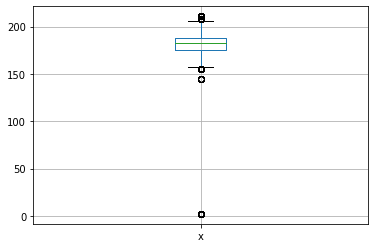

In [334]:
bp = pd.DataFrame.boxplot(df_tennis['winner_ht'], return_type='dict')

In [335]:
outliers_ht = [flier.get_ydata() for flier in bp["fliers"]][0]
outliers_ht = list(dict.fromkeys(outliers_ht))
#ht_values = list(set(df_tennis['winner_ht'].dropna().unique().tolist() ) - set(outliers_ht))

In [336]:
w_names = df_tennis[df_tennis['winner_ht'].isin(outliers_ht)]['winner_name'].unique().tolist()

In [337]:
l_names = df_tennis[df_tennis['loser_ht'].isin(outliers_ht)]['loser_name'].unique().tolist()

In [338]:
w_names.sort() == l_names.sort() #True

True

In [339]:
df_tennis.loc[df_tennis['winner_name'].isin(w_names), 'winner_ht'] = np.nan
df_tennis.loc[df_tennis['loser_name'].isin(w_names), 'loser_ht'] = np.nan

In [340]:
male_names = df_players[df_players['sex']=='M']['whole_name'].tolist()
female_names = df_players[df_players['sex']=='F']['whole_name'].tolist()

In [341]:
#corrections using sex and ioc

In [342]:
df_ht = pd.concat([df_tennis[['winner_name', 'winner_ht', 'winner_ioc']].rename(columns={"winner_name": "name", "winner_ht": "ht", "winner_ioc": "ioc"}), df_tennis[['loser_name', 'loser_ht', 'loser_ioc']].rename(columns={"loser_name": "name", "loser_ht": "ht", "loser_ioc": "ioc"})]).drop_duplicates()

In [343]:
df_ht

,name,ht,ioc
0,Kei Nishikori,178.0,JPN
1,Daniil Medvedev,198.0,RUS
3,Jo Wilfried Tsonga,188.0,FRA
5,Jeremy Chardy,188.0,FRA
8,Alex De Minaur,183.0,AUS
...,...,...,...
186074,Sara Errani,NaN,ITA
186080,unknown unknown,NaN,RUS
186095,Marie Bouzkova,NaN,CZE
186106,unknown unknown,NaN,MEX


In [344]:
male_avg_ht = df_ht[(df_ht['name'].isin(male_names))].groupby('ioc').mean().reset_index()

In [345]:
for index, row in male_avg_ht[~male_avg_ht['ht'].isna()].iterrows():
    df_tennis.loc[(df_tennis['winner_ht'].isna()) & (df_tennis['winner_name'].isin(male_names)) & (df_tennis['winner_ioc']==row['ioc']), 'winner_ht']=row['ht']
    df_tennis.loc[(df_tennis['loser_ht'].isna()) & (df_tennis['loser_name'].isin(male_names)) & (df_tennis['loser_ioc']==row['ioc']), 'loser_ht']=row['ht']

In [346]:
female_avg_ht = df_ht[(df_ht['name'].isin(female_names))].groupby('ioc').mean().reset_index()

In [347]:
for index, row in female_avg_ht[~female_avg_ht['ht'].isna()].iterrows():
    df_tennis.loc[(df_tennis['winner_ht'].isna()) & (df_tennis['winner_name'].isin(female_names)) & (df_tennis['winner_ioc']==row['ioc']), 'winner_ht']=row['ht']
    df_tennis.loc[(df_tennis['loser_ht'].isna()) & (df_tennis['loser_name'].isin(female_names)) & (df_tennis['loser_ioc']==row['ioc']), 'loser_ht']=row['ht']

In [348]:
generic_avg_ht = df_ht[(df_ht['name'].isin(female_names))].groupby('ioc').mean().reset_index()

In [349]:
for index, row in generic_avg_ht[~generic_avg_ht['ht'].isna()].iterrows():
    df_tennis.loc[(df_tennis['winner_ht'].isna()) & (df_tennis['winner_ioc']==row['ioc']), 'winner_ht']=row['ht']
    df_tennis.loc[(df_tennis['loser_ht'].isna()) & (df_tennis['loser_ioc']==row['ioc']), 'loser_ht']=row['ht']

In [350]:
#correction using sex

In [351]:
male_mean = df_ht[df_ht['name'].isin(male_names)]['ht'].mean()

In [352]:
female_mean = df_ht[df_ht['name'].isin(female_names)]['ht'].mean()

In [353]:
df_tennis.loc[(df_tennis['winner_ht'].isna()) & (df_tennis['winner_name'].isin(male_names)), 'winner_ht']=male_mean
df_tennis.loc[(df_tennis['loser_ht'].isna()) & (df_tennis['loser_name'].isin(male_names)), 'loser_ht']=male_mean

In [354]:
df_tennis.loc[(df_tennis['winner_ht'].isna()) & (df_tennis['winner_name'].isin(female_names)), 'winner_ht']=female_mean
df_tennis.loc[(df_tennis['loser_ht'].isna()) & (df_tennis['loser_name'].isin(female_names)), 'loser_ht']=female_mean

In [355]:
df_players['height'] = -1

In [356]:
df_tennis['loser_ht'].fillna(value=df_ht['ht'].mean(), inplace=True) 

In [357]:
df_tennis['winner_ht'].fillna(value=df_ht['ht'].mean(), inplace=True) 

In [358]:
def round_2(x):
    return float("{:.2f}".format(x))

In [359]:
df_tennis['winner_ht'] = df_tennis['winner_ht'].map(round_2)
df_tennis['loser_ht'] = df_tennis['loser_ht'].map(round_2)

In [360]:
win_name_ht = dict(zip(df_tennis.winner_name, df_tennis.winner_ht))
loser_name_ht = dict(zip(df_tennis.loser_name, df_tennis.loser_ht))

names_ht_dict = win_name_ht.copy()
names_ht_dict.update(loser_name_ht)

In [361]:
for index, row in df_players.iterrows():
    if row['whole_name'] in names_ht_dict:
        df_players.loc[index, 'height'] = names_ht_dict[row['whole_name']]

In [362]:
df_players

,whole_name,sex,ioc,id,hand,best_rank,best_rank_points,best_of_3_match,best_of_5_match,best_of_3_wins(%),...,m_19,w_19,m_20,w_20,m_21,w_21,w_finals,l_finals,tot_minutes,height
0,Kei Nishikori,M,JPN,105453.0,R,4,5010,208,75,64,...,43,29,6,2,40,24,3,9,33023.911876,178.00
1,Daniil Medvedev,M,RUS,106421.0,R,2,10620,324,58,70,...,80,59,38,28,50,40,14,8,38112.287152,198.00
2,Jo Wilfried Tsonga,M,FRA,104542.0,R,7,3480,148,49,64,...,66,44,2,-1,9,1,7,2,21506.786448,188.00
3,Jeremy Chardy,M,FRA,104871.0,R,28,1265,242,38,55,...,62,34,10,3,40,22,1,2,28833.134645,188.00
4,Alex De Minaur,M,AUS,200282.0,R,15,2690,234,38,61,...,57,38,23,13,38,21,6,9,29048.475556,183.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10098,Dilara Sultanova,F,TKM,223315.0,U,0,0,1,0,0,...,-1,-1,1,-1,-1,-1,0,0,44.112350,173.77
10099,Madeleine Jessup,F,USA,223075.0,U,0,0,1,0,0,...,-1,-1,1,-1,-1,-1,0,0,73.520583,173.18
10100,Katie Codd,F,USA,223216.0,U,0,0,1,0,0,...,-1,-1,1,-1,-1,-1,0,0,55.140437,173.18
10101,Amy Huang,F,USA,223217.0,U,0,0,1,0,0,...,-1,-1,1,-1,-1,-1,0,0,128.661020,173.18


In [363]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

age_limit = 80
df_tennis.loc[df_tennis['winner_age'] > age_limit, 'winner_age'] = np.nan
df_tennis.loc[df_tennis['loser_age'] > age_limit, 'loser_age'] = np.nan
#df_tennis[df_tennis['winner_name'] == 'Daniil Medvedev'][['tourney_name','winner_name','winner_age']]
#df_tennis[df_tennis['winner_name'] == 'Kei Nishikori'][['tourney_name','winner_name','winner_age']]
#df_tennis[df_tennis['winner_name'] == 'Pam Casale'][['tourney_name','winner_name','winner_age']]

df_tennis_tmp = df_tennis.copy()

winner = df_tennis_tmp[df_tennis_tmp['winner_age'].isnull() & df_tennis_tmp['tourney_date'].notnull()]['winner_name'].drop_duplicates().tolist()
loser  = df_tennis_tmp[df_tennis_tmp['loser_age'].isnull() & df_tennis_tmp['tourney_date'].notnull()]['loser_name'].drop_duplicates().tolist()
merged = list(set(winner + loser))

for pl_name in merged:
    tourney_date = None
    pl_age = None
    
    ref = df_tennis_tmp[(df_tennis_tmp['winner_age'].notnull()) & (df_tennis_tmp['winner_name']==pl_name) & (df_tennis_tmp['tourney_date'].notnull())]
    if len(ref) != 0:
        pl_age = ref.iloc[0]['winner_age']
        tourney_date = ref.iloc[0]['tourney_date']
    elif len(ref) != 0:
        ref = df_tennis_tmp[(df_tennis_tmp['loser_age'].notnull()) & (df_tennis_tmp['loser_name']==pl_name) & (df_tennis_tmp['tourney_date'].notnull())]
        pl_age = ref.iloc[0]['loser_age']
        tourney_date = ref.iloc[0]['tourney_date']
    
    if pl_age is not None:
        str_tdate = str(tourney_date).replace(".0", "")
        tdate = datetime.strptime(str_tdate, "%Y%m%d")
        decimal_years = pl_age
        decimal_days = decimal_years * 365
        year = decimal_days//365
        tmp_days = decimal_days - (year*365)
        month = tmp_days//31
        days = tmp_days - (month * 31)
        birthdate = tdate - relativedelta(years=year, months=month, days=days)
        
        
        #print(str(pl_name) + '-' + str(pl_age) + '-' + str(delta.days/365))
        
        upd_loser = df_tennis_tmp[(df_tennis_tmp['loser_age'].isnull()) & (df_tennis_tmp['loser_name']==pl_name) & (df_tennis_tmp['tourney_date'].notnull())]
        for index, row in upd_loser.iterrows():
            tmp_tourney_date = str(row['tourney_date']).replace(".0", "")
            tmp_tdate = datetime.strptime(str_tdate, "%Y%m%d")
            
            delta = tmp_tdate - birthdate
            days = delta.days/365
            #print(str(days))
            
            df_tennis.loc[
                (df_tennis['loser_age'].isnull()) & 
                (df_tennis['loser_name']==pl_name)  & 
                (df_tennis['tourney_date']==tourney_date), 
                'loser_age'] = days
            
            df_tennis.loc[
                (df_tennis['winner_age'].isnull()) & 
                (df_tennis['winner_name']==pl_name)  & 
                (df_tennis['tourney_date']==tourney_date), 
                'winner_age'] = days
            
        upd_winner = df_tennis_tmp[(df_tennis_tmp['winner_age'].isnull()) & (df_tennis_tmp['winner_name']==pl_name) & (df_tennis_tmp['tourney_date'].notnull())]
        for index, row in upd_winner.iterrows():
            tmp_tourney_date = str(row['tourney_date']).replace(".0", "")
            tmp_tdate = datetime.strptime(str_tdate, "%Y%m%d")
            
            delta = tmp_tdate - birthdate
            days = delta.days/365
            #print(str(days))
            
            df_tennis.loc[
                (df_tennis['loser_age'].isnull()) & 
                (df_tennis['loser_name']==pl_name)  & 
                (df_tennis['tourney_date']==tourney_date), 
                'loser_age'] = days
            
            df_tennis.loc[
                (df_tennis['winner_age'].isnull()) & 
                (df_tennis['winner_name']==pl_name)  & 
                (df_tennis['tourney_date']==tourney_date), 
                'winner_age'] = days
        #break            

In [364]:
# before was 2851
df_tennis[df_tennis['winner_age'].isnull()][['tourney_date','winner_name','winner_age','loser_name','loser_age']]

,tourney_date,winner_name,winner_age,loser_name,loser_age
322,20190114.0,Daniil Medvedev,NaN,David Goffin,28.104038
5890,20190914.0,Ari Fahresi,NaN,Ajeet Rai,20.640657
19065,20170724.0,Venia Yeung,NaN,Mihoki Miyahara,22.187543
21732,20170925.0,Nour Dib,NaN,Eva Kovaleva,15.162218
36444,20161212.0,Daria Lukyanova,NaN,Anca Craciun,16.837782
...,...,...,...,...,...
186114,20171113.0,unknown unknown,NaN,Nina Stojanovic,21.289528
186117,20171113.0,unknown unknown,NaN,Kai Lin Zhang,27.791923
186121,20171113.0,unknown unknown,NaN,Vivian Heisen,NaN
186124,20171113.0,Veronika Kudermetova,NaN,Ingrid Neel,19.421918


In [365]:
#  before was 6536
df_tennis[df_tennis['loser_age'].isnull()][['tourney_date','winner_name','winner_age','loser_name','loser_age']]

,tourney_date,winner_name,winner_age,loser_name,loser_age
5883,20190914.0,Manuel Sanchez,28.676249,Adolfo Daniel Vallejo,NaN
6808,20180203.0,Manuel Sanchez,27.066393,Ignacio Garcia,NaN
6810,20180203.0,Manuel Sanchez,27.066393,Sebastian Arcila,NaN
6811,20180203.0,Luis Patino,24.314853,Ignacio Garcia,NaN
14665,20170612.0,Monika Kilnarova,17.678303,Paulina Bakaite,NaN
...,...,...,...,...,...
186119,20171113.0,Sabina Sharipova,23.192334,unknown unknown,NaN
186120,20171113.0,unknown unknown,21.289528,Na Lae Han,NaN
186121,20171113.0,unknown unknown,NaN,Vivian Heisen,NaN
186122,20171113.0,Priscilla Hon,19.512663,Kwan Yau Ng,NaN


#### winner_age/loser_age, try to calculate birthdate

In [366]:
for index, row in df_players.iterrows():
      
    age_tdate = df_tennis[
            (df_tennis['winner_name']==row['whole_name']) & 
            (df_tennis['winner_age'].notnull()) & 
            (df_tennis['tourney_date'].notnull())][['winner_age','tourney_date']]
    if age_tdate is None:
        age_tdate = df_tennis[
            (df_tennis['loser_name']==row['whole_name']) & 
            (df_tennis['loser_age'].notnull()) & 
            (df_tennis['tourney_date'].notnull())][['loser_age','tourney_date']]
        
    if age_tdate.size > 0:
        str_tdate = str(age_tdate['tourney_date'].iloc[0]).replace(".0", "")
        
        tdate = datetime.strptime(str_tdate, "%Y%m%d")

        decimal_years = age_tdate['winner_age'].iloc[0]
        decimal_days = decimal_years * 365

        year = decimal_days//365

        tmp_days = decimal_days - (year*365)

        month = tmp_days//31
        days = tmp_days - (month * 31)


        birthdate = tdate - relativedelta(years=year, months=month, days=days)

        strbirthdate = birthdate.strftime("%d/%m/%Y")

        df_players.loc[df_players['whole_name'] == row['whole_name'], 'birthdate'] = strbirthdate

df_players.loc[df_players['birthdate'].isnull(),'birthdate']='unknown' 
df_players


,whole_name,sex,ioc,id,hand,best_rank,best_rank_points,best_of_3_match,best_of_5_match,best_of_3_wins(%),...,w_19,m_20,w_20,m_21,w_21,w_finals,l_finals,tot_minutes,height,birthdate
0,Kei Nishikori,M,JPN,105453.0,R,4,5010,208,75,64,...,29,6,2,40,24,3,9,33023.911876,178.00,23/12/1989
1,Daniil Medvedev,M,RUS,106421.0,R,2,10620,324,58,70,...,59,38,28,50,40,14,8,38112.287152,198.00,15/02/1996
2,Jo Wilfried Tsonga,M,FRA,104542.0,R,7,3480,148,49,64,...,44,2,-1,9,1,7,2,21506.786448,188.00,20/04/1985
3,Jeremy Chardy,M,FRA,104871.0,R,28,1265,242,38,55,...,34,10,3,40,22,1,2,28833.134645,188.00,15/02/1987
4,Alex De Minaur,M,AUS,200282.0,R,15,2690,234,38,61,...,38,23,13,38,21,6,9,29048.475556,183.00,20/02/1999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10098,Dilara Sultanova,F,TKM,223315.0,U,0,0,1,0,0,...,-1,1,-1,-1,-1,0,0,44.112350,173.77,unknown
10099,Madeleine Jessup,F,USA,223075.0,U,0,0,1,0,0,...,-1,1,-1,-1,-1,0,0,73.520583,173.18,unknown
10100,Katie Codd,F,USA,223216.0,U,0,0,1,0,0,...,-1,1,-1,-1,-1,0,0,55.140437,173.18,unknown
10101,Amy Huang,F,USA,223217.0,U,0,0,1,0,0,...,-1,1,-1,-1,-1,0,0,128.661020,173.18,unknown


In [367]:
df_tennis.loc[df_tennis['loser_age'].isnull(),'loser_age'] = -1 
df_tennis.loc[df_tennis['winner_age'].isnull(),'winner_age'] = -1
df_players

,whole_name,sex,ioc,id,hand,best_rank,best_rank_points,best_of_3_match,best_of_5_match,best_of_3_wins(%),...,w_19,m_20,w_20,m_21,w_21,w_finals,l_finals,tot_minutes,height,birthdate
0,Kei Nishikori,M,JPN,105453.0,R,4,5010,208,75,64,...,29,6,2,40,24,3,9,33023.911876,178.00,23/12/1989
1,Daniil Medvedev,M,RUS,106421.0,R,2,10620,324,58,70,...,59,38,28,50,40,14,8,38112.287152,198.00,15/02/1996
2,Jo Wilfried Tsonga,M,FRA,104542.0,R,7,3480,148,49,64,...,44,2,-1,9,1,7,2,21506.786448,188.00,20/04/1985
3,Jeremy Chardy,M,FRA,104871.0,R,28,1265,242,38,55,...,34,10,3,40,22,1,2,28833.134645,188.00,15/02/1987
4,Alex De Minaur,M,AUS,200282.0,R,15,2690,234,38,61,...,38,23,13,38,21,6,9,29048.475556,183.00,20/02/1999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10098,Dilara Sultanova,F,TKM,223315.0,U,0,0,1,0,0,...,-1,1,-1,-1,-1,0,0,44.112350,173.77,unknown
10099,Madeleine Jessup,F,USA,223075.0,U,0,0,1,0,0,...,-1,1,-1,-1,-1,0,0,73.520583,173.18,unknown
10100,Katie Codd,F,USA,223216.0,U,0,0,1,0,0,...,-1,1,-1,-1,-1,0,0,55.140437,173.18,unknown
10101,Amy Huang,F,USA,223217.0,U,0,0,1,0,0,...,-1,1,-1,-1,-1,0,0,128.661020,173.18,unknown


#### Utility function to compute percentage

In [368]:
def percentage_ratio(total, partial):
    if (total <= 0): return -1
    return round(((partial*100)/total), 2)

#### w_svpt, l_svpt, w_1stIn, l_1stIn, w_1stWon, l_1stWon, w_2ndWon, l_2ndWon, w_df, l_df

In [369]:
w_1stIn_dict = df_tennis[(~df_tennis['w_1stIn'].isnull()) & (~df_tennis['w_1stWon'].isnull())].groupby('winner_name')['w_1stIn'].apply(list).to_dict()   
for key in w_1stIn_dict.keys():
    w_1stIn_dict[key]= sum(w_1stIn_dict[key])
    
l_1stIn_dict = df_tennis[(~df_tennis['l_1stIn'].isnull()) & (~df_tennis['l_1stWon'].isnull())].groupby('loser_name')['l_1stIn'].apply(list).to_dict()   
for key in l_1stIn_dict.keys():
    l_1stIn_dict[key]= sum(l_1stIn_dict[key])
    
w_1stwin_dict = df_tennis[(~df_tennis['w_1stIn'].isnull()) & (~df_tennis['w_1stWon'].isnull())].groupby('winner_name')['w_1stWon'].apply(list).to_dict()   
for key in w_1stwin_dict.keys():
    w_1stwin_dict[key]= sum(w_1stwin_dict[key])
    
l_1stwin_dict = df_tennis[(~df_tennis['l_1stIn'].isnull()) & (~df_tennis['l_1stWon'].isnull())].groupby('loser_name')['l_1stWon'].apply(list).to_dict()   
for key in l_1stwin_dict.keys():
    l_1stwin_dict[key]= sum(l_1stwin_dict[key])

In [370]:
#considered matches
w_match = df_tennis[(~df_tennis['w_1stIn'].isnull()) & (~df_tennis['w_1stWon'].isnull())].groupby('winner_name')['w_1stWon'].agg('count').to_dict()
l_match = df_tennis[(~df_tennis['l_1stIn'].isnull()) & (~df_tennis['l_1stWon'].isnull())].groupby('loser_name')['w_1stWon'].agg('count').to_dict()
#all matches
w_match_tot = df_tennis.fillna(-1).groupby('winner_name')['w_1stWon'].agg('count').to_dict()
l_match_tot = df_tennis.fillna(-1).groupby('loser_name')['w_1stWon'].agg('count').to_dict()

#df_tennis.groupby('loser_name')['w_1stWon'].agg('count').to_dict()

In [371]:
#% of the won first services on the total fisrt services not on the total served points
df_players['sv1st_win%'] = -1

In [372]:
for index, row in df_players.iterrows():
    name = row['whole_name']
    
    tot_match = 0
    matches = 0
    total_first = 0
    won_first = 0
    
    if name in w_1stIn_dict.keys():
        total_first += w_1stIn_dict[name]
        won_first += w_1stwin_dict[name]
        matches += w_match[name]
    if name in l_1stIn_dict.keys():
        total_first += l_1stIn_dict[name]
        won_first += l_1stwin_dict[name]
        matches += l_match[name]
        
    if name in w_match_tot.keys():
        tot_match += w_match_tot[name]
    if name in l_match_tot.keys():
        tot_match += l_match_tot[name]
        
    if tot_match!=0 and total_first!=0:
        df_players.loc[index, 'sv1st_win%'] = won_first/total_first*matches/tot_match*100

In [373]:
df_players

,whole_name,sex,ioc,id,hand,best_rank,best_rank_points,best_of_3_match,best_of_5_match,best_of_3_wins(%),...,m_20,w_20,m_21,w_21,w_finals,l_finals,tot_minutes,height,birthdate,sv1st_win%
0,Kei Nishikori,M,JPN,105453.0,R,4,5010,208,75,64,...,6,2,40,24,3,9,33023.911876,178.00,23/12/1989,68.039207
1,Daniil Medvedev,M,RUS,106421.0,R,2,10620,324,58,70,...,38,28,50,40,14,8,38112.287152,198.00,15/02/1996,72.797523
2,Jo Wilfried Tsonga,M,FRA,104542.0,R,7,3480,148,49,64,...,2,-1,9,1,7,2,21506.786448,188.00,20/04/1985,78.830286
3,Jeremy Chardy,M,FRA,104871.0,R,28,1265,242,38,55,...,10,3,40,22,1,2,28833.134645,188.00,15/02/1987,71.899458
4,Alex De Minaur,M,AUS,200282.0,R,15,2690,234,38,61,...,23,13,38,21,6,9,29048.475556,183.00,20/02/1999,68.705462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10098,Dilara Sultanova,F,TKM,223315.0,U,0,0,1,0,0,...,1,-1,-1,-1,0,0,44.112350,173.77,unknown,-1.000000
10099,Madeleine Jessup,F,USA,223075.0,U,0,0,1,0,0,...,1,-1,-1,-1,0,0,73.520583,173.18,unknown,-1.000000
10100,Katie Codd,F,USA,223216.0,U,0,0,1,0,0,...,1,-1,-1,-1,0,0,55.140437,173.18,unknown,-1.000000
10101,Amy Huang,F,USA,223217.0,U,0,0,1,0,0,...,1,-1,-1,-1,0,0,128.661020,173.18,unknown,-1.000000


In [374]:
w_df_dict = df_tennis[(~df_tennis['w_df'].isnull()) & (~df_tennis['w_svpt'].isnull())].groupby('winner_name')['w_df'].apply(list).to_dict()   
for key in w_df_dict.keys():
    w_df_dict[key]= sum(w_df_dict[key])
    
l_df_dict = df_tennis[(~df_tennis['l_df'].isnull()) & (~df_tennis['l_svpt'].isnull())].groupby('loser_name')['l_df'].apply(list).to_dict()   
for key in l_df_dict.keys():
    l_df_dict[key]= sum(l_df_dict[key])
    
w_sv_dict = df_tennis[(~df_tennis['w_df'].isnull()) & (~df_tennis['w_svpt'].isnull())].groupby('winner_name')['w_svpt'].apply(list).to_dict()   
for key in w_sv_dict.keys():
    w_sv_dict[key]= sum(w_sv_dict[key])
    
l_sv_dict = df_tennis[(~df_tennis['l_df'].isnull()) & (~df_tennis['l_svpt'].isnull())].groupby('loser_name')['l_svpt'].apply(list).to_dict()   
for key in l_sv_dict.keys():
    l_sv_dict[key]= sum(l_sv_dict[key])

In [375]:
#considered matches
w_match = df_tennis[(~df_tennis['w_df'].isnull()) & (~df_tennis['w_svpt'].isnull())].groupby('winner_name')['w_df'].agg('count').to_dict()
l_match = df_tennis[(~df_tennis['l_df'].isnull()) & (~df_tennis['l_svpt'].isnull())].groupby('loser_name')['l_df'].agg('count').to_dict()

In [376]:
df_players['df%'] = -1

In [377]:
for index, row in df_players.iterrows():
    name = row['whole_name']
    
    tot_match = 0
    matches = 0
    total_points = 0
    df = 0
    if name in w_df_dict.keys():
        total_points += w_sv_dict[name]
        df += w_df_dict[name]
        matches += w_match[name]
    if name in l_df_dict.keys():
        total_points += l_sv_dict[name]
        df += l_df_dict[name]
        matches += l_match[name]
        
    if name in w_match_tot.keys():
        tot_match += w_match_tot[name]
    if name in l_match_tot.keys():
        tot_match += l_match_tot[name]
        
    if tot_match!=0 and total_points!=0:
        df_players.loc[index, 'df%'] = df/total_points*matches/tot_match*100

In [378]:
df_players[['whole_name', 'sv1st_win%', 'df%']]

,whole_name,sv1st_win%,df%
0,Kei Nishikori,68.039207,2.756199
1,Daniil Medvedev,72.797523,4.232247
2,Jo Wilfried Tsonga,78.830286,3.234273
3,Jeremy Chardy,71.899458,5.080522
4,Alex De Minaur,68.705462,3.508521
...,...,...,...
10098,Dilara Sultanova,-1.000000,-1.000000
10099,Madeleine Jessup,-1.000000,-1.000000
10100,Katie Codd,-1.000000,-1.000000
10101,Amy Huang,-1.000000,-1.000000


In [379]:
df_tennis['w_df'].fillna(value=-1, inplace=True) 

In [380]:
df_tennis['l_df'].fillna(value=-1, inplace=True) 

In [381]:
df_tennis['w_1stIn'].fillna(value=-1, inplace=True) 

In [382]:
df_tennis['l_1stIn'].fillna(value=-1, inplace=True) 

In [383]:
df_tennis['w_1stWon'].fillna(value=-1, inplace=True) 

In [384]:
df_tennis['l_1stWon'].fillna(value=-1, inplace=True) 

In [385]:
df_tennis['w_2ndWon'].fillna(value=-1, inplace=True) 

In [386]:
df_tennis['l_2ndWon'].fillna(value=-1, inplace=True) 

**Service point and ace statistics and cleaning**

In [387]:
w_svpt = df_tennis[(~df_tennis['w_svpt'].isnull())].groupby('winner_name')['w_svpt'].agg('sum').to_dict()
l_svpt = df_tennis[(~df_tennis['l_svpt'].isnull())].groupby('loser_name')['l_svpt'].agg('sum').to_dict()

#merging players svpts
for l_key in l_svpt.keys():
    if(l_key in w_svpt.keys()):
        l_svpt[l_key]+=w_svpt[l_key]
for w_key in w_svpt.keys():
    if(w_key not in l_svpt.keys()):
        l_svpt[w_key]= w_svpt[w_key]

merged_svp = l_svpt

In [388]:
df_tennis['w_svpt'].fillna(value=-1, inplace=True) 
df_tennis.loc[df_tennis['l_svpt'] > 300, 'w_svpt'] = -1

In [389]:
df_tennis['l_svpt'].fillna(value=-1, inplace=True) 
df_tennis.loc[df_tennis['l_svpt'] > 300, 'l_svpt'] = -1

#### w_ace

In [390]:
df_players['ace_perc'] = -1
w_ace = df_tennis[(~df_tennis['w_ace'].isnull()) & (df_tennis['w_svpt'] != -1)].groupby('winner_name')['w_ace'].agg('sum').to_dict()
l_ace = df_tennis[(~df_tennis['l_ace'].isnull()) & (df_tennis['l_svpt'] != -1)].groupby('loser_name')['l_ace'].agg('sum').to_dict()

#merging players aces
for l_key in l_ace.keys():
    if(l_key in w_ace.keys()):
        l_ace[l_key]+=w_ace[l_key]
for w_key in w_ace.keys():
    if(w_key not in l_ace.keys()):
        l_ace[w_key]= w_ace[w_key]
merged_ace = l_ace
        
for name in merged_ace.keys():
    if (merged_ace[name]):
        svpt = merged_svp[name]
        ace = merged_ace[name]
        df_players.loc[df_players['whole_name'] == name, 'ace_perc'] = percentage_ratio(svpt, ace)

In [391]:
df_players[df_players['whole_name'] == 'Jessica Pegula']#.sort_values(by='ace_perc',ascending=False)

,whole_name,sex,ioc,id,hand,best_rank,best_rank_points,best_of_3_match,best_of_5_match,best_of_3_wins(%),...,m_21,w_21,w_finals,l_finals,tot_minutes,height,birthdate,sv1st_win%,df%,ace_perc
361,Jessica Pegula,F,USA,202468.0,R,25,2540,242,0,59,...,50,34,1,6,21206.867031,170.0,24/02/1994,36.636333,2.223138,3.42


In [392]:
df_tennis['w_ace'].fillna(value=-1, inplace=True)

In [393]:
df_tennis['l_ace'].fillna(value=-1, inplace=True)

#### w_SvGms and l_SvGms

Alla fine di un set senza tie-break, per stabilire nel set successivo il giocatore a cui affidare l'esecuzione della battuta (battitore): dividere per 2 la somma di tutti i game disputati nel set. Se il resto è 0 (numero pari di game già disputati), il battitore è lo stesso del primo game del set, altrimenti è l'altro

Se il set termina con un tie-break (numero dispari di game già disputati), il battitore del primo game del set successivo NON è lo stesso del primo game del set appena terminato (ossia il primo battitore del tie-break). 

In [394]:
def count_service_games(match):
    sets = match.split( )
    
    player1 = 0
    player2 = 0
    
    first = 0
    
    #empty score
    if len(sets)==0:
        return [-1,-1]
    
    if len(sets)==1 and (Retirement(sets[0]) or Default(sets[0]) or Bye(sets[0]) or Walkover(sets[0])):
            return [-1,-1]
    
    if Retirement(sets[len(sets)-1]) or Default(sets[len(sets)-1]):
        check_sets = len(sets)-1
    else:
        check_sets = len(sets)
    
    #analysis of complete sets
    for i in range(check_sets):
        
        count = 0
        
        game = sets[i].replace("[", "").replace("]", "")

        if "(" in game or ")" in game:
            #tie-break
            index_open = game.index("(")
            
            points = game[0:index_open].split("-")
            
            #errors in the score
            if not points[0].isdigit() or not points[1].isdigit():
                return [-1,-1]
            
            count = int(points[0]) + int(points[1]) -1
            
            x = count//2
            y = count - x #y>=x

            if first == 0:
                player1 += y  
                player2 += x
            else:
                player1 += x  
                player2 += y
                
            first = (first+1)%2
            
        else:
            #no tie-break
            points = game.split("-")
            
            #errors in the score
            if not points[0].isdigit() or not points[1].isdigit():
                return [-1,-1]
            
            count = int(points[0]) + int(points[1])
            
            x = count//2
            y = count - x #y>=x

            if first == 0:
                player1 += y  
                player2 += x
            else:
                player1 += x  
                player2 += y
                
            if count%2 != 0:
                first = (first+1)%2
            
        
    return [player1, player2]

In [395]:
#correction of errors in case not nulls
for index,row in df_tennis[(~df_tennis['l_SvGms'].isnull()) & (~df_tennis['w_SvGms'].isnull()) & (df_tennis['score']!="")].iterrows():
    
    if len(sets)==1 and (Walkover(sets[0]) or Retirement(sets[0]) or Default(sets[0]) or Bye(sets[0])):
        df_tennis.loc[index, 'w_SvGms']=0
        df_tennis.loc[index, 'l_SvGms']=0
        continue
    
    if not validity_match(row['score'].split(), row['best_of']):
        continue
    
    result = count_service_games(row['score'])
    x = result[0]
    y = result[1]
    if x == -1:
        continue
    
    if not((row['w_SvGms']==x and row['l_SvGms']==y) or (row['w_SvGms']==y and row['l_SvGms']==x)): 
        if row['w_SvGms']==x:
            df_tennis.loc[index, 'l_SvGms']=y
        elif row['w_SvGms']==y:
            df_tennis.loc[index, 'l_SvGms']=x
        elif row['l_SvGms']==x:
            df_tennis.loc[index, 'w_SvGms']=y
        elif row['l_SvGms']==y:
            df_tennis.loc[index, 'w_SvGms']=x
        else:
            df_tennis.loc[index, 'w_SvGms']=x
            df_tennis.loc[index, 'l_SvGms']=y
        

In [396]:
#correction of errors in case of nulls
for index,row in df_tennis[(df_tennis['score']!="") & (df_tennis['l_SvGms'].isnull())].iterrows():
    
    sets = row['score'].split()
    
    if len(sets)==1 and (Walkover(sets[0]) or Retirement(sets[0]) or Default(sets[0]) or Bye(sets[0])):
        df_tennis.loc[index, 'w_SvGms']=0
        df_tennis.loc[index, 'l_SvGms']=0
        continue
    
    if not validity_match(sets, row['best_of']):
        continue
    
    result = count_service_games(row['score'])
    x = result[0]
    y = result[1]
    if x == -1:
        continue
    
    winner = math.isnan(float(row['w_SvGms']))
    
    if not winner:
        if row['w_SvGms']==x:
            df_tennis.loc[index, 'l_SvGms']=y
        elif row['w_SvGms']==y:
            df_tennis.loc[index, 'l_SvGms']=x
        else:
            df_tennis.loc[index, 'w_SvGms']=x
            df_tennis.loc[index, 'l_SvGms']=y
    else:
        df_tennis.loc[index, 'w_SvGms']=x
        df_tennis.loc[index, 'l_SvGms']=y

In [397]:
#correction of errors in case of nulls
for index,row in df_tennis[(df_tennis['score']!="") & (df_tennis['w_SvGms'].isnull())].iterrows():
    
    if len(sets)==1 and (Walkover(sets[0]) or Retirement(sets[0]) or Default(sets[0]) or Bye(sets[0])):
        df_tennis.loc[index, 'w_SvGms']=0
        df_tennis.loc[index, 'l_SvGms']=0
        continue
    
    if not validity_match(row['score'].split(), row['best_of']):
        continue
    
    result = count_service_games(row['score'])
    x = result[0]
    y = result[1]
    if x == -1:
        continue
    
    loser = math.isnan(float(row['l_SvGms']))
    
    if not loser:
        if row['l_SvGms']==x:
            df_tennis.loc[index, 'w_SvGms']=y
        elif row['l_SvGms']==y:
            df_tennis.loc[index, 'w_SvGms']=x
        else:
            df_tennis.loc[index, 'w_SvGms']=x
            df_tennis.loc[index, 'l_SvGms']=y
    else:
        df_tennis.loc[index, 'w_SvGms']=x
        df_tennis.loc[index, 'l_SvGms']=y

In [398]:
df_tennis['l_SvGms'].fillna(value=-1, inplace=True)
df_tennis['w_SvGms'].fillna(value=-1, inplace=True)

**Breakpoint statistics and cleaning**

In [399]:
df_tennis[df_tennis['w_bpFaced'].isnull()]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_entry,winner_name,...,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue
108,2019-0451,Doha,Hard,32.0,A,20181231.0,288.0,106065.0,U,Marco Cecchinato,...,-1.0,0.0,NaN,NaN,20.0,1819.0,58.0,860.0,2923.0,550943.19
262,2019-M001,Sydney,Hard,32.0,P,20190107.0,290.0,202428.0,U,Kiki Bertens,...,-1.0,0.0,NaN,NaN,9.0,4360.0,18.0,2910.0,3258.0,567644.24
681,2019-580,Australian Open,Hard,128.0,G,20190114.0,112.0,215370.0,U,Bianca Andreescu,...,-1.0,-1.0,NaN,NaN,106.0,571.0,175.0,335.0,15583.0,2781000.18
730,2019-580,Australian Open,Hard,128.0,G,20190114.0,161.0,202424.0,U,Conny Perrin,...,-1.0,-1.0,NaN,NaN,150.0,385.0,178.0,325.0,15583.0,2781000.18
768,2019-580,Australian Open,Hard,128.0,G,20190114.0,199.0,215370.0,U,Bianca Andreescu,...,-1.0,-1.0,NaN,NaN,106.0,571.0,136.0,438.0,15583.0,2781000.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186118,unknown,Taipei,Hard,32.0,C,20171113.0,-1.0,NaN,U,unknown unknown,...,-1.0,8.0,NaN,11.0,0.0,228.0,0.0,204.0,2722.0,638954.72
186120,unknown,Taipei,Hard,32.0,I,20171113.0,-1.0,NaN,U,unknown unknown,...,9.0,11.0,2.0,NaN,230.0,0.0,250.0,221.0,2722.0,443410.22
186122,unknown,Taipei,Hard,32.0,C,20171113.0,-1.0,211880.0,U,Priscilla Hon,...,-1.0,8.0,8.0,NaN,0.0,0.0,0.0,8.0,2722.0,638954.72
186123,unknown,Taipei,Hard,32.0,I,20171113.0,250.0,NaN,U,unknown unknown,...,-1.0,13.0,7.0,11.0,0.0,322.0,280.0,183.0,2722.0,443410.22


In [400]:
w_bpF = df_tennis[(~df_tennis['w_bpFaced'].isnull()) & (df_tennis['w_bpFaced'] > 0)].groupby('winner_name')['w_bpFaced'].agg('sum').to_dict()
l_bpF = df_tennis[(~df_tennis['l_bpFaced'].isnull()) & (df_tennis['w_bpFaced'] > 0)].groupby('loser_name')['l_bpFaced'].agg('sum').to_dict()

#merging players bpFs
for l_key in l_bpF.keys():
    if(l_key in w_bpF.keys()):
        l_bpF[l_key]+=w_bpF[l_key]
for w_key in w_bpF.keys():
    if(w_key not in l_bpF.keys()):
        l_bpF[w_key]= w_bpF[w_key]
merged_bpF = l_bpF

In [401]:
df_tennis['w_bpFaced'].fillna(value=-1, inplace=True) 

In [402]:
df_tennis['l_bpFaced'].fillna(value=-1, inplace=True) 

In [403]:
df_tennis[df_tennis['w_bpSaved'].isnull()]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_entry,winner_name,...,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue
108,2019-0451,Doha,Hard,32.0,A,20181231.0,288.0,106065.0,U,Marco Cecchinato,...,-1.0,0.0,NaN,-1.0,20.0,1819.0,58.0,860.0,2923.0,550943.19
262,2019-M001,Sydney,Hard,32.0,P,20190107.0,290.0,202428.0,U,Kiki Bertens,...,-1.0,0.0,NaN,-1.0,9.0,4360.0,18.0,2910.0,3258.0,567644.24
681,2019-580,Australian Open,Hard,128.0,G,20190114.0,112.0,215370.0,U,Bianca Andreescu,...,-1.0,-1.0,NaN,-1.0,106.0,571.0,175.0,335.0,15583.0,2781000.18
730,2019-580,Australian Open,Hard,128.0,G,20190114.0,161.0,202424.0,U,Conny Perrin,...,-1.0,-1.0,NaN,-1.0,150.0,385.0,178.0,325.0,15583.0,2781000.18
768,2019-580,Australian Open,Hard,128.0,G,20190114.0,199.0,215370.0,U,Bianca Andreescu,...,-1.0,-1.0,NaN,-1.0,106.0,571.0,136.0,438.0,15583.0,2781000.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186112,unknown,Taipei,Hard,32.0,I,20171113.0,251.0,206368.0,U,Veronika Kudermetova,...,7.0,-1.0,NaN,-1.0,0.0,0.0,0.0,27.0,3535.0,443410.22
186116,unknown,Taipei,Hard,32.0,I,20171113.0,-1.0,214562.0,WC,Ingrid Neel,...,21.0,16.0,NaN,22.0,704.0,27.0,150.0,0.0,3535.0,638954.72
186121,unknown,Taipei,Hard,32.0,C,20171113.0,-1.0,NaN,U,unknown unknown,...,15.0,8.0,8.0,-1.0,176.0,335.0,0.0,131.0,3535.0,638954.72
186122,unknown,Taipei,Hard,32.0,C,20171113.0,-1.0,211880.0,U,Priscilla Hon,...,-1.0,8.0,8.0,-1.0,0.0,0.0,0.0,8.0,2722.0,638954.72


In [404]:
df_players['bpS_perc'] = -1
w_bpS = df_tennis[(~df_tennis['w_bpSaved'].isnull()) & (df_tennis['w_bpFaced'] != -1)].groupby('winner_name')['w_bpSaved'].agg('sum').to_dict()
l_bpS = df_tennis[(~df_tennis['l_bpSaved'].isnull()) & (df_tennis['l_bpFaced'] != -1)].groupby('loser_name')['l_bpSaved'].agg('sum').to_dict()

#merging players bpSaveds
for l_key in l_bpS.keys():
    if(l_key in w_bpS.keys()):
        l_bpS[l_key]+=w_bpS[l_key]
        
for w_key in w_bpS.keys():
    if(w_key not in l_bpS.keys()):
        l_bpS[w_key]= w_bpS[w_key]
merged_bpS = l_bpS
              
for name in merged_bpS.keys():
    if (name in l_bpF.keys()):
        bpF = merged_bpF[name]
        bpS = merged_bpS[name]
        df_players.loc[df_players['whole_name'] == name, 'bpS_perc'] = percentage_ratio(bpF, bpS)

In [405]:
df_tennis['w_bpSaved'].fillna(value=-1, inplace=True) 

In [406]:
df_tennis['l_bpSaved'].fillna(value=-1, inplace=True) 

In [407]:
df_players

,whole_name,sex,ioc,id,hand,best_rank,best_rank_points,best_of_3_match,best_of_5_match,best_of_3_wins(%),...,w_21,w_finals,l_finals,tot_minutes,height,birthdate,sv1st_win%,df%,ace_perc,bpS_perc
0,Kei Nishikori,M,JPN,105453.0,R,4,5010,208,75,64,...,24,3,9,33023.911876,178.00,23/12/1989,68.039207,2.756199,3.84,63.51
1,Daniil Medvedev,M,RUS,106421.0,R,2,10620,324,58,70,...,40,14,8,38112.287152,198.00,15/02/1996,72.797523,4.232247,10.32,64.60
2,Jo Wilfried Tsonga,M,FRA,104542.0,R,7,3480,148,49,64,...,1,7,2,21506.786448,188.00,20/04/1985,78.830286,3.234273,12.36,69.89
3,Jeremy Chardy,M,FRA,104871.0,R,28,1265,242,38,55,...,22,1,2,28833.134645,188.00,15/02/1987,71.899458,5.080522,10.41,64.55
4,Alex De Minaur,M,AUS,200282.0,R,15,2690,234,38,61,...,21,6,9,29048.475556,183.00,20/02/1999,68.705462,3.508521,4.68,63.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10098,Dilara Sultanova,F,TKM,223315.0,U,0,0,1,0,0,...,-1,0,0,44.112350,173.77,unknown,-1.000000,-1.000000,-1.00,-1.00
10099,Madeleine Jessup,F,USA,223075.0,U,0,0,1,0,0,...,-1,0,0,73.520583,173.18,unknown,-1.000000,-1.000000,-1.00,-1.00
10100,Katie Codd,F,USA,223216.0,U,0,0,1,0,0,...,-1,0,0,55.140437,173.18,unknown,-1.000000,-1.000000,-1.00,-1.00
10101,Amy Huang,F,USA,223217.0,U,0,0,1,0,0,...,-1,0,0,128.661020,173.18,unknown,-1.000000,-1.000000,-1.00,-1.00


#### count the games played, won and lost

In [408]:
count_dict_w = df_tennis['winner_name'].value_counts().sort_index().to_dict()
count_dict_l = df_tennis['loser_name'].value_counts().sort_index().to_dict()


df_players['wmatch'] = 0
df_players['lmatch'] = 0
df_players['nmatch'] = 0

for index,row in df_players.iterrows():
    name = row['whole_name']
    w = count_dict_w.get(name)
    l = count_dict_l.get(name)
    if w is None:
        w = 0
    if l is None:
        l = 0
    tot = w + l
    df_players.loc[df_players['whole_name'] == name, 'wmatch'] = w
    df_players.loc[df_players['whole_name'] == name, 'lmatch'] = l
    df_players.loc[df_players['whole_name'] == name, 'nmatch'] = tot


In [409]:
df_players

,whole_name,sex,ioc,id,hand,best_rank,best_rank_points,best_of_3_match,best_of_5_match,best_of_3_wins(%),...,tot_minutes,height,birthdate,sv1st_win%,df%,ace_perc,bpS_perc,wmatch,lmatch,nmatch
0,Kei Nishikori,M,JPN,105453.0,R,4,5010,208,75,64,...,33023.911876,178.00,23/12/1989,68.039207,2.756199,3.84,63.51,191,92,283
1,Daniil Medvedev,M,RUS,106421.0,R,2,10620,324,58,70,...,38112.287152,198.00,15/02/1996,72.797523,4.232247,10.32,64.60,267,115,382
2,Jo Wilfried Tsonga,M,FRA,104542.0,R,7,3480,148,49,64,...,21506.786448,188.00,20/04/1985,78.830286,3.234273,12.36,69.89,125,72,197
3,Jeremy Chardy,M,FRA,104871.0,R,28,1265,242,38,55,...,28833.134645,188.00,15/02/1987,71.899458,5.080522,10.41,64.55,149,131,280
4,Alex De Minaur,M,AUS,200282.0,R,15,2690,234,38,61,...,29048.475556,183.00,20/02/1999,68.705462,3.508521,4.68,63.20,164,108,272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10098,Dilara Sultanova,F,TKM,223315.0,U,0,0,1,0,0,...,44.112350,173.77,unknown,-1.000000,-1.000000,-1.00,-1.00,0,1,1
10099,Madeleine Jessup,F,USA,223075.0,U,0,0,1,0,0,...,73.520583,173.18,unknown,-1.000000,-1.000000,-1.00,-1.00,0,1,1
10100,Katie Codd,F,USA,223216.0,U,0,0,1,0,0,...,55.140437,173.18,unknown,-1.000000,-1.000000,-1.00,-1.00,0,1,1
10101,Amy Huang,F,USA,223217.0,U,0,0,1,0,0,...,128.661020,173.18,unknown,-1.000000,-1.000000,-1.00,-1.00,0,1,1


In [410]:
df_players.loc[df_players['nmatch']==1]
df_players.loc[df_players['nmatch']!=(df_players['best_of_5_match'] + df_players['best_of_3_match'])]

,whole_name,sex,ioc,id,hand,best_rank,best_rank_points,best_of_3_match,best_of_5_match,best_of_3_wins(%),...,tot_minutes,height,birthdate,sv1st_win%,df%,ace_perc,bpS_perc,wmatch,lmatch,nmatch
2869,Takuto Niki,M,JPN,105026.0,U,304,756,62,0,43,...,5703.000000,176.29,13/10/1987,68.481473,3.253753,7.24,60.79,28,36,64
2967,Andrei Vasilevski,M,BLR,105781.0,R,591,939,41,0,41,...,3379.000000,194.50,03/06/1991,73.140903,4.916279,11.20,61.51,18,25,43
3341,Steven De Waard,M,AUS,122059.0,R,723,1320,27,0,33,...,2179.844554,187.42,08/05/1991,67.838765,5.762179,5.34,63.91,10,19,29
4473,Lyubov Kostenko,F,UKR,221371.0,R,998,1144,69,0,49,...,5396.013710,173.75,30/03/2003,-1.000000,-1.000000,-1.00,-1.00,35,36,71
4547,Sophia Fry,F,AUS,221862.0,R,0,0,17,0,23,...,1226.979113,170.86,02/08/2000,-1.000000,-1.000000,-1.00,-1.00,5,14,19
4833,Liisa Varul,F,TUR,224486.0,U,0,0,5,0,20,...,360.250856,177.50,unknown,-1.000000,-1.000000,-1.00,-1.00,2,5,7


#### count the win and lose in surfaces

In [411]:
dict_surf = df_tennis.groupby(['winner_name'])['surface'].value_counts().to_dict()
surface_type_array = df_tennis['surface'].unique()

for index,row in df_players.iterrows():
    name = row['whole_name']
    for surface in surface_type_array:
        win_in_surface = dict_surf.get((name, surface))
        if win_in_surface is None:
            win_in_surface = 0              
        df_players.loc[df_players['whole_name'] == name, "w_surface_" + surface] = str(win_in_surface)
    #if index == 100:
    #    break
df_players

,whole_name,sex,ioc,id,hand,best_rank,best_rank_points,best_of_3_match,best_of_5_match,best_of_3_wins(%),...,ace_perc,bpS_perc,wmatch,lmatch,nmatch,w_surface_Hard,w_surface_Clay,w_surface_Grass,w_surface_Carpet,w_surface_unknown
0,Kei Nishikori,M,JPN,105453.0,R,4,5010,208,75,64,...,3.84,63.51,191,92,283,117,56,18,0,0
1,Daniil Medvedev,M,RUS,106421.0,R,2,10620,324,58,70,...,10.32,64.60,267,115,382,205,27,35,0,0
2,Jo Wilfried Tsonga,M,FRA,104542.0,R,7,3480,148,49,64,...,12.36,69.89,125,72,197,91,23,11,0,0
3,Jeremy Chardy,M,FRA,104871.0,R,28,1265,242,38,55,...,10.41,64.55,149,131,280,89,40,20,0,0
4,Alex De Minaur,M,AUS,200282.0,R,15,2690,234,38,61,...,4.68,63.20,164,108,272,117,16,31,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10098,Dilara Sultanova,F,TKM,223315.0,U,0,0,1,0,0,...,-1.00,-1.00,0,1,1,0,0,0,0,0
10099,Madeleine Jessup,F,USA,223075.0,U,0,0,1,0,0,...,-1.00,-1.00,0,1,1,0,0,0,0,0
10100,Katie Codd,F,USA,223216.0,U,0,0,1,0,0,...,-1.00,-1.00,0,1,1,0,0,0,0,0
10101,Amy Huang,F,USA,223217.0,U,0,0,1,0,0,...,-1.00,-1.00,0,1,1,0,0,0,0,0


In [412]:
dict_surf = df_tennis.groupby(['loser_name'])['surface'].value_counts().to_dict()
surface_type_array = df_tennis['surface'].unique()

for index,row in df_players.iterrows():
    name = row['whole_name']
    for surface in surface_type_array:
        win_in_surface = dict_surf.get((name, surface))
        if win_in_surface is None:
            win_in_surface = 0              
        df_players.loc[df_players['whole_name'] == name, "l_surface_" + surface] = str(win_in_surface)
    #if index == 100:
    #    break
df_players

,whole_name,sex,ioc,id,hand,best_rank,best_rank_points,best_of_3_match,best_of_5_match,best_of_3_wins(%),...,w_surface_Hard,w_surface_Clay,w_surface_Grass,w_surface_Carpet,w_surface_unknown,l_surface_Hard,l_surface_Clay,l_surface_Grass,l_surface_Carpet,l_surface_unknown
0,Kei Nishikori,M,JPN,105453.0,R,4,5010,208,75,64,...,117,56,18,0,0,55,28,9,0,0
1,Daniil Medvedev,M,RUS,106421.0,R,2,10620,324,58,70,...,205,27,35,0,0,73,26,16,0,0
2,Jo Wilfried Tsonga,M,FRA,104542.0,R,7,3480,148,49,64,...,91,23,11,0,0,46,18,8,0,0
3,Jeremy Chardy,M,FRA,104871.0,R,28,1265,242,38,55,...,89,40,20,0,0,77,39,15,0,0
4,Alex De Minaur,M,AUS,200282.0,R,15,2690,234,38,61,...,117,16,31,0,0,68,25,15,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10098,Dilara Sultanova,F,TKM,223315.0,U,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
10099,Madeleine Jessup,F,USA,223075.0,U,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
10100,Katie Codd,F,USA,223216.0,U,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
10101,Amy Huang,F,USA,223217.0,U,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [413]:
#save on file
df_players.to_csv(path_or_buf="players.csv")

### Correlation

In [414]:
df_tennis.dtypes

tourney_id             object
tourney_name           object
surface                object
draw_size             float64
tourney_level          object
tourney_date           object
match_num             float64
winner_id             float64
winner_entry           object
winner_name            object
winner_hand            object
winner_ht             float64
winner_ioc             object
winner_age            float64
loser_id              float64
loser_entry            object
loser_name             object
loser_hand             object
loser_ht              float64
loser_ioc              object
loser_age             float64
score                  object
best_of               float64
round                  object
minutes               float64
w_ace                 float64
w_df                  float64
w_svpt                float64
w_1stIn               float64
w_1stWon              float64
w_2ndWon              float64
w_SvGms               float64
w_bpSaved             float64
w_bpFaced 

In [415]:
df_numeric = df_tennis[['draw_size', 'best_of','minutes','w_ace','w_df','w_svpt','w_1stIn', 'w_1stWon', 'w_2ndWon', 
                        'w_SvGms', 'winner_rank', 'winner_rank_points', 'w_bpSaved',  'w_bpFaced','l_ace',
                        'l_df','l_svpt','l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'loser_rank', 
                        'loser_rank_points', 'l_bpSaved',  'l_bpFaced', 'tourney_spectators', 'tourney_revenue',
                       'winner_ht','winner_age','loser_ht','loser_age']]
df_numeric

,draw_size,best_of,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,...,loser_rank,loser_rank_points,l_bpSaved,l_bpFaced,tourney_spectators,tourney_revenue,winner_ht,winner_age,loser_ht,loser_age
0,32.0,3.0,124.000000,3.0,3.0,77.0,44.0,31.0,17.0,13.0,...,16.0,1977.0,10.0,15.0,3928.0,742618.69,178.00,29.021918,198.00,22.885695
1,32.0,3.0,82.000000,10.0,1.0,52.0,33.0,28.0,14.0,10.0,...,239.0,200.0,10.0,13.0,3928.0,742618.69,198.00,22.885695,188.00,33.705681
2,32.0,3.0,66.000000,2.0,2.0,47.0,33.0,26.0,9.0,8.0,...,40.0,1050.0,1.0,5.0,3928.0,742618.69,178.00,29.004791,188.00,31.882272
3,32.0,3.0,106.000000,12.0,2.0,68.0,43.0,34.0,15.0,11.0,...,31.0,1298.0,4.0,6.0,3928.0,742618.69,188.00,33.705681,183.00,19.868583
4,32.0,3.0,129.000000,12.0,3.0,105.0,68.0,48.0,25.0,16.0,...,18.0,1855.0,2.0,4.0,3928.0,742618.69,198.00,22.885695,196.00,28.010951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186123,32.0,3.0,95.576758,-1.0,1.0,-1.0,49.0,38.0,16.0,13.0,...,280.0,183.0,7.0,11.0,2722.0,443410.22,181.29,26.206708,165.60,26.904860
186124,32.0,3.0,71.000000,10.0,8.0,63.0,-1.0,32.0,-1.0,10.0,...,704.0,0.0,-1.0,-1.0,2722.0,443410.22,175.00,-1.000000,173.18,19.421918
186125,32.0,3.0,70.000000,-1.0,2.0,55.0,-1.0,-1.0,-1.0,-1.0,...,0.0,0.0,-1.0,11.0,2722.0,443410.22,173.33,26.642026,173.77,-1.000000
186126,32.0,3.0,115.000000,-1.0,8.0,-1.0,-1.0,-1.0,-1.0,12.0,...,0.0,0.0,3.0,-1.0,3535.0,443410.22,170.00,-1.000000,181.29,19.898630


<AxesSubplot:>

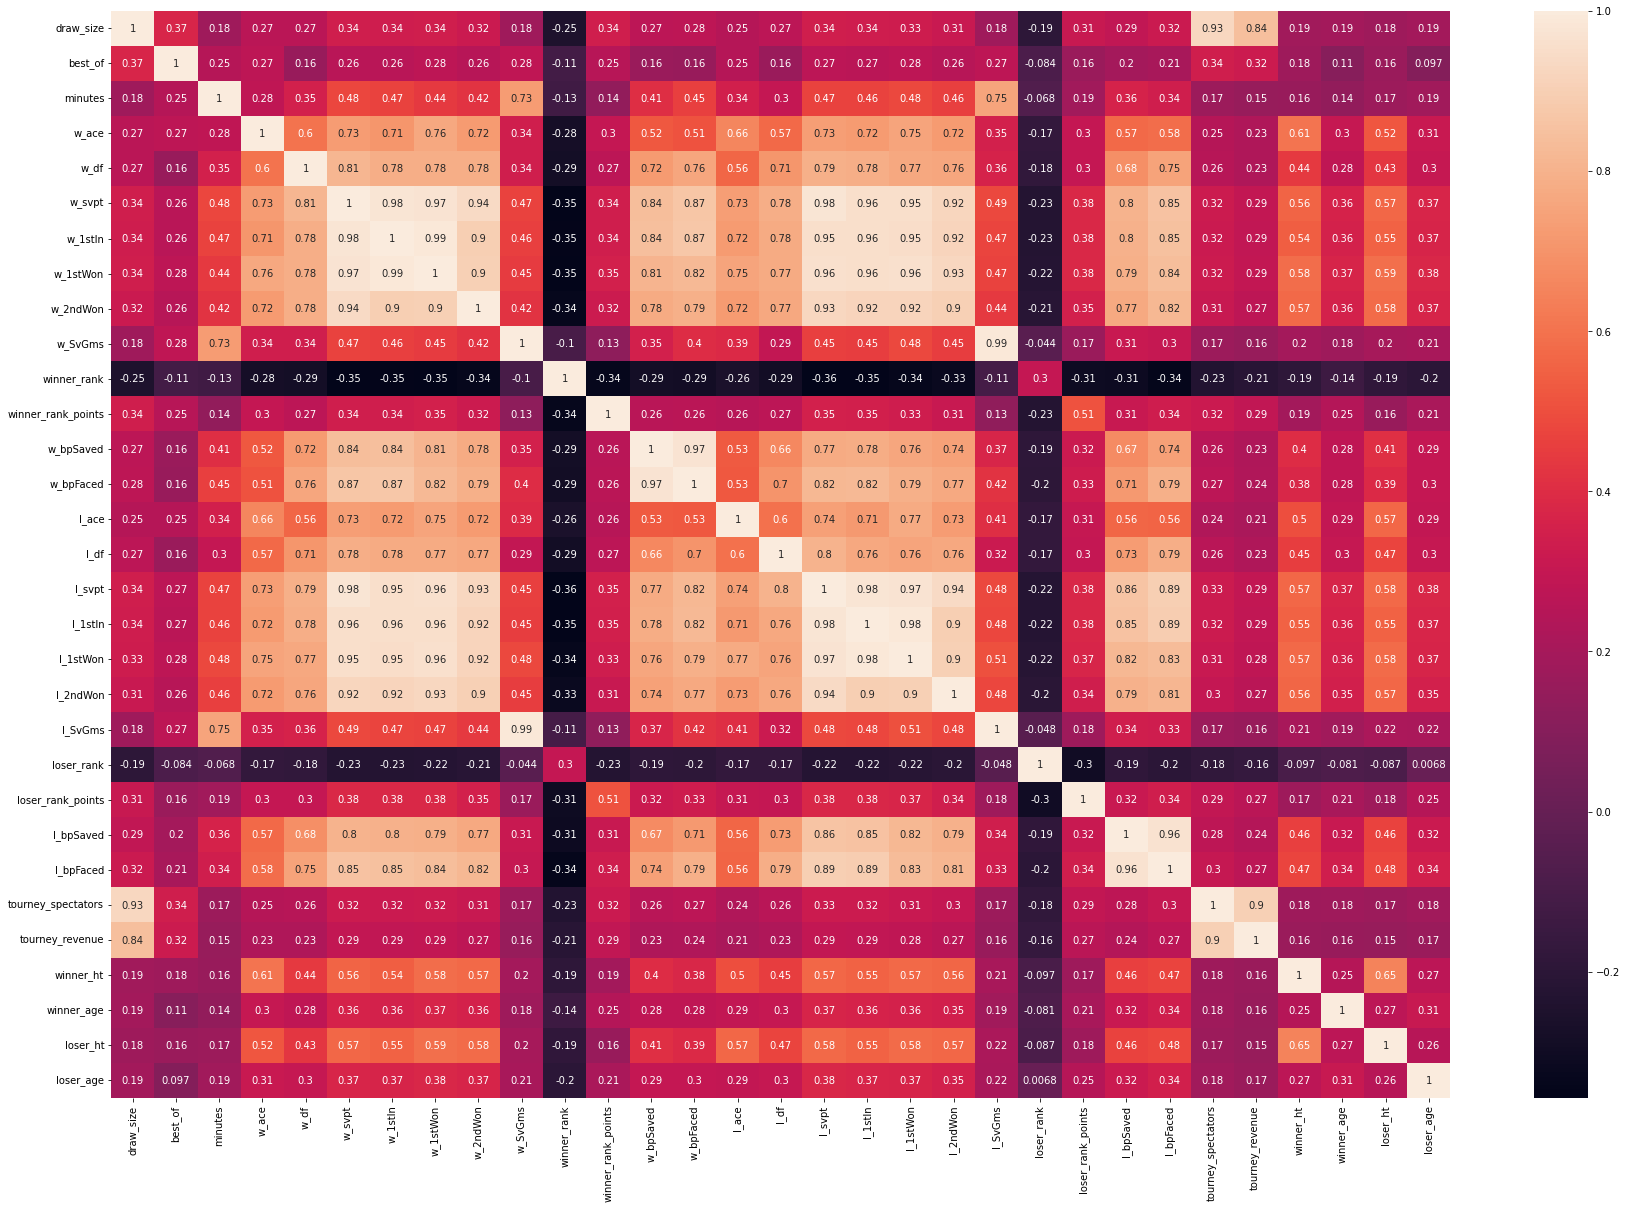

In [416]:
plt.figure(figsize = (30,20))
sns.heatmap(df_numeric.corr(), annot=True)

In [417]:
df_numeric = df_tennis[(df_tennis['w_ace']>=0) &
                       (df_tennis['w_df']>=0) &
                       (df_tennis['w_svpt']>=0) &
                       (df_tennis['w_1stIn']>=0) &
                       (df_tennis['w_1stWon']>=0) &
                       (df_tennis['w_2ndWon']>=0) &
                       (df_tennis['w_SvGms']>=0) &
                       (df_tennis['w_bpSaved']>=0) &
                       (df_tennis['w_bpFaced']>=0) &
                       (df_tennis['l_ace']>=0) &
                       (df_tennis['l_df']>=0) &
                       (df_tennis['l_svpt']>=0) &
                       (df_tennis['l_1stIn']>=0) &
                       (df_tennis['l_1stWon']>=0) &
                       (df_tennis['l_2ndWon']>=0) &
                       (df_tennis['l_SvGms']>=0) &
                       (df_tennis['l_bpSaved']>=0) &
                       (df_tennis['l_bpFaced']>=0) &
                        (df_tennis['winner_rank']>0) &
                        (df_tennis['loser_rank']>0)][['draw_size', 'best_of','minutes','w_ace','w_df','w_svpt',
                                                        'w_1stIn', 'w_1stWon', 'w_2ndWon', 
                        'w_SvGms', 'winner_rank', 'winner_rank_points', 'w_bpSaved',  'w_bpFaced','l_ace',
                        'l_df','l_svpt','l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'loser_rank', 
                        'loser_rank_points', 'l_bpSaved',  'l_bpFaced', 'tourney_spectators', 'tourney_revenue',
                       'winner_ht','winner_age','loser_ht','loser_age']]
df_numeric

,draw_size,best_of,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,...,loser_rank,loser_rank_points,l_bpSaved,l_bpFaced,tourney_spectators,tourney_revenue,winner_ht,winner_age,loser_ht,loser_age
0,32.0,3.0,124.0,3.0,3.0,77.0,44.0,31.0,17.0,13.0,...,16.0,1977.0,10.0,15.0,3928.0,742618.69,178.00,29.021918,198.00,22.885695
1,32.0,3.0,82.0,10.0,1.0,52.0,33.0,28.0,14.0,10.0,...,239.0,200.0,10.0,13.0,3928.0,742618.69,198.00,22.885695,188.00,33.705681
2,32.0,3.0,66.0,2.0,2.0,47.0,33.0,26.0,9.0,8.0,...,40.0,1050.0,1.0,5.0,3928.0,742618.69,178.00,29.004791,188.00,31.882272
3,32.0,3.0,106.0,12.0,2.0,68.0,43.0,34.0,15.0,11.0,...,31.0,1298.0,4.0,6.0,3928.0,742618.69,188.00,33.705681,183.00,19.868583
4,32.0,3.0,129.0,12.0,3.0,105.0,68.0,48.0,25.0,16.0,...,18.0,1855.0,2.0,4.0,3928.0,742618.69,198.00,22.885695,196.00,28.010951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177499,128.0,3.0,80.0,1.0,2.0,45.0,20.0,15.0,14.0,8.0,...,259.0,225.0,3.0,9.0,10338.0,2291040.00,176.25,19.603012,173.77,26.433949
177500,128.0,3.0,126.0,3.0,5.0,93.0,62.0,36.0,15.0,14.0,...,250.0,245.0,3.0,11.0,10338.0,2291040.00,170.00,32.301164,173.77,27.707050
177501,128.0,3.0,53.0,5.0,5.0,45.0,27.0,23.0,10.0,8.0,...,239.0,252.0,1.0,6.0,10338.0,2291040.00,176.50,22.529774,175.79,27.485284
177502,128.0,3.0,87.0,0.0,0.0,54.0,38.0,23.0,8.0,8.0,...,257.0,233.0,4.0,10.0,10338.0,2291040.00,173.77,27.791923,172.75,21.653662


<AxesSubplot:>

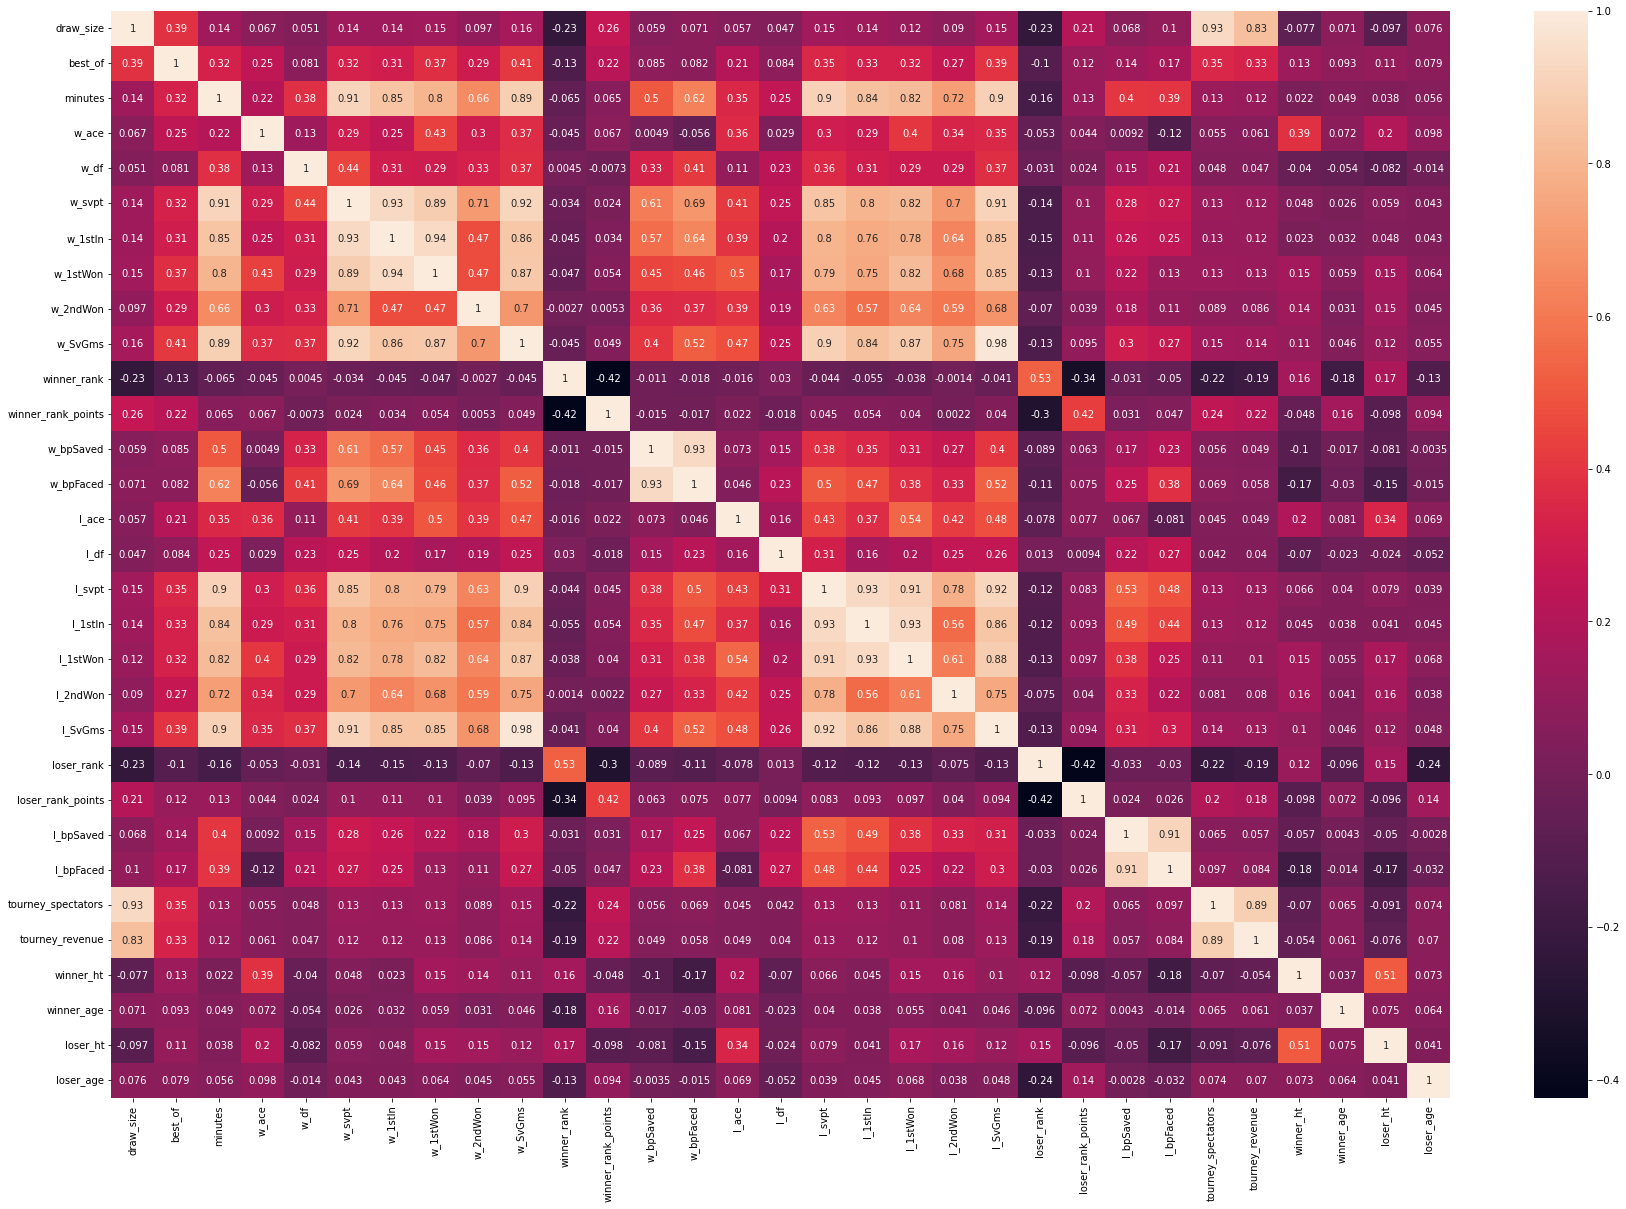

In [418]:
plt.figure(figsize = (30,20))
sns.heatmap(df_numeric.corr(), annot=True)

In [419]:
treshold = 0.8
correlation = df_numeric.corr()
correlation_filtered = correlation[correlation>treshold]
correlation_filtered = correlation[correlation_filtered.sum()>1]
correlation_filtered = correlation_filtered[correlation_filtered>treshold]
correlation_filtered = correlation_filtered.dropna(axis=1,how='all')
correlation_filtered

,draw_size,minutes,w_svpt,w_1stIn,w_1stWon,w_SvGms,w_bpSaved,w_bpFaced,l_svpt,l_1stIn,l_1stWon,l_SvGms,l_bpSaved,l_bpFaced,tourney_spectators,tourney_revenue
draw_size,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.931818,0.834362
minutes,NaN,1.000000,0.912653,0.851498,NaN,0.892803,NaN,NaN,0.904961,0.841910,0.822802,0.897391,NaN,NaN,NaN,NaN
w_svpt,NaN,0.912653,1.000000,0.932057,0.885391,0.921903,NaN,NaN,0.853965,NaN,0.816264,0.908466,NaN,NaN,NaN,NaN
w_1stIn,NaN,0.851498,0.932057,1.000000,0.937497,0.863942,NaN,NaN,NaN,NaN,NaN,0.851194,NaN,NaN,NaN,NaN
w_1stWon,NaN,NaN,0.885391,0.937497,1.000000,0.871293,NaN,NaN,NaN,NaN,0.824635,0.852784,NaN,NaN,NaN,NaN
w_SvGms,NaN,0.892803,0.921903,0.863942,0.871293,1.000000,NaN,NaN,0.898800,0.840022,0.874378,0.979326,NaN,NaN,NaN,NaN
w_bpSaved,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.927708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
w_bpFaced,NaN,NaN,NaN,NaN,NaN,NaN,0.927708,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
l_svpt,NaN,0.904961,0.853965,NaN,NaN,0.898800,NaN,NaN,1.000000,0.927848,0.908342,0.917993,NaN,NaN,NaN,NaN
l_1stIn,NaN,0.841910,NaN,NaN,NaN,0.840022,NaN,NaN,0.927848,1.000000,0.933692,0.857098,NaN,NaN,NaN,NaN


In [420]:
correlation_filtered = correlation[correlation<-treshold]
correlation_filtered = correlation_filtered[correlation_filtered<-treshold]
correlation_filtered.dropna(axis=1,how='all',inplace=True)
correlation_filtered

""
draw_size
best_of
minutes
w_ace
w_df
w_svpt
w_1stIn
w_1stWon
w_2ndWon
w_SvGms
